In [1]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# machine learning
from sklearn.decomposition import PCA

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [2]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-15-95.net.auckland.ac.nz


In [3]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 32

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [4]:
# gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# # y-axis processing
# # distance = 3.086e22
# # gw_df = gw_df / distance

# gw_mean = gw_df.mean().mean()
# print('Dataset mean: ',  gw_mean)

# gw_std = gw_df.std().mean()
# print('Dataset std: ',  gw_std)

# gw_scaling_factor = 5
# print('Dataset scaling factor (to match noise in generator): ',  gw_scaling_factor)

In [5]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        self.parameters = pd.read_csv(parameters_csv)
        self.data = pd.read_csv(signals_csv).astype('float32')
        # choose only the most important parameters for parameter estimation
        # self.parameters = self.parameters[['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']].astype('float32')
        # remove erroneous parameters
        keep_signals_idx = np.array(self.parameters[self.parameters['beta1_IC_b'] > 0].index)
        self.parameters = self.parameters.iloc[keep_signals_idx,:]
        self.parameters['beta1_IC_b_bins'] = pd.qcut(self.parameters['beta1_IC_b'], q=10, labels=False)
        self.parameters = self.parameters[['beta1_IC_b_bins']].astype('float32')

        self.parameters = self.parameters.values
        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1])).astype('float32')

        # drop corresponding signals which have erroneous parameter values
        self.data = self.data.iloc[:,keep_signals_idx]
        self.data = self.data.values
        self.original_data = self.data
        self.augmented_data = np.empty(shape = (256, 0)).astype('float32')

        ### signal augmentation section ###
        total_noise_mean = 0
        total_noise_std = 0
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            background_noise_segment = signal[:, 0:int(len(signal[0]) - 256)]
            signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]

            temp_data = np.insert(temp_data, temp_data.shape[1], signal, axis=1)            

            background_noise_mean = background_noise_segment.mean()
            background_noise_std = background_noise_segment.std()

            total_noise_mean = total_noise_mean + background_noise_mean
            total_noise_std = total_noise_std + background_noise_std

        self.background_noise_mean = total_noise_mean / self.data.shape[1]
        self.background_noise_std = total_noise_std / self.data.shape[1]

        self.data = temp_data
        ### end signal augmentation section ###

    ### augmentation methods ###
    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 203

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]
            # print(signal_after_window)

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    ### critical functions ###
    def calc_stats(self):
        self.mean = self.data.mean()
        print('Signal Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Signal Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Signal Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal


    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.mixture_augmentation(signal_1)
            # augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just sample parameters for now, haven't figured out a way to augment them to make consistent with signal augmentation
            augmented_parameter = self.parameters[idx_1, :]
            augmented_parameter = augmented_parameter.reshape(1, -1)

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print("Signal Dataset Size after Data Augmentation: ", self.data.shape)
        print("Parameter Dataset Size after Data Augmentation : ", self.parameters.shape)

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        signal_standardized = self.standardize(signal)

        return signal_standardized, parameter

In [6]:
def plot_waveforms_standardised(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)


        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim_signal)


        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()

/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_85813/2062963548.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_signal = np.roll(signal, int(shift))


Signal Dataset Size after Data Augmentation:  (256, 6000)
Parameter Dataset Size after Data Augmentation :  (6000, 1)
Signal Dataset mean:  -0.5214497
Signal Dataset std:  39.320305
Signal Dataset scaling factor (to match noise in generator):  5
Signal Batch Size:  torch.Size([32, 1, 256])


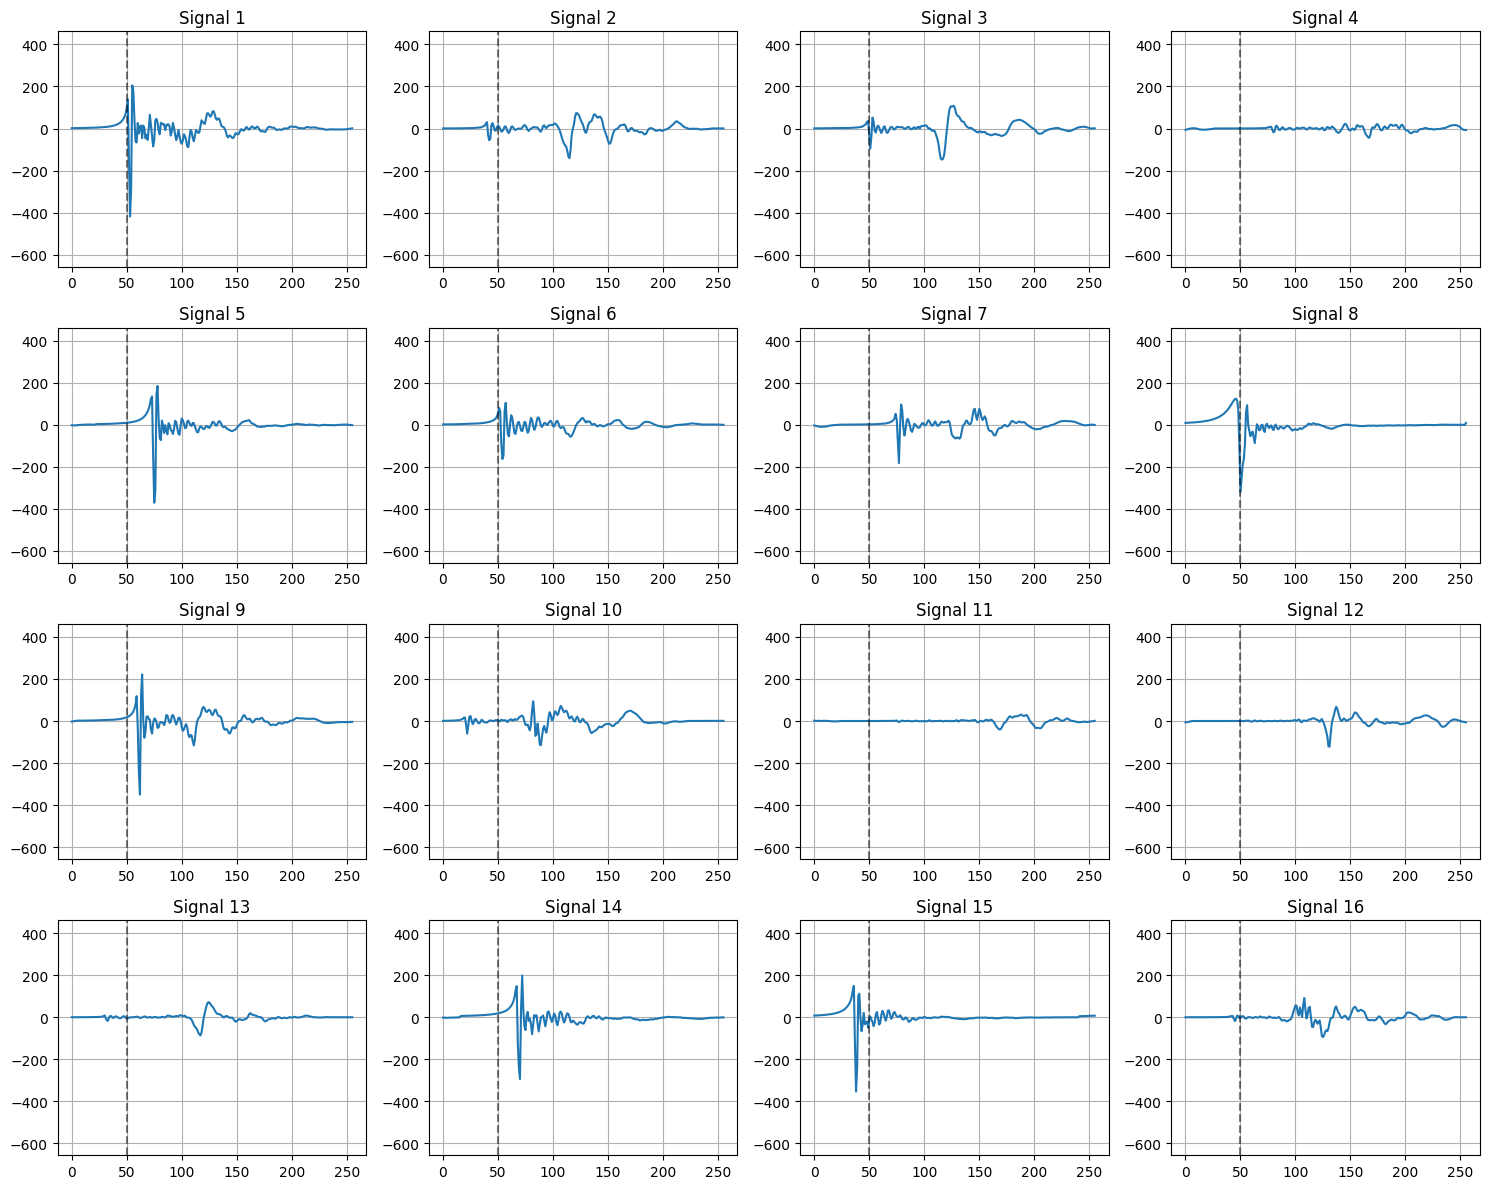

In [7]:
dataset = GWDataset("../data/gw-raw-data/richers_1764.csv", "../data/gw-raw-data/richers_1764_parameters.csv")

common_ylim_signal = dataset.get_common()
dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch, real_parameter_batch  = next(iter(dataloader))

print("Signal Batch Size: ", real_signals_batch.shape)

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']

plot_waveforms(real_signals_batch, real_parameter_batch)
# plot_waveforms_standardised(real_signals_batch, real_parameter_batch)

In [8]:
dataset.__len__()

6000

### Evaluation Metrics for Data Augmentation

#### KL Distance

In [9]:
num_bins = 100

# Compute histograms of P and Q to represent their probability distributions
# density=True argument ensures that they represent probability distributions (i.e., the integral under each histogram sums to 1).
hist_P, bin_edges_P = np.histogram(dataset.augmented_data, bins=num_bins, density=True)
hist_Q, bin_edges_Q = np.histogram(dataset.original_data, bins=num_bins, density=True)

kl_divergence = entropy(hist_P, hist_Q)
print(kl_divergence)

0.0908319313840423


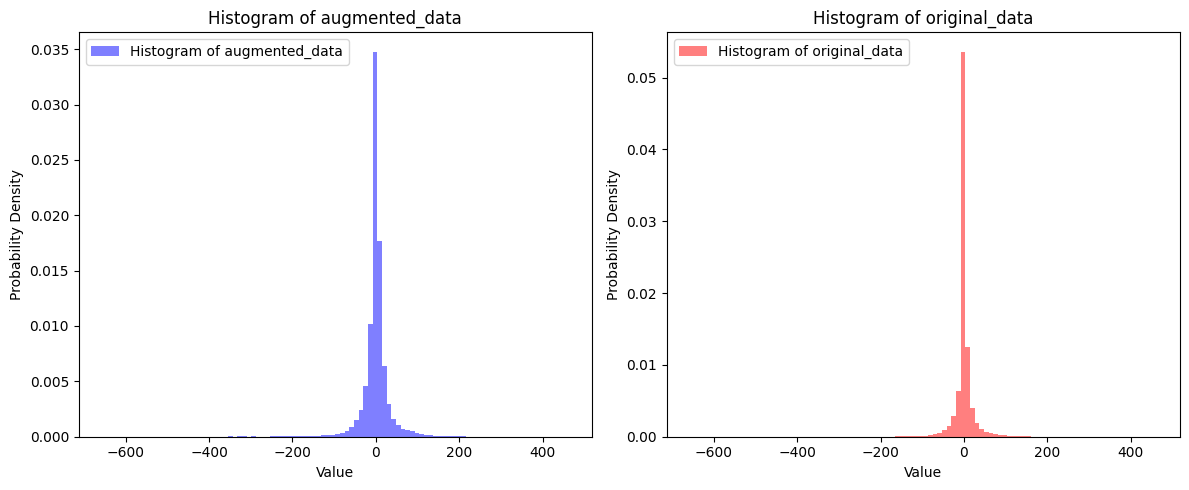

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(bin_edges_P[:-1], bins=bin_edges_P, weights=hist_P, density=True, alpha=0.5, color='blue', label='Histogram of augmented_data')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Histogram of augmented_data')
axes[0].legend(loc='best')

axes[1].hist(bin_edges_Q[:-1], bins=bin_edges_Q, weights=hist_Q, density=True, alpha=0.5, color='red', label='Histogram of original_data')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Histogram of original_data')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

#### PCA

In [11]:
# Assuming you have two datasets: dataset1 and dataset2
# Perform PCA on both datasets
pca = PCA(n_components=2)  # Choose the number of components
dataset1_pca = pca.fit_transform(dataset.original_data)
# dataset2_pca = pca.transform(dataset.augmented_data)
dataset2_pca = pca.fit_transform(dataset.data)

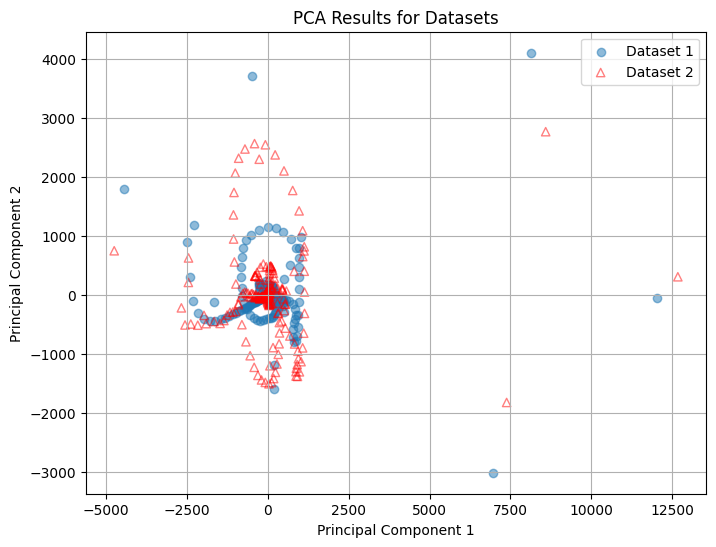

In [12]:

# Scatter plot for dataset1_pca with filled markers
plt.figure(figsize=(8, 6))
plt.scatter(dataset1_pca[:, 0], dataset1_pca[:, 1], label='Dataset 1', alpha=0.5, marker='o')  # 'o' represents filled circles

# Scatter plot for dataset2_pca with hollow markers
plt.scatter(dataset2_pca[:, 0], dataset2_pca[:, 1], label='Dataset 2', alpha=0.5, marker='^', facecolors='none', edgecolors='r')  # '^' represents unfilled triangles

plt.title('PCA Results for Datasets')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

### Weight Initialisation (Random Noise)

In [13]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [14]:
if (gans_type == 'cdcgans'):
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.z_reshape = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                # nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True)
            )
        
            self.y_reshape = nn.Sequential(
                # presuming that 10 is the number of class labels?
                nn.ConvTranspose1d(10, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                # nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True)
            )

            self.main = nn.Sequential(
                nn.ConvTranspose1d(ngf * 128, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 64),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z, y):
            print(z.shape)
            print(y.shape)
            z = self.z_reshape(z)
            y = self.y_reshape(y)
            z = torch.cat([z, y], 1)
            z = self.main(z)
            return z

if gans_type == 'dcgans':
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z
        
if gans_type == 'gans':
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(nz, ngf),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf, ngf * 2),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 2, ngf * 4),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 4, ngf * 8),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 8, 512),
            )

        def forward(self, z):
            z = z.view(z.size(0), -1)  # Flatten the tensor
            z = self.main(z)
            z = z.view(z.size(0), 1, 512)
            return z

In [15]:
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

if (gans_type == 'cdcgans'):
    model = Generator()
    summary(netG, input_size=[(nz, 1), (1, 1)])
if gans_type == 'dcgans' or gans_type == 'gans':
    model = Generator()
    summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias

### Discriminator

In [16]:
if (gans_type == "cdcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()

            self.x_reshape = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2),
            )

            self.y_reshape = nn.Sequential(
                nn.Embedding(10, 50),
                nn.Conv1d(10, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2),
            )

            self.main = nn.Sequential(
                # nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x, y):
            x = self.x_reshape(x)
            print(x.shape)
            y = self.y_reshape(y)
            x = torch.cat([x, y], 1)
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),

                ### Can increase model complexity here ###
                # nn.BatchNorm1d(ndf * 8),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "gans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                # nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(32, 16),
                # nn.BatchNorm1d(16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(16, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = self.main(x)
            return x

In [17]:
netD = Discriminator().to(device)
netD.apply(weights_init)

print(netD)

if (gans_type == "cdcgans"):
    model = Discriminator()
    summary(model, input_size=[(1, 256), (1, 1)])
if gans_type == 'dcgans' or gans_type == 'gans':
    model = Discriminator()
    summary(model, input_size=(1, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=8192, out_features=1, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Sigmoid()
  )
)
----------------------

### Loss functions and Optimisers

In [18]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=30)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=30)

# establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

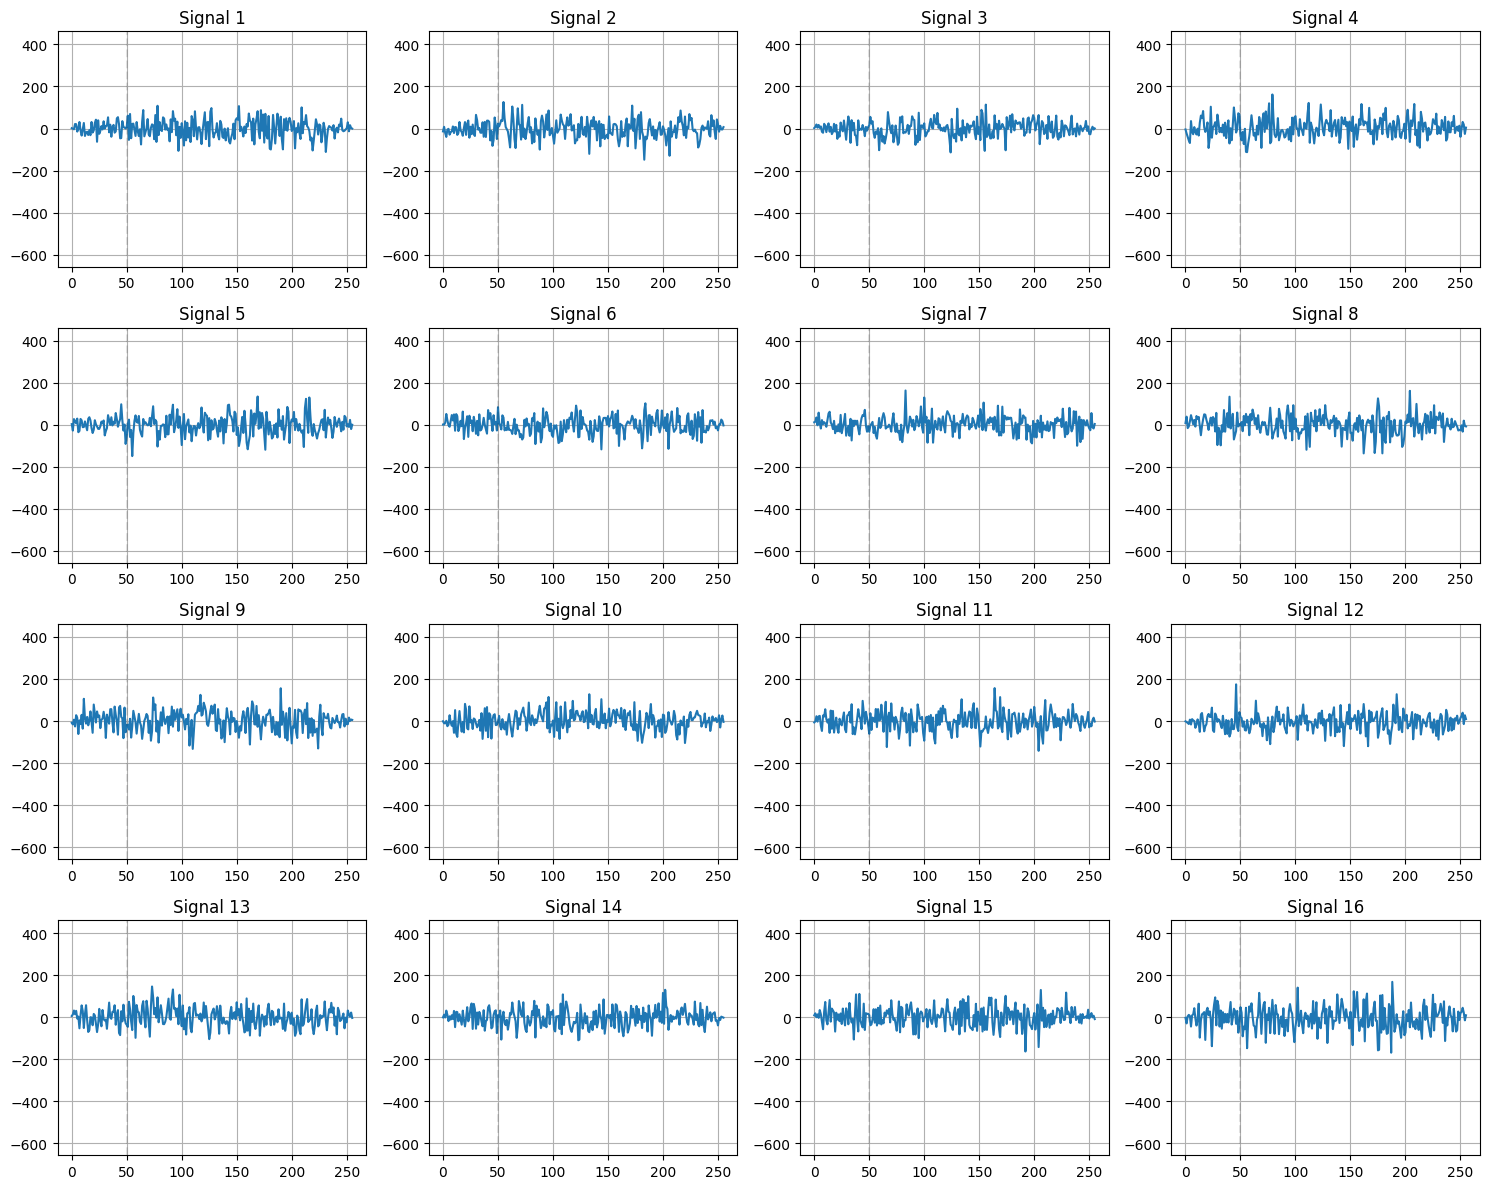

In [19]:
# create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)
    
fake_signals = netG(fixed_noise).detach().cpu()

# plot generated signals before training
with torch.no_grad():
    fake_signals = netG(fixed_noise).detach().cpu()
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    axes = axes.flatten()

    # plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(fake_signals.size(dim=2))
        y = fake_signals[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim_signal)

    for i in range(512, 8*4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_0.png')
    plt.show()

### Training

Starting Training Loop...
[0/32][0/188]	Loss_D: 1.4704	Loss_G: 0.6624	D(x): 0.5294	D(G(z)): 0.5026 / 0.4809
[0/32][50/188]	Loss_D: 1.2742	Loss_G: 0.8041	D(x): 0.4550	D(G(z)): 0.5612 / 0.5475
[0/32][100/188]	Loss_D: 1.1173	Loss_G: 0.9259	D(x): 0.3851	D(G(z)): 0.5735 / 0.5941
[0/32][150/188]	Loss_D: 1.2508	Loss_G: 0.8280	D(x): 0.4354	D(G(z)): 0.5483 / 0.5388
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000200 -> 0.0000197


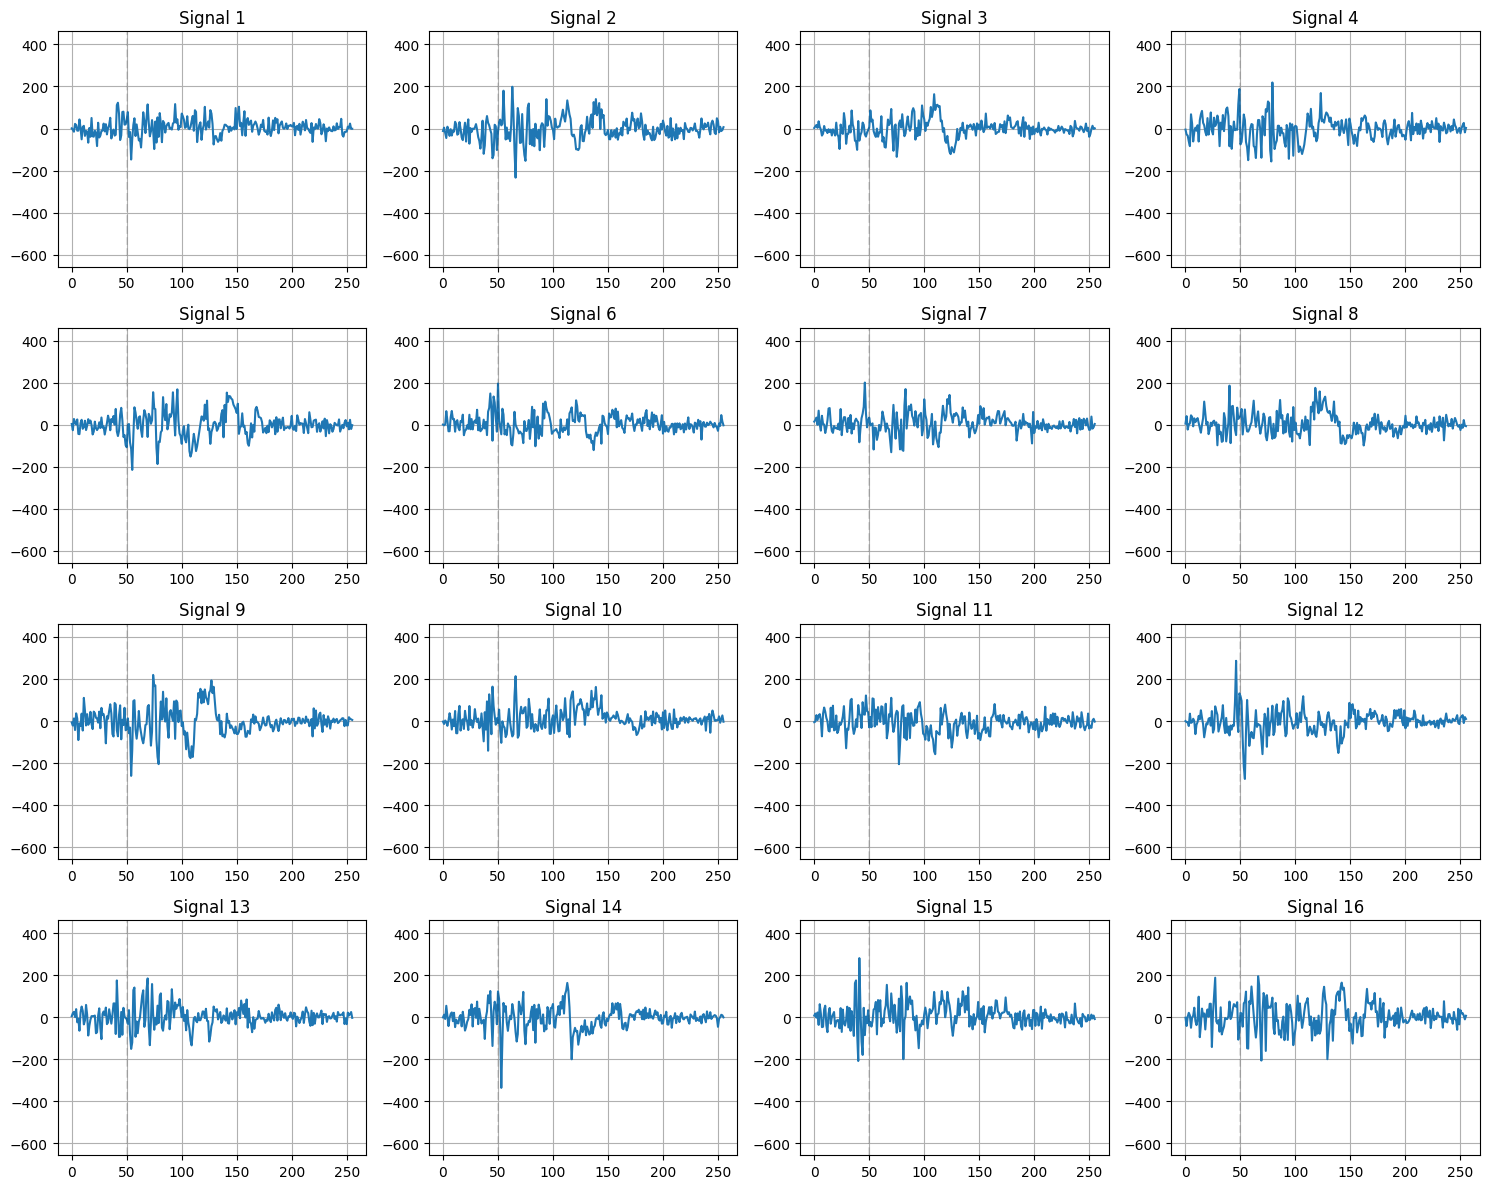

[1/32][0/188]	Loss_D: 1.0472	Loss_G: 0.9126	D(x): 0.3341	D(G(z)): 0.5750 / 0.5761
[1/32][50/188]	Loss_D: 1.1364	Loss_G: 1.0345	D(x): 0.3959	D(G(z)): 0.6024 / 0.6025
[1/32][100/188]	Loss_D: 0.9551	Loss_G: 1.0219	D(x): 0.2883	D(G(z)): 0.6076 / 0.6058
[1/32][150/188]	Loss_D: 1.0483	Loss_G: 1.1438	D(x): 0.3418	D(G(z)): 0.6241 / 0.6418
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000193
Epoch 1: SGD Generator lr 0.0000197 -> 0.0000193


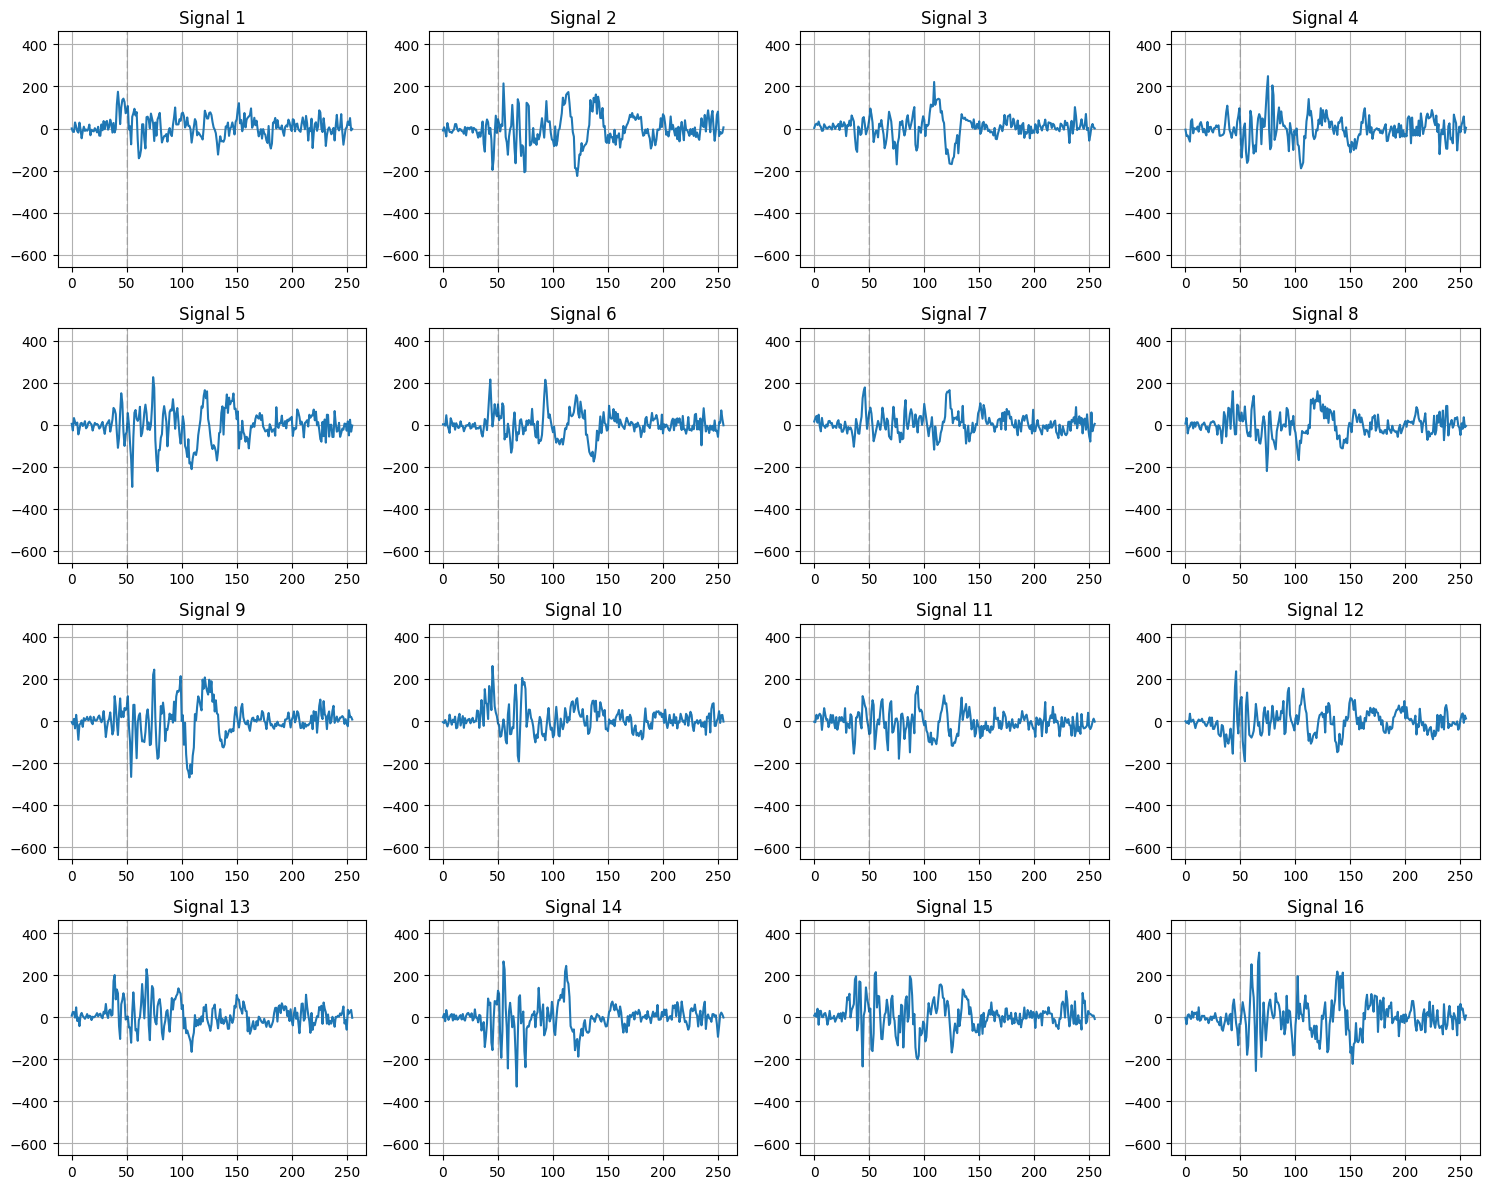

[2/32][0/188]	Loss_D: 0.9862	Loss_G: 1.1015	D(x): 0.3440	D(G(z)): 0.6705 / 0.6316
[2/32][50/188]	Loss_D: 0.8721	Loss_G: 1.4066	D(x): 0.2523	D(G(z)): 0.6639 / 0.6936
[2/32][100/188]	Loss_D: 0.8920	Loss_G: 1.6255	D(x): 0.3250	D(G(z)): 0.7280 / 0.7601
[2/32][150/188]	Loss_D: 1.0283	Loss_G: 1.1297	D(x): 0.2711	D(G(z)): 0.5954 / 0.6203
Epoch 2: SGD Discriminator lr 0.0000193 -> 0.0000190
Epoch 2: SGD Generator lr 0.0000193 -> 0.0000190


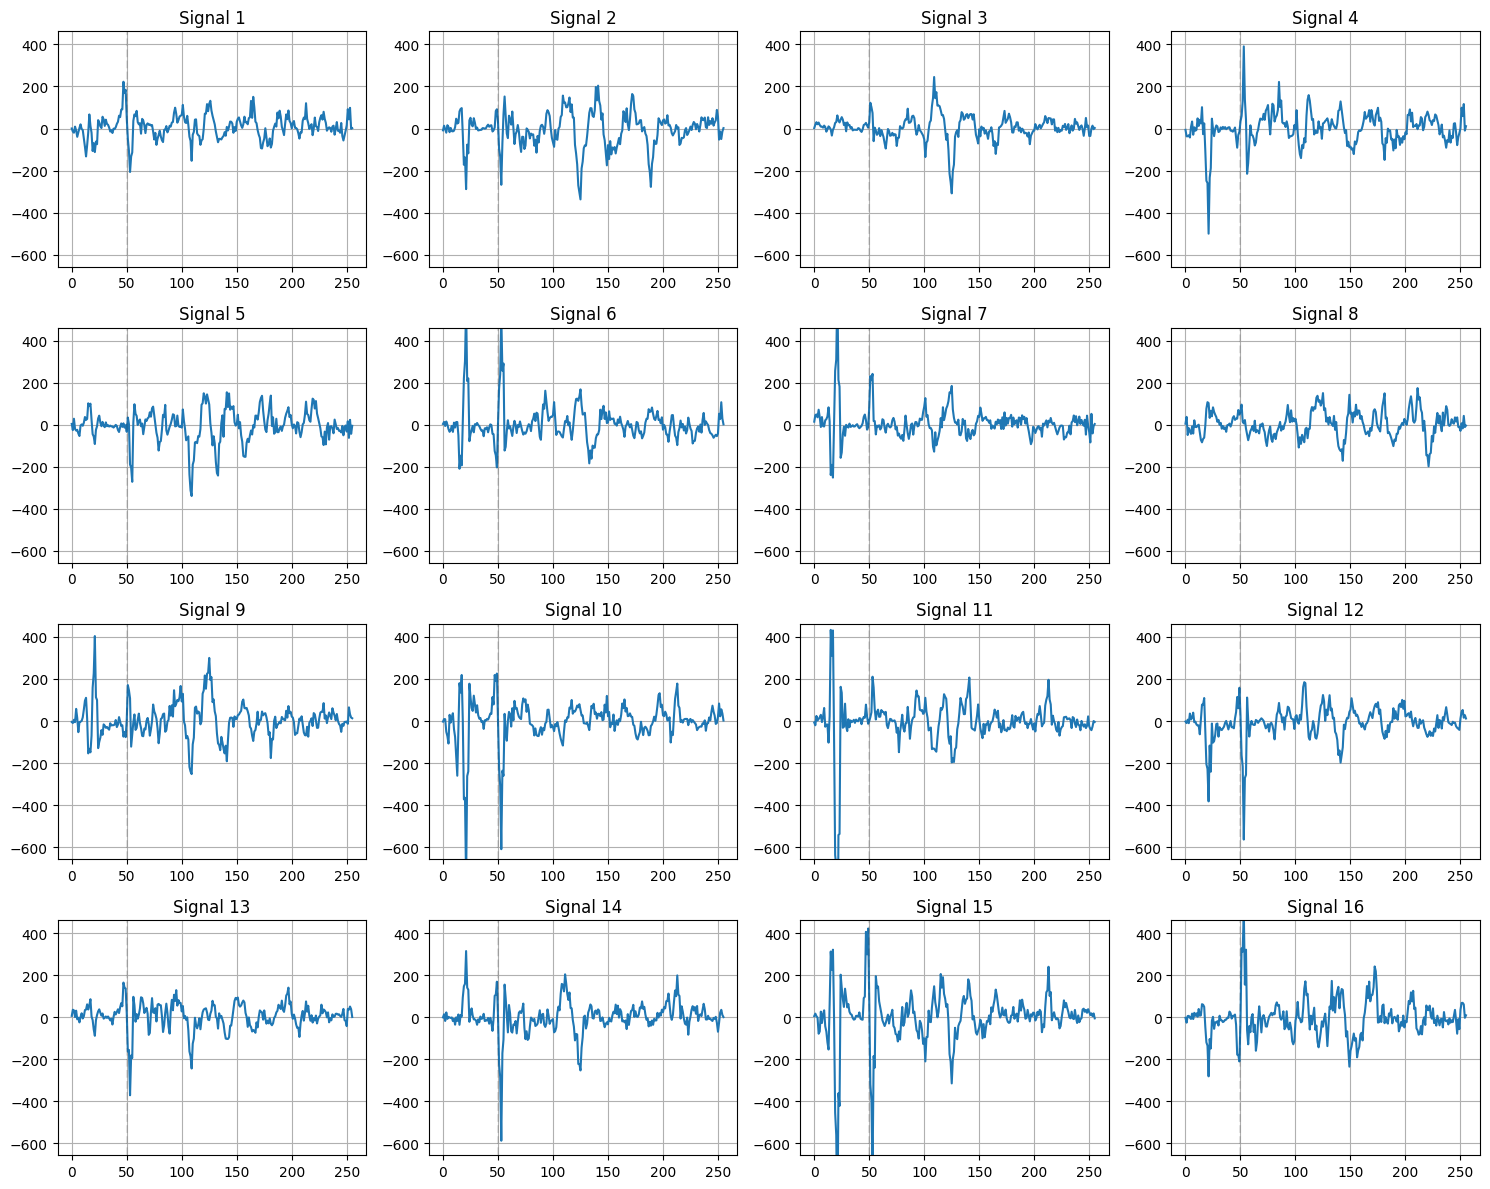

[3/32][0/188]	Loss_D: 0.8580	Loss_G: 1.5179	D(x): 0.2454	D(G(z)): 0.6745 / 0.7171
[3/32][50/188]	Loss_D: 0.7800	Loss_G: 1.3954	D(x): 0.1922	D(G(z)): 0.6503 / 0.6959
[3/32][100/188]	Loss_D: 0.7765	Loss_G: 1.3929	D(x): 0.2213	D(G(z)): 0.7219 / 0.6975
[3/32][150/188]	Loss_D: 0.7153	Loss_G: 1.5624	D(x): 0.2070	D(G(z)): 0.7110 / 0.7171
Epoch 3: SGD Discriminator lr 0.0000190 -> 0.0000187
Epoch 3: SGD Generator lr 0.0000190 -> 0.0000187


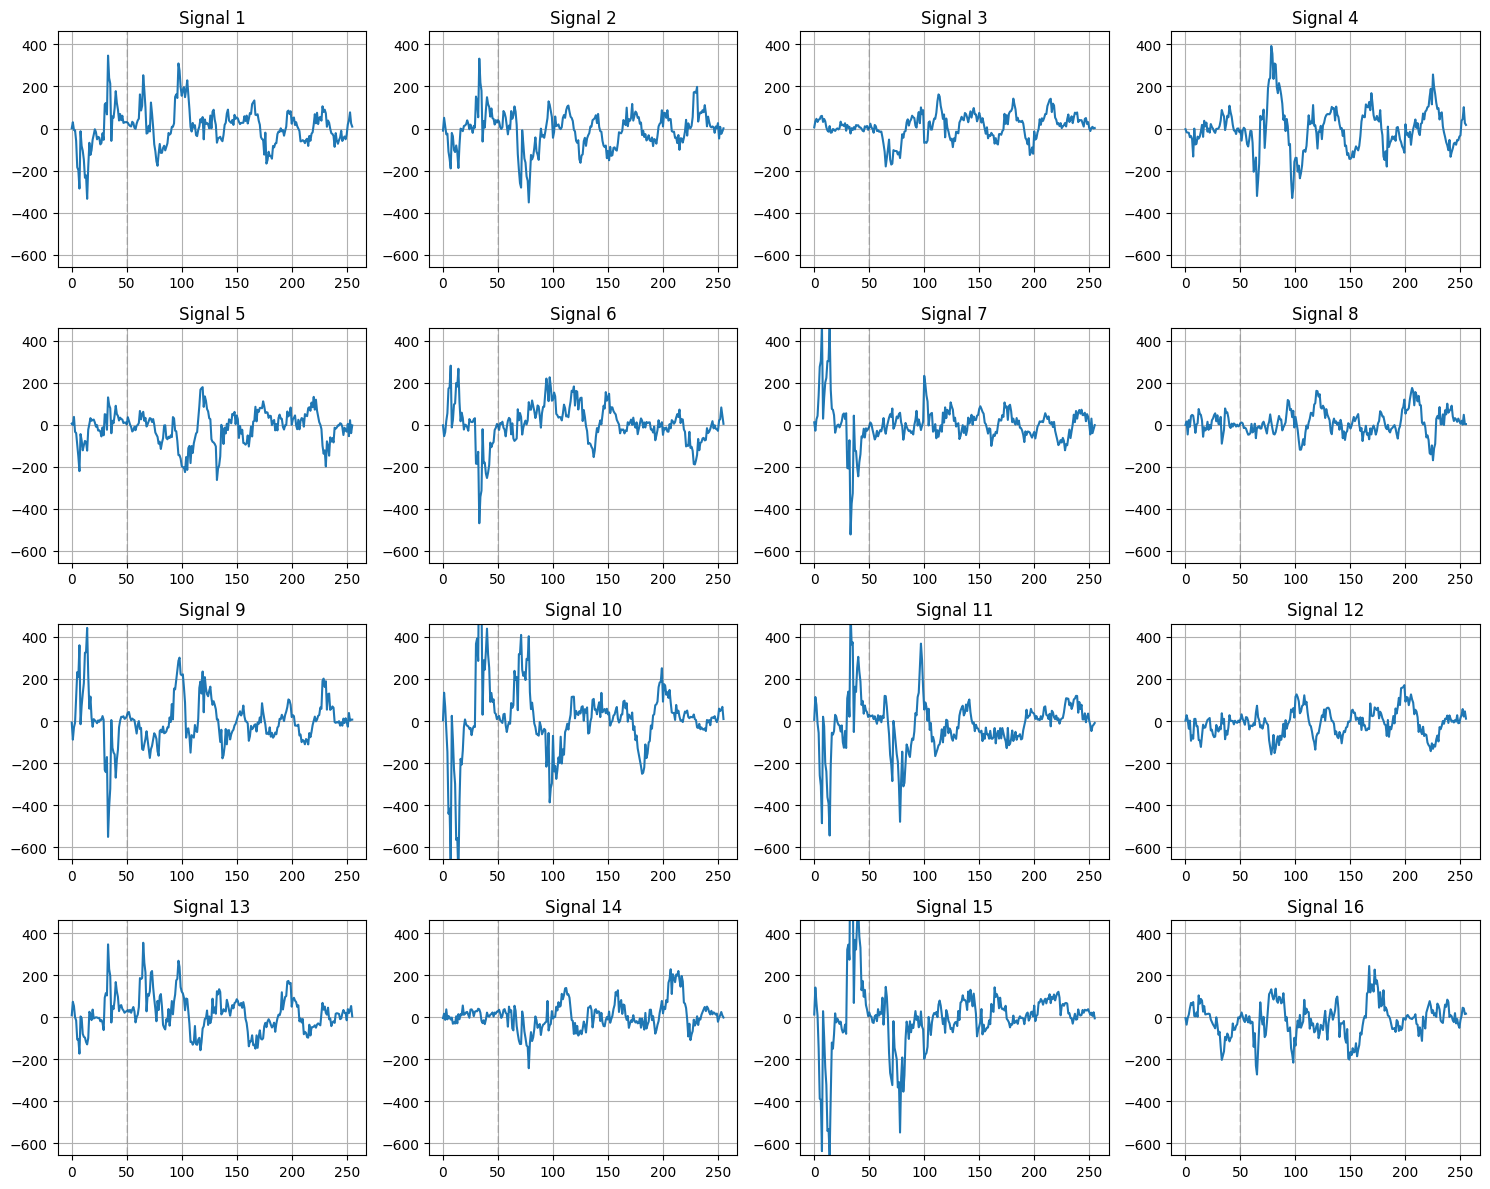

[4/32][0/188]	Loss_D: 0.8518	Loss_G: 0.9962	D(x): 0.2092	D(G(z)): 0.6539 / 0.5905
[4/32][50/188]	Loss_D: 0.7881	Loss_G: 1.5365	D(x): 0.1989	D(G(z)): 0.6712 / 0.7223
[4/32][100/188]	Loss_D: 0.8356	Loss_G: 1.4660	D(x): 0.2191	D(G(z)): 0.6733 / 0.7320
[4/32][150/188]	Loss_D: 0.8410	Loss_G: 1.7122	D(x): 0.2477	D(G(z)): 0.6726 / 0.7422
Epoch 4: SGD Discriminator lr 0.0000187 -> 0.0000183
Epoch 4: SGD Generator lr 0.0000187 -> 0.0000183


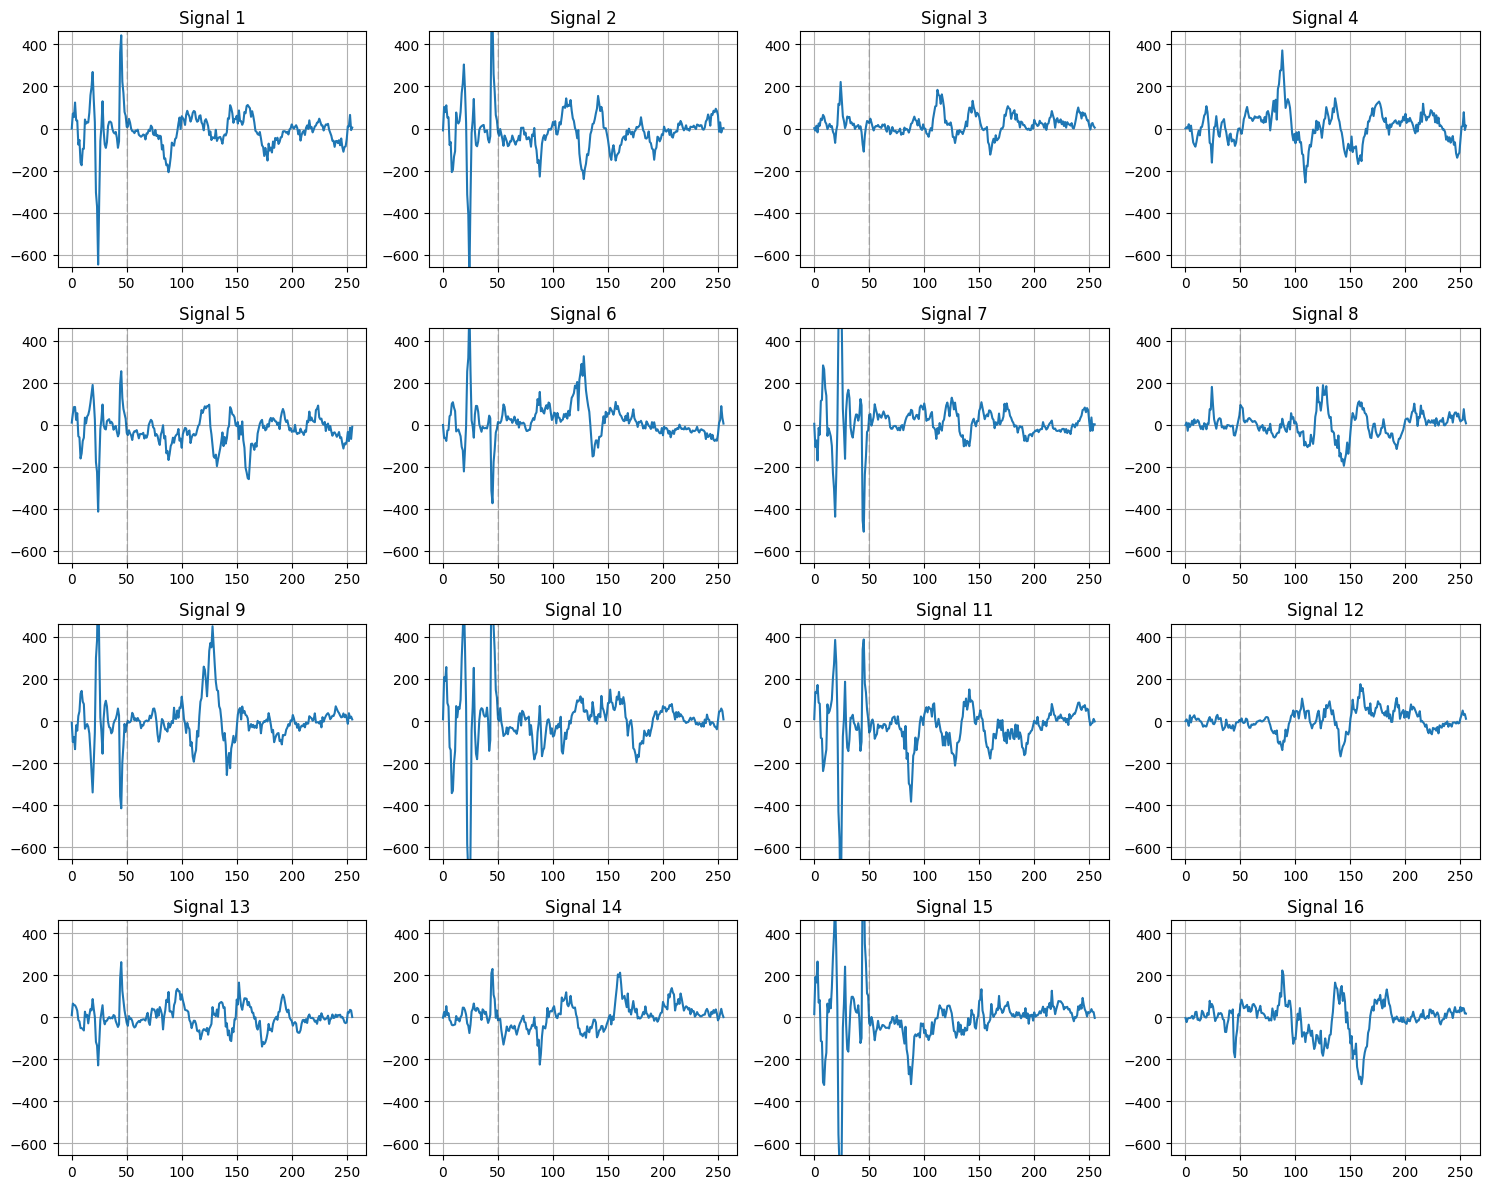

[5/32][0/188]	Loss_D: 0.8146	Loss_G: 1.2784	D(x): 0.2158	D(G(z)): 0.6677 / 0.6773
[5/32][50/188]	Loss_D: 0.7971	Loss_G: 2.0297	D(x): 0.1956	D(G(z)): 0.6951 / 0.8041
[5/32][100/188]	Loss_D: 0.7499	Loss_G: 1.3611	D(x): 0.1895	D(G(z)): 0.7092 / 0.6867
[5/32][150/188]	Loss_D: 0.6983	Loss_G: 1.3685	D(x): 0.1586	D(G(z)): 0.6992 / 0.6950
Epoch 5: SGD Discriminator lr 0.0000183 -> 0.0000180
Epoch 5: SGD Generator lr 0.0000183 -> 0.0000180


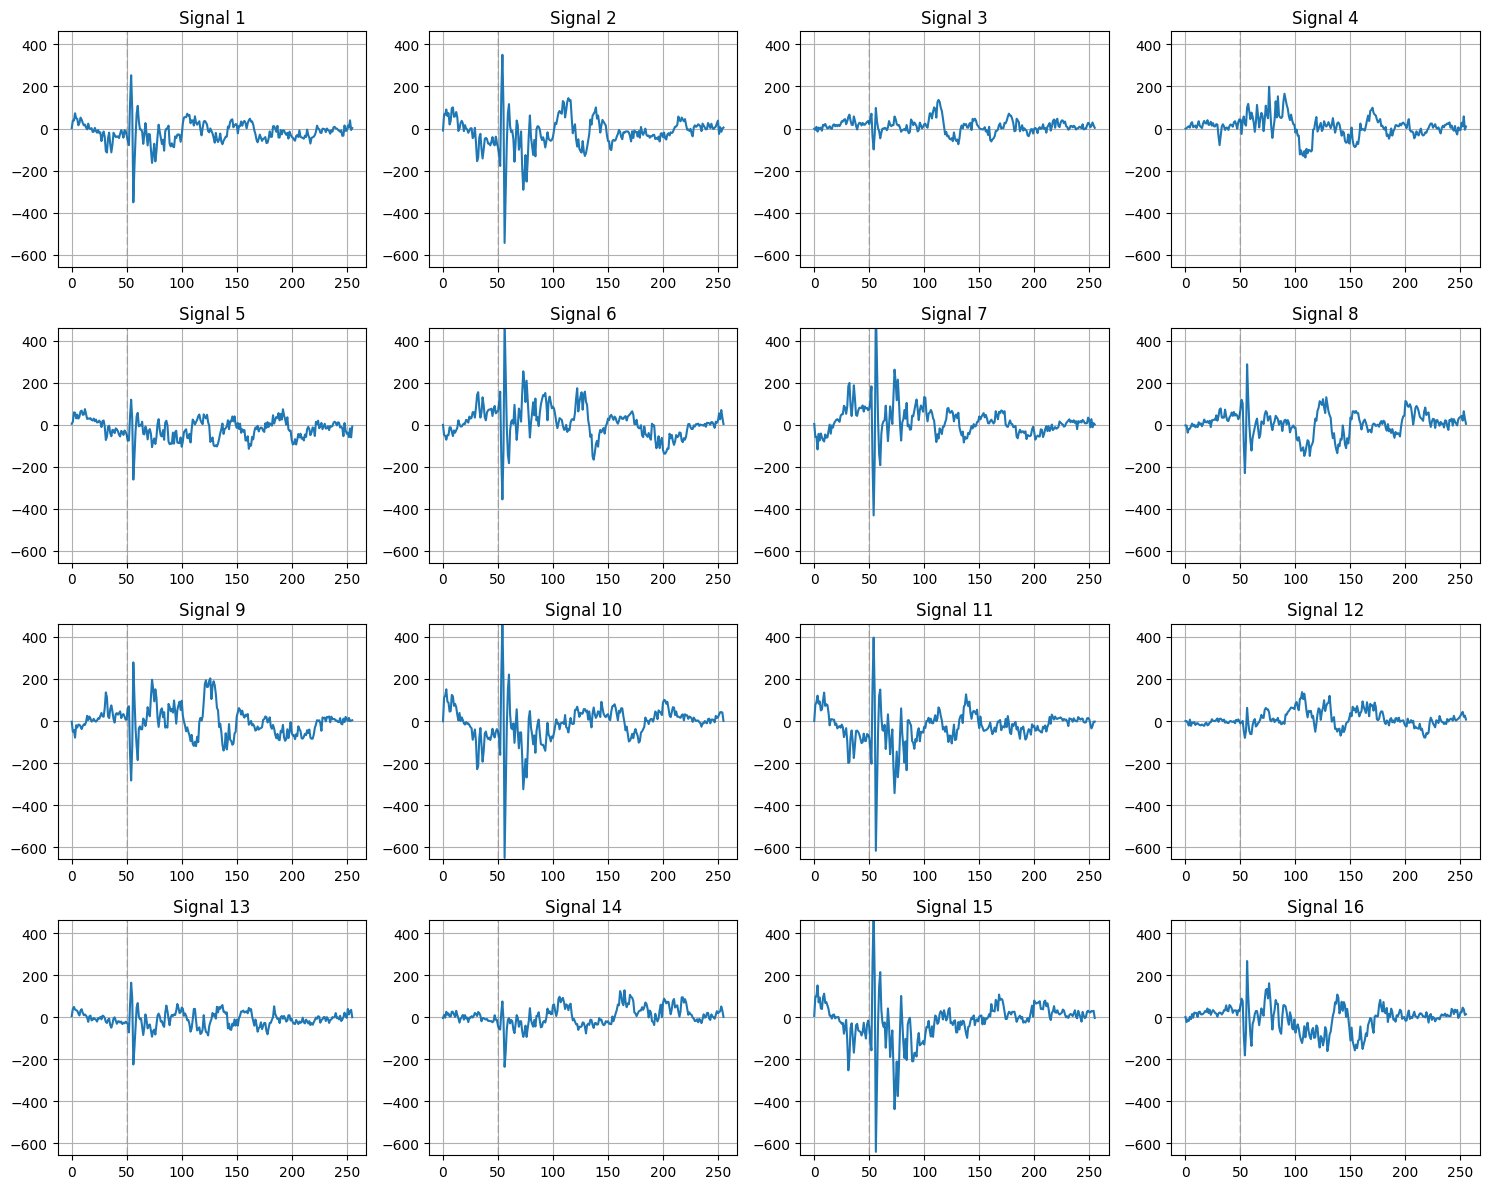

[6/32][0/188]	Loss_D: 0.7521	Loss_G: 1.6219	D(x): 0.1776	D(G(z)): 0.6622 / 0.7665
[6/32][50/188]	Loss_D: 0.8587	Loss_G: 1.6638	D(x): 0.2456	D(G(z)): 0.7297 / 0.7515
[6/32][100/188]	Loss_D: 0.8502	Loss_G: 1.7623	D(x): 0.2411	D(G(z)): 0.6814 / 0.7253
[6/32][150/188]	Loss_D: 0.8021	Loss_G: 2.0111	D(x): 0.2134	D(G(z)): 0.8497 / 0.7835
Epoch 6: SGD Discriminator lr 0.0000180 -> 0.0000177
Epoch 6: SGD Generator lr 0.0000180 -> 0.0000177


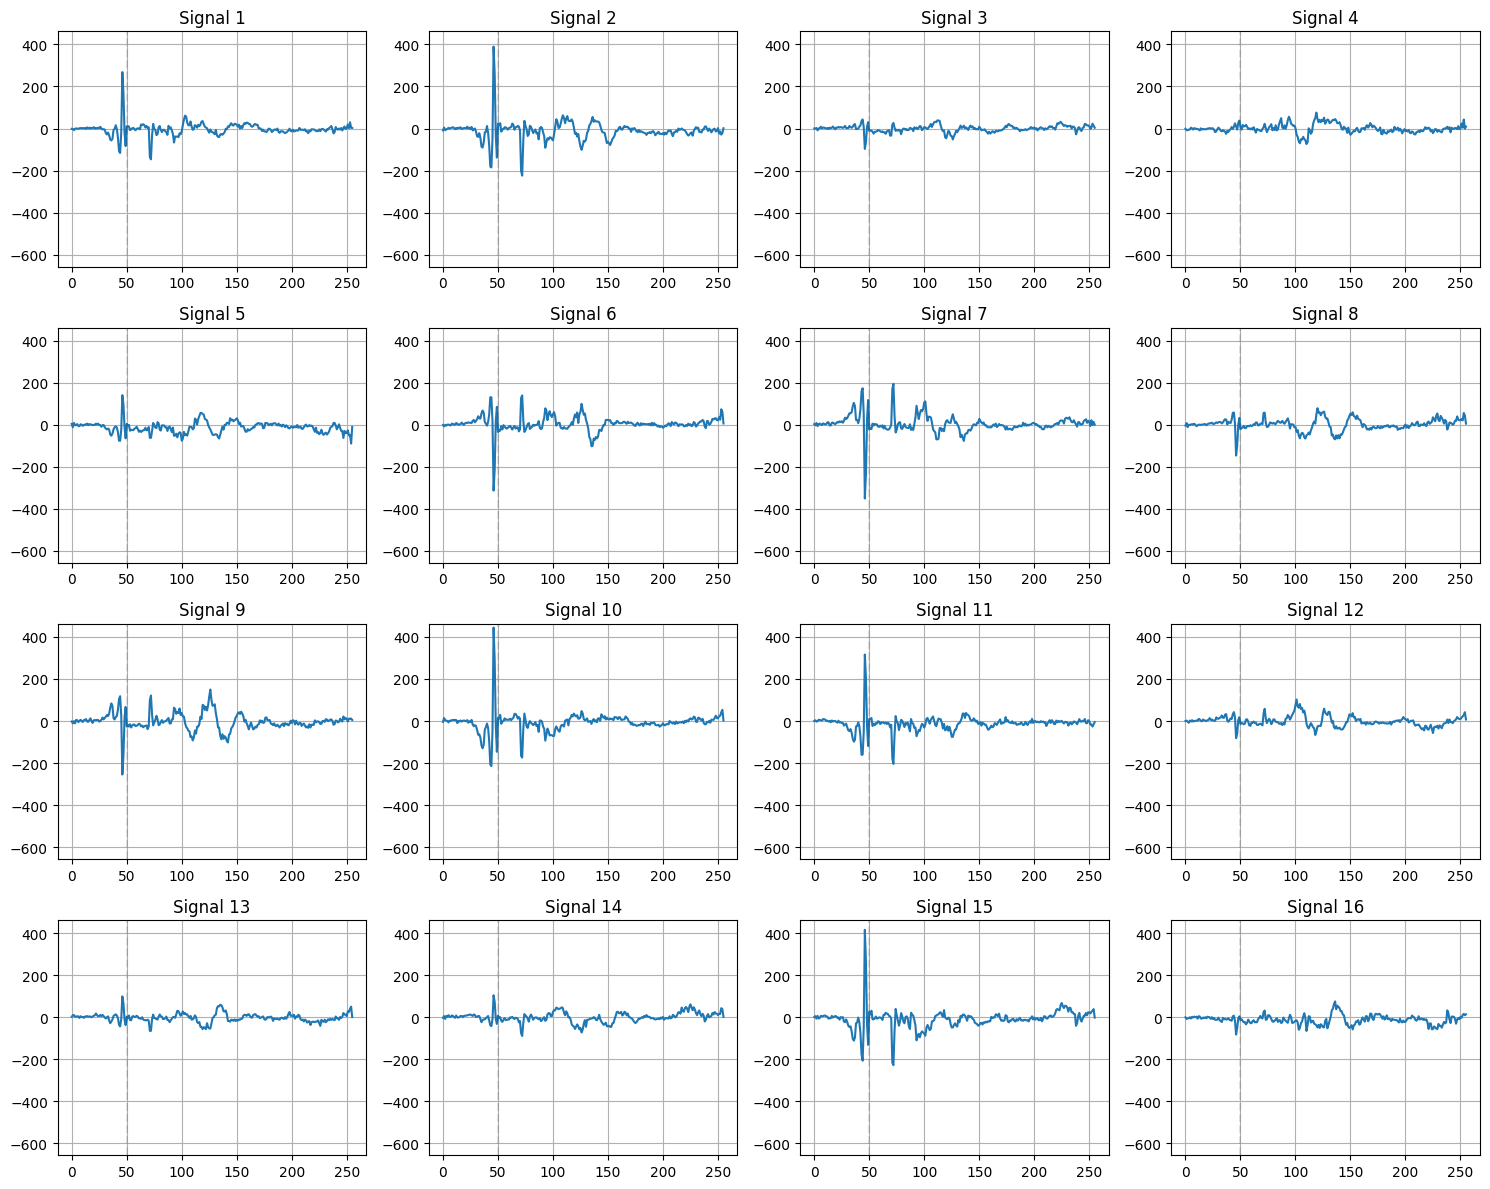

[7/32][0/188]	Loss_D: 0.8880	Loss_G: 1.3567	D(x): 0.1940	D(G(z)): 0.6093 / 0.6905
[7/32][50/188]	Loss_D: 0.7662	Loss_G: 1.2018	D(x): 0.1338	D(G(z)): 0.6165 / 0.6394
[7/32][100/188]	Loss_D: 0.7641	Loss_G: 1.7365	D(x): 0.1553	D(G(z)): 0.6993 / 0.7448
[7/32][150/188]	Loss_D: 0.8251	Loss_G: 1.7183	D(x): 0.2447	D(G(z)): 0.6973 / 0.7587
Epoch 7: SGD Discriminator lr 0.0000177 -> 0.0000173
Epoch 7: SGD Generator lr 0.0000177 -> 0.0000173


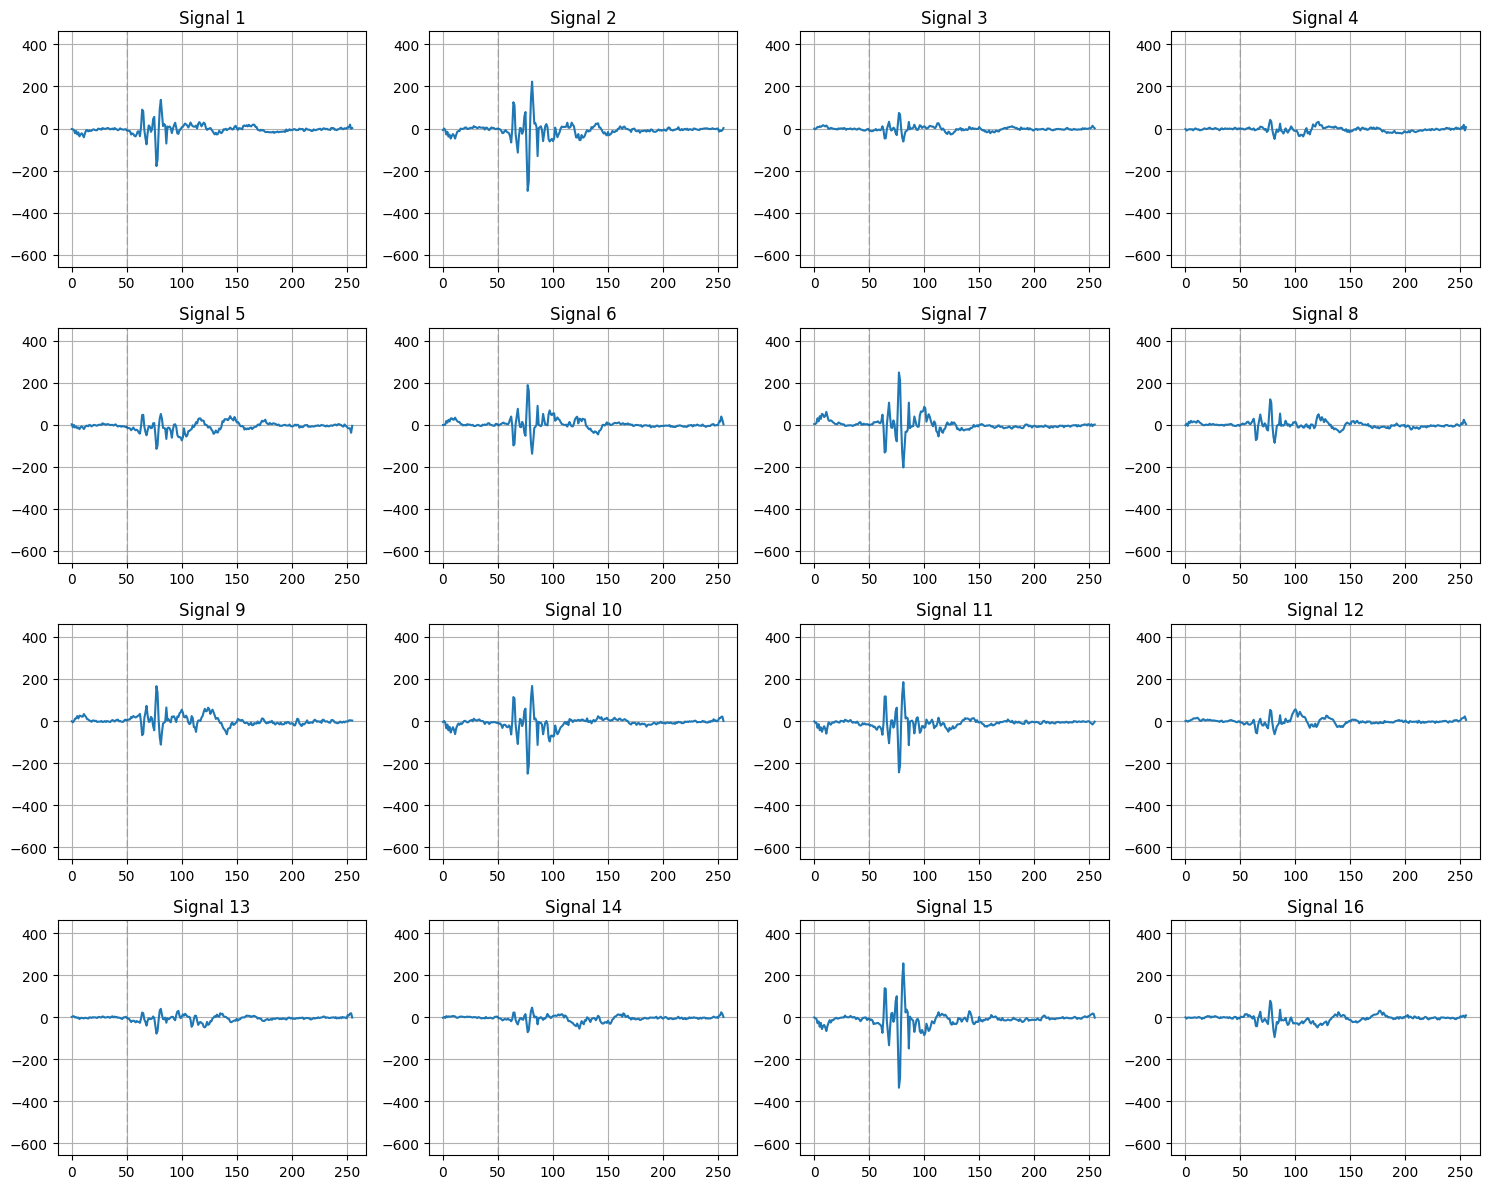

[8/32][0/188]	Loss_D: 0.8876	Loss_G: 1.6258	D(x): 0.2285	D(G(z)): 0.8128 / 0.7336
[8/32][50/188]	Loss_D: 0.6706	Loss_G: 1.7542	D(x): 0.1458	D(G(z)): 0.7401 / 0.7594
[8/32][100/188]	Loss_D: 0.8131	Loss_G: 1.3367	D(x): 0.2336	D(G(z)): 0.6791 / 0.6746
[8/32][150/188]	Loss_D: 0.6191	Loss_G: 1.5264	D(x): 0.1318	D(G(z)): 0.7651 / 0.7143
Epoch 8: SGD Discriminator lr 0.0000173 -> 0.0000170
Epoch 8: SGD Generator lr 0.0000173 -> 0.0000170


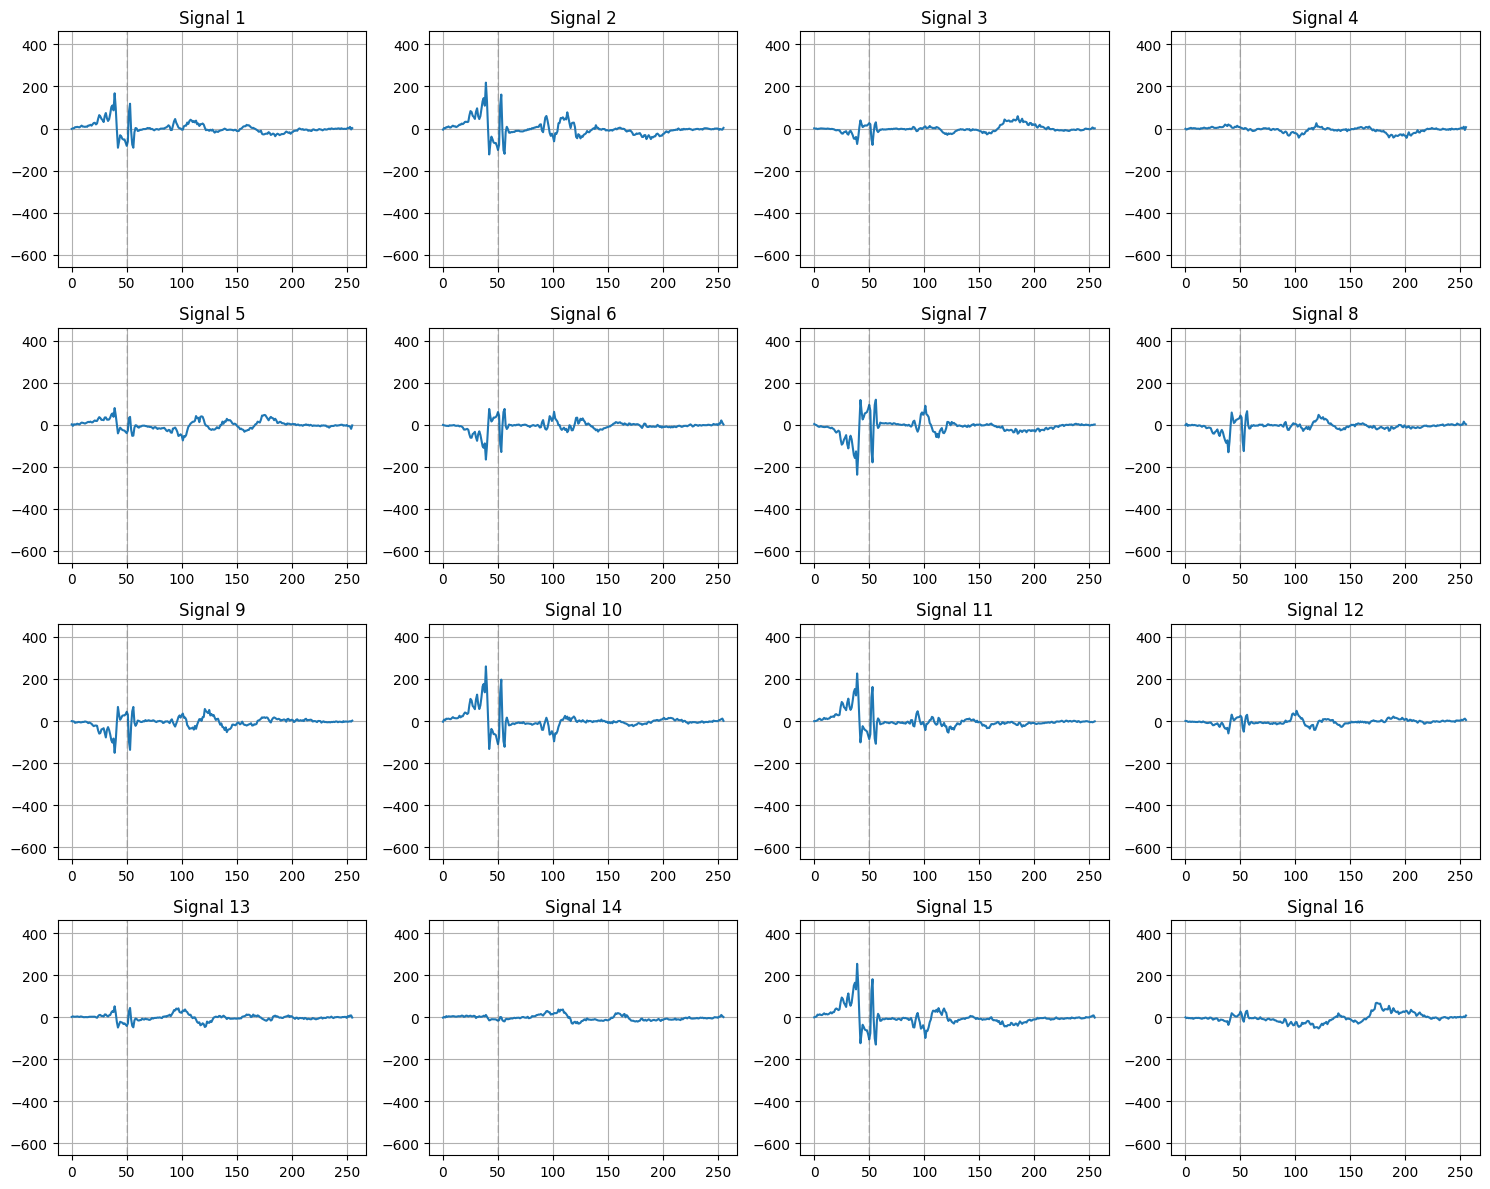

[9/32][0/188]	Loss_D: 1.0362	Loss_G: 1.1520	D(x): 0.2592	D(G(z)): 0.5453 / 0.6330
[9/32][50/188]	Loss_D: 0.9054	Loss_G: 1.3235	D(x): 0.1649	D(G(z)): 0.5819 / 0.6663
[9/32][100/188]	Loss_D: 0.7950	Loss_G: 1.9116	D(x): 0.1936	D(G(z)): 0.7119 / 0.8050
[9/32][150/188]	Loss_D: 0.7005	Loss_G: 1.6026	D(x): 0.1144	D(G(z)): 0.7435 / 0.7355
Epoch 9: SGD Discriminator lr 0.0000170 -> 0.0000167
Epoch 9: SGD Generator lr 0.0000170 -> 0.0000167


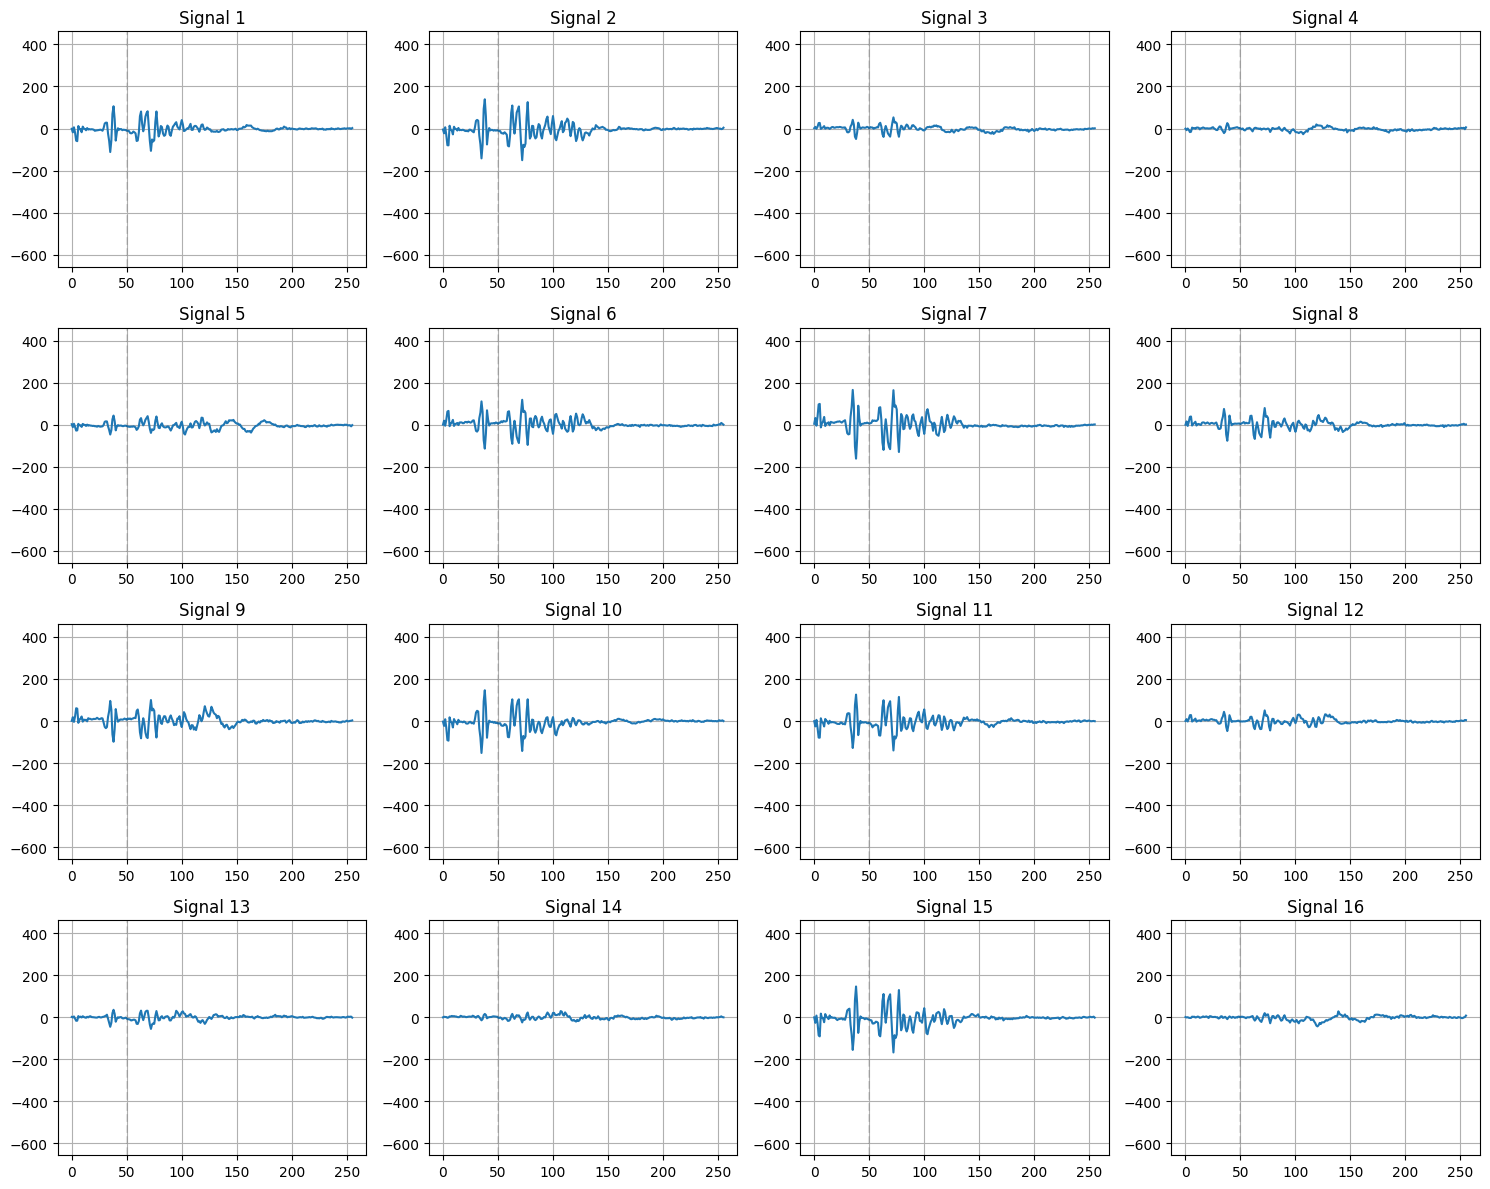

[10/32][0/188]	Loss_D: 0.8105	Loss_G: 1.0634	D(x): 0.2068	D(G(z)): 0.7417 / 0.6036
[10/32][50/188]	Loss_D: 0.6359	Loss_G: 1.5676	D(x): 0.1292	D(G(z)): 0.7672 / 0.7232
[10/32][100/188]	Loss_D: 0.7853	Loss_G: 1.6250	D(x): 0.2047	D(G(z)): 0.7064 / 0.7557
[10/32][150/188]	Loss_D: 0.7784	Loss_G: 1.3857	D(x): 0.2182	D(G(z)): 0.7025 / 0.6879
Epoch 10: SGD Discriminator lr 0.0000167 -> 0.0000163
Epoch 10: SGD Generator lr 0.0000167 -> 0.0000163


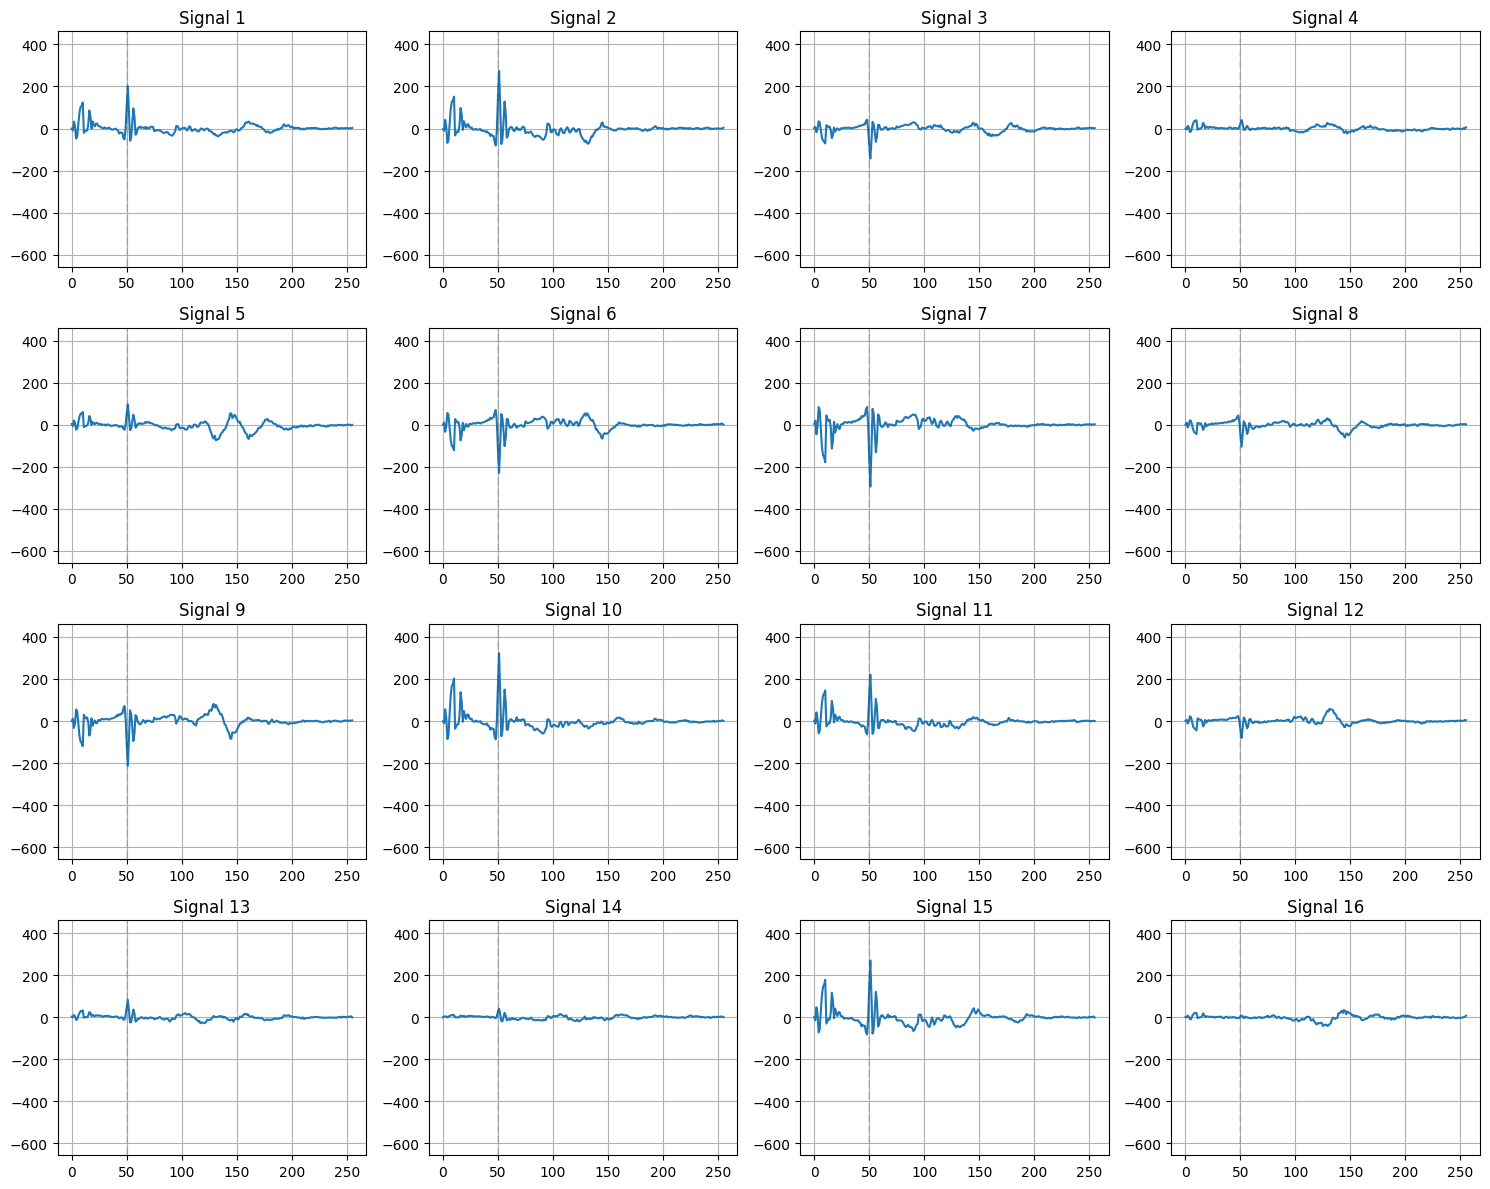

[11/32][0/188]	Loss_D: 0.8241	Loss_G: 1.2966	D(x): 0.1867	D(G(z)): 0.6485 / 0.6566
[11/32][50/188]	Loss_D: 0.7027	Loss_G: 1.7769	D(x): 0.1418	D(G(z)): 0.7910 / 0.7711
[11/32][100/188]	Loss_D: 0.8934	Loss_G: 1.6230	D(x): 0.2810	D(G(z)): 0.6729 / 0.7365
[11/32][150/188]	Loss_D: 0.8410	Loss_G: 1.6327	D(x): 0.2547	D(G(z)): 0.7259 / 0.7557
Epoch 11: SGD Discriminator lr 0.0000163 -> 0.0000160
Epoch 11: SGD Generator lr 0.0000163 -> 0.0000160


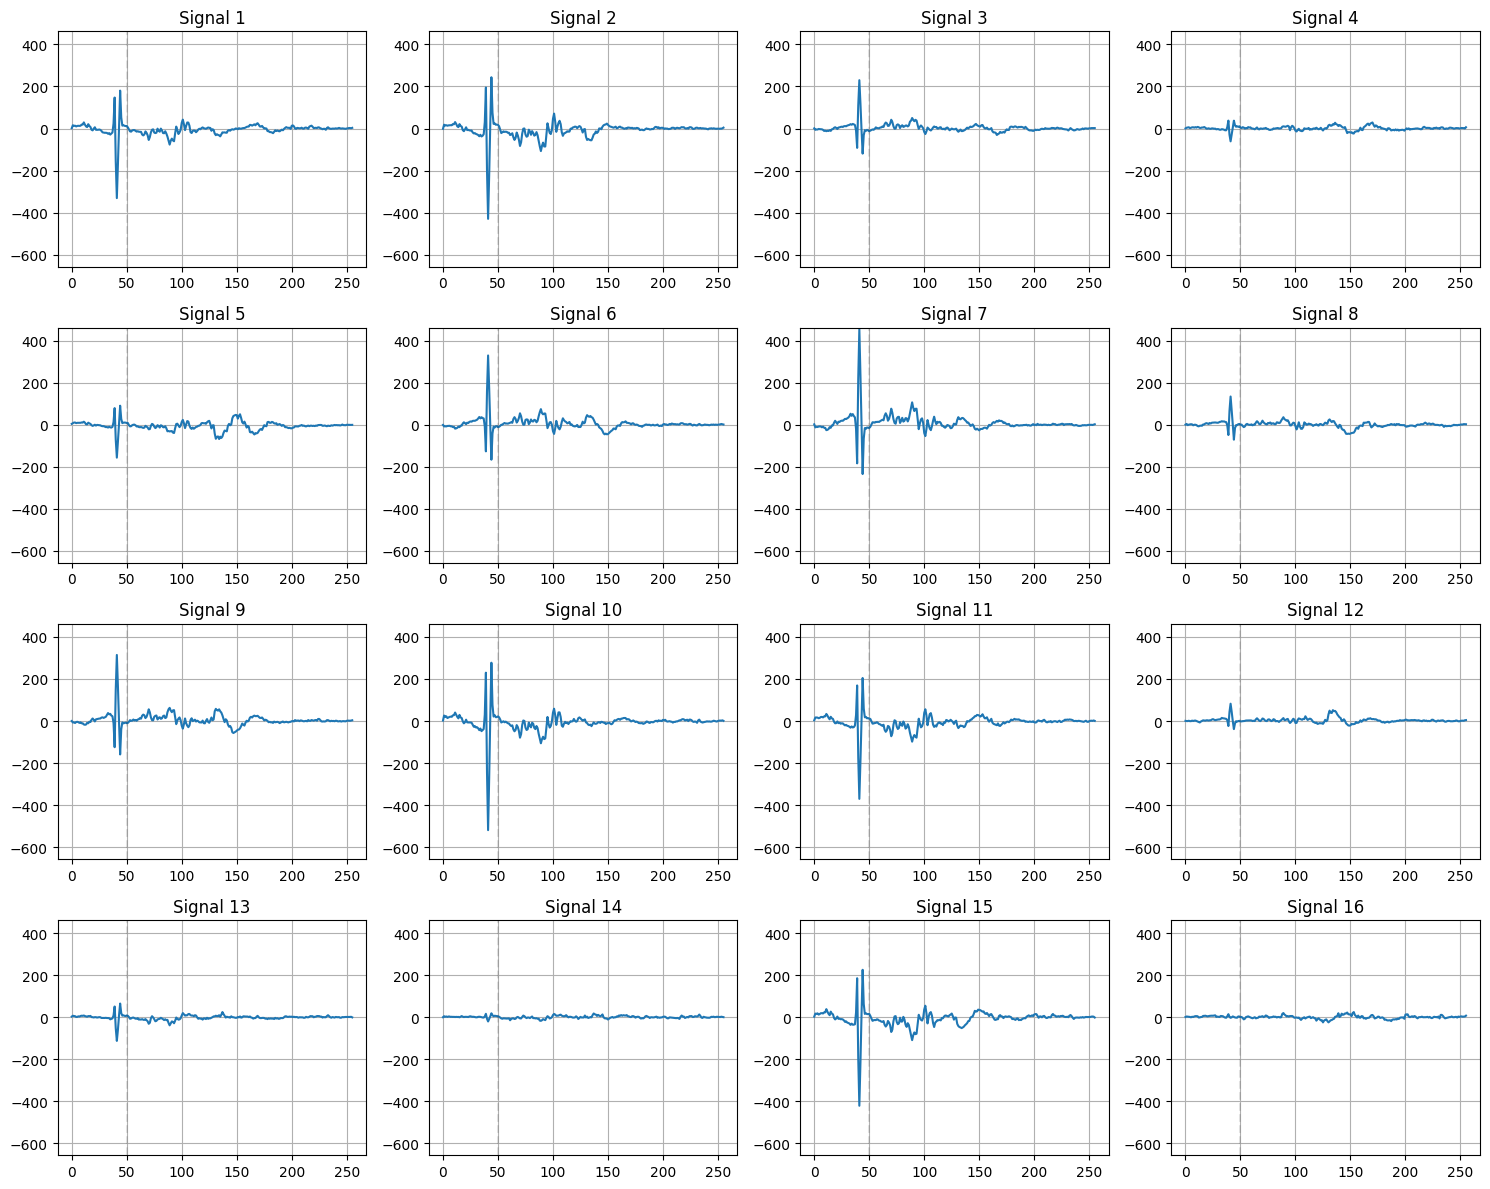

[12/32][0/188]	Loss_D: 0.6773	Loss_G: 1.1860	D(x): 0.1188	D(G(z)): 0.6858 / 0.6525
[12/32][50/188]	Loss_D: 0.6677	Loss_G: 1.7472	D(x): 0.0780	D(G(z)): 0.7068 / 0.7401
[12/32][100/188]	Loss_D: 0.7053	Loss_G: 1.2477	D(x): 0.1017	D(G(z)): 0.6478 / 0.6545
[12/32][150/188]	Loss_D: 0.6568	Loss_G: 1.6946	D(x): 0.0894	D(G(z)): 0.7039 / 0.7459
Epoch 12: SGD Discriminator lr 0.0000160 -> 0.0000157
Epoch 12: SGD Generator lr 0.0000160 -> 0.0000157


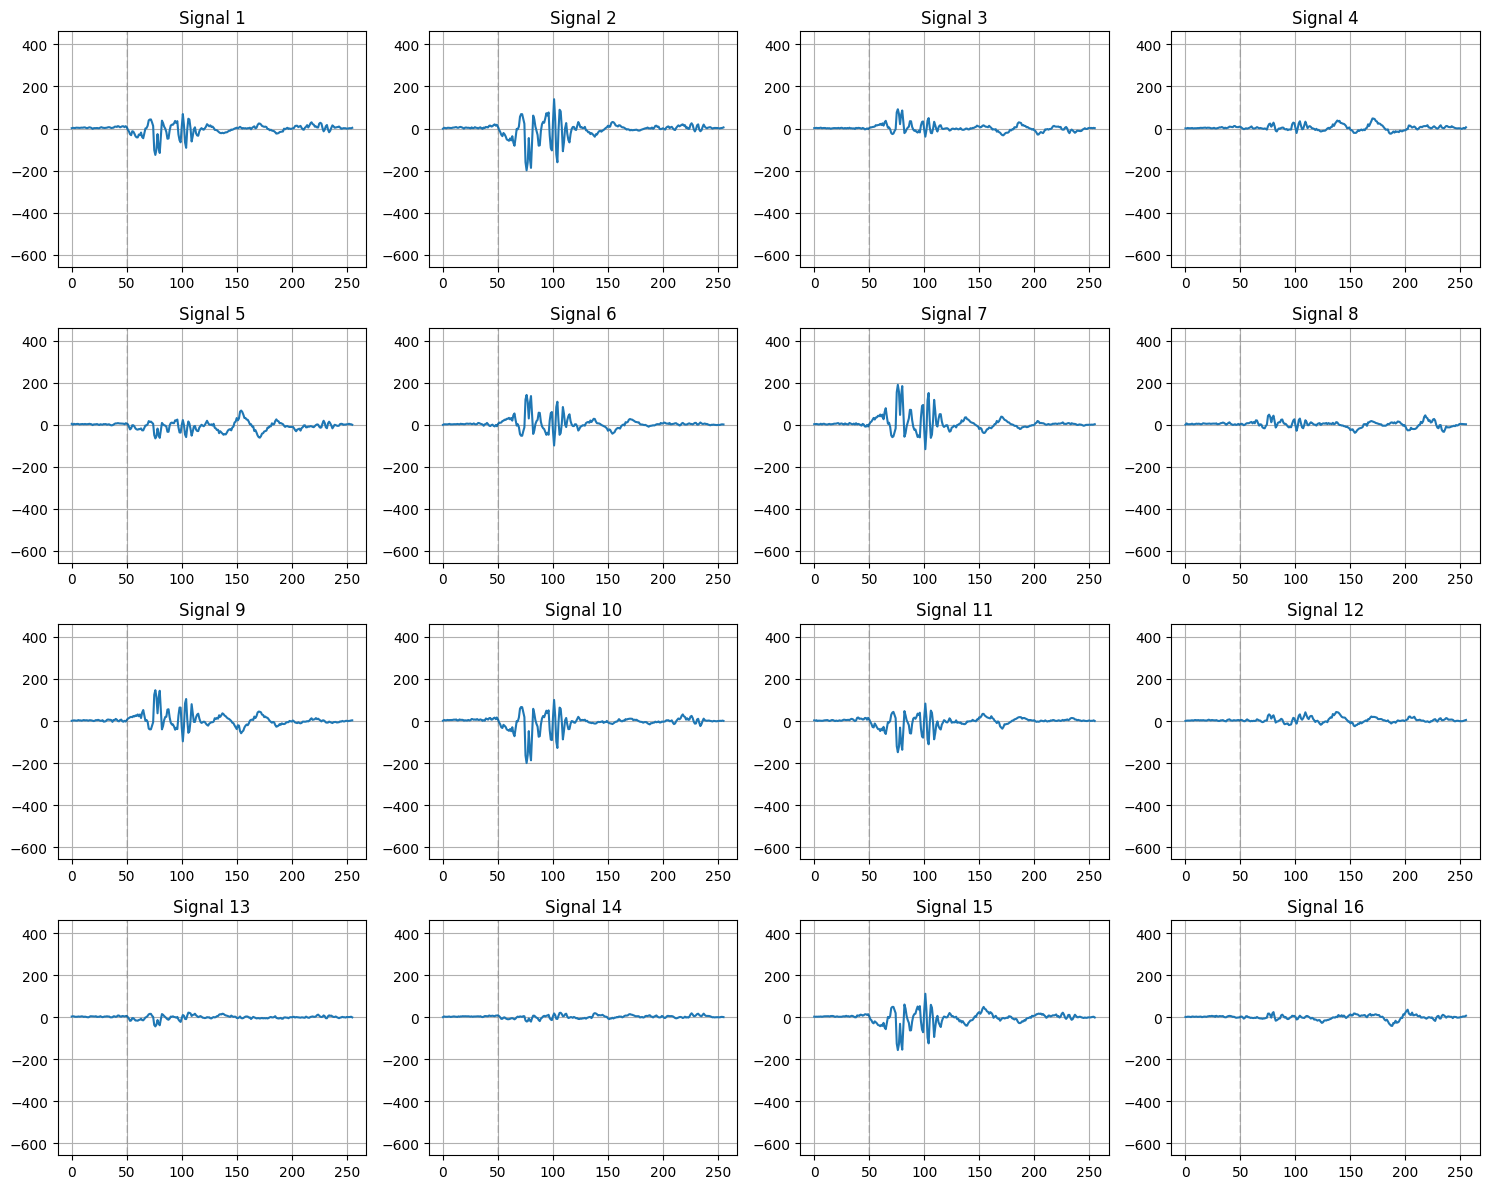

[13/32][0/188]	Loss_D: 0.6965	Loss_G: 1.6662	D(x): 0.1451	D(G(z)): 0.7441 / 0.7468
[13/32][50/188]	Loss_D: 0.6992	Loss_G: 2.0070	D(x): 0.1923	D(G(z)): 0.7831 / 0.7906
[13/32][100/188]	Loss_D: 0.7663	Loss_G: 1.8871	D(x): 0.1642	D(G(z)): 0.7246 / 0.7750
[13/32][150/188]	Loss_D: 0.6781	Loss_G: 1.7110	D(x): 0.1335	D(G(z)): 0.7226 / 0.7378
Epoch 13: SGD Discriminator lr 0.0000157 -> 0.0000153
Epoch 13: SGD Generator lr 0.0000157 -> 0.0000153


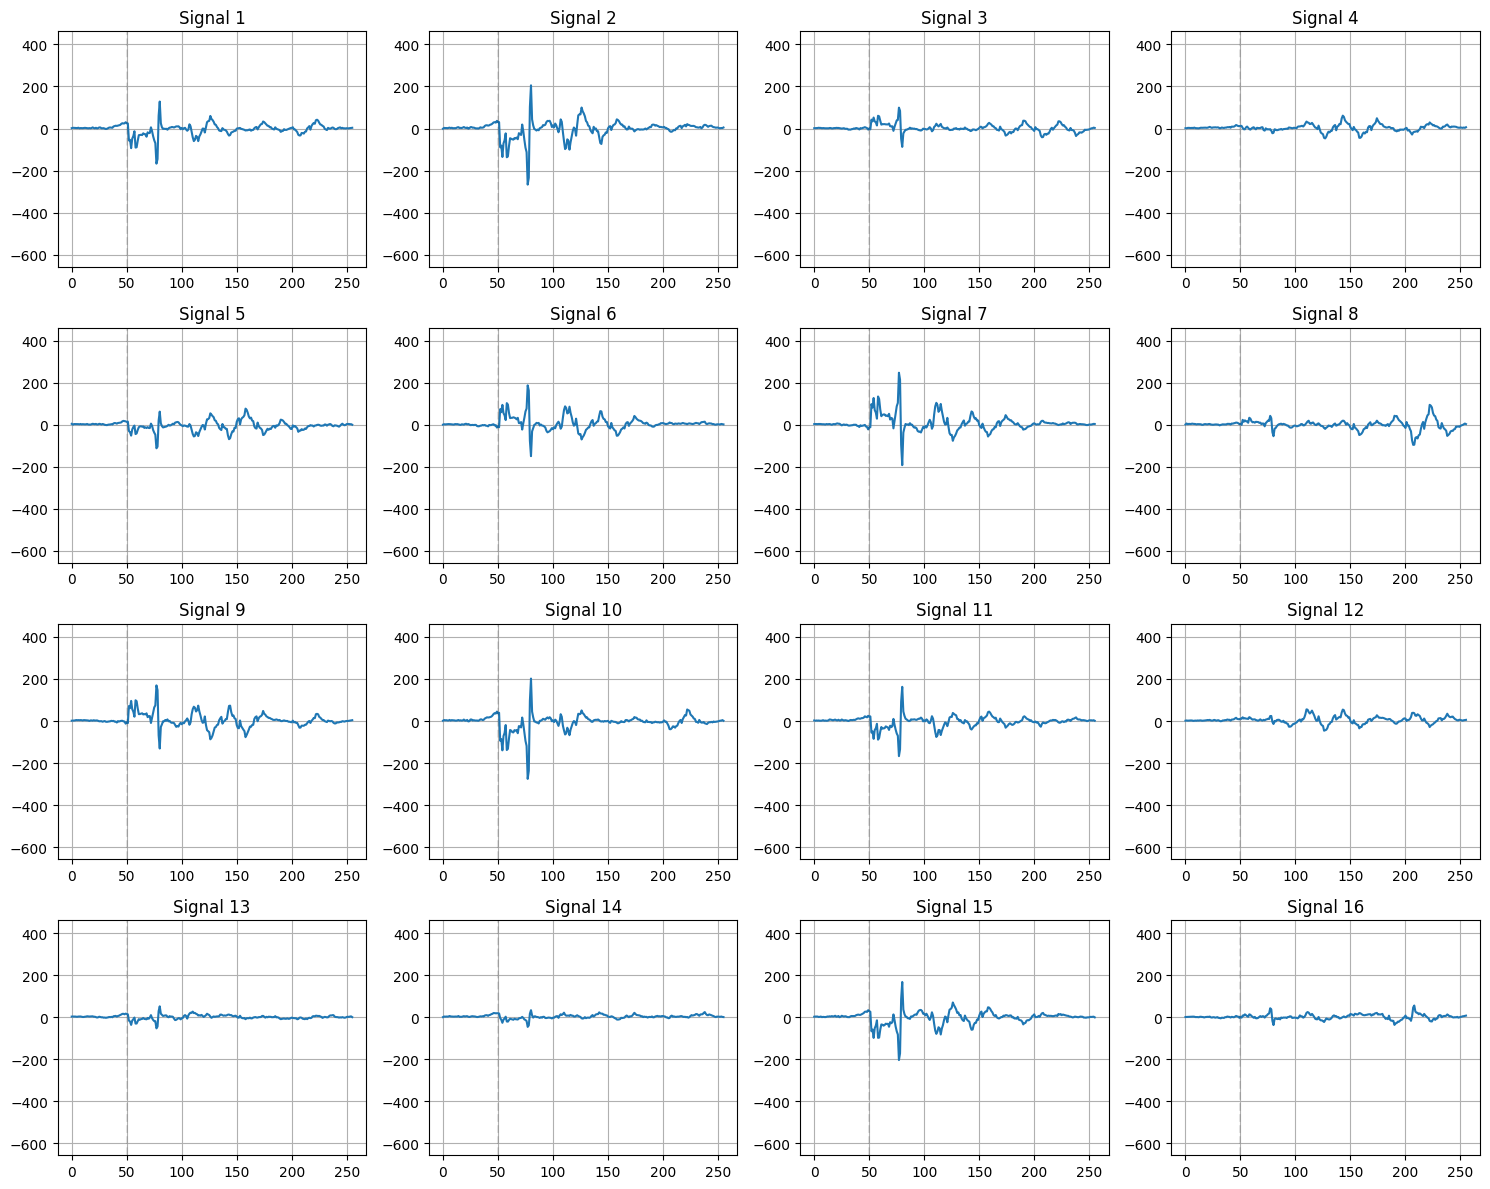

[14/32][0/188]	Loss_D: 0.6855	Loss_G: 2.7722	D(x): 0.1828	D(G(z)): 0.8542 / 0.8453
[14/32][50/188]	Loss_D: 0.6930	Loss_G: 2.5181	D(x): 0.1976	D(G(z)): 0.8604 / 0.8730
[14/32][100/188]	Loss_D: 0.7004	Loss_G: 1.6129	D(x): 0.1345	D(G(z)): 0.6910 / 0.7560
[14/32][150/188]	Loss_D: 0.7244	Loss_G: 1.6855	D(x): 0.1871	D(G(z)): 0.7389 / 0.7315
Epoch 14: SGD Discriminator lr 0.0000153 -> 0.0000150
Epoch 14: SGD Generator lr 0.0000153 -> 0.0000150


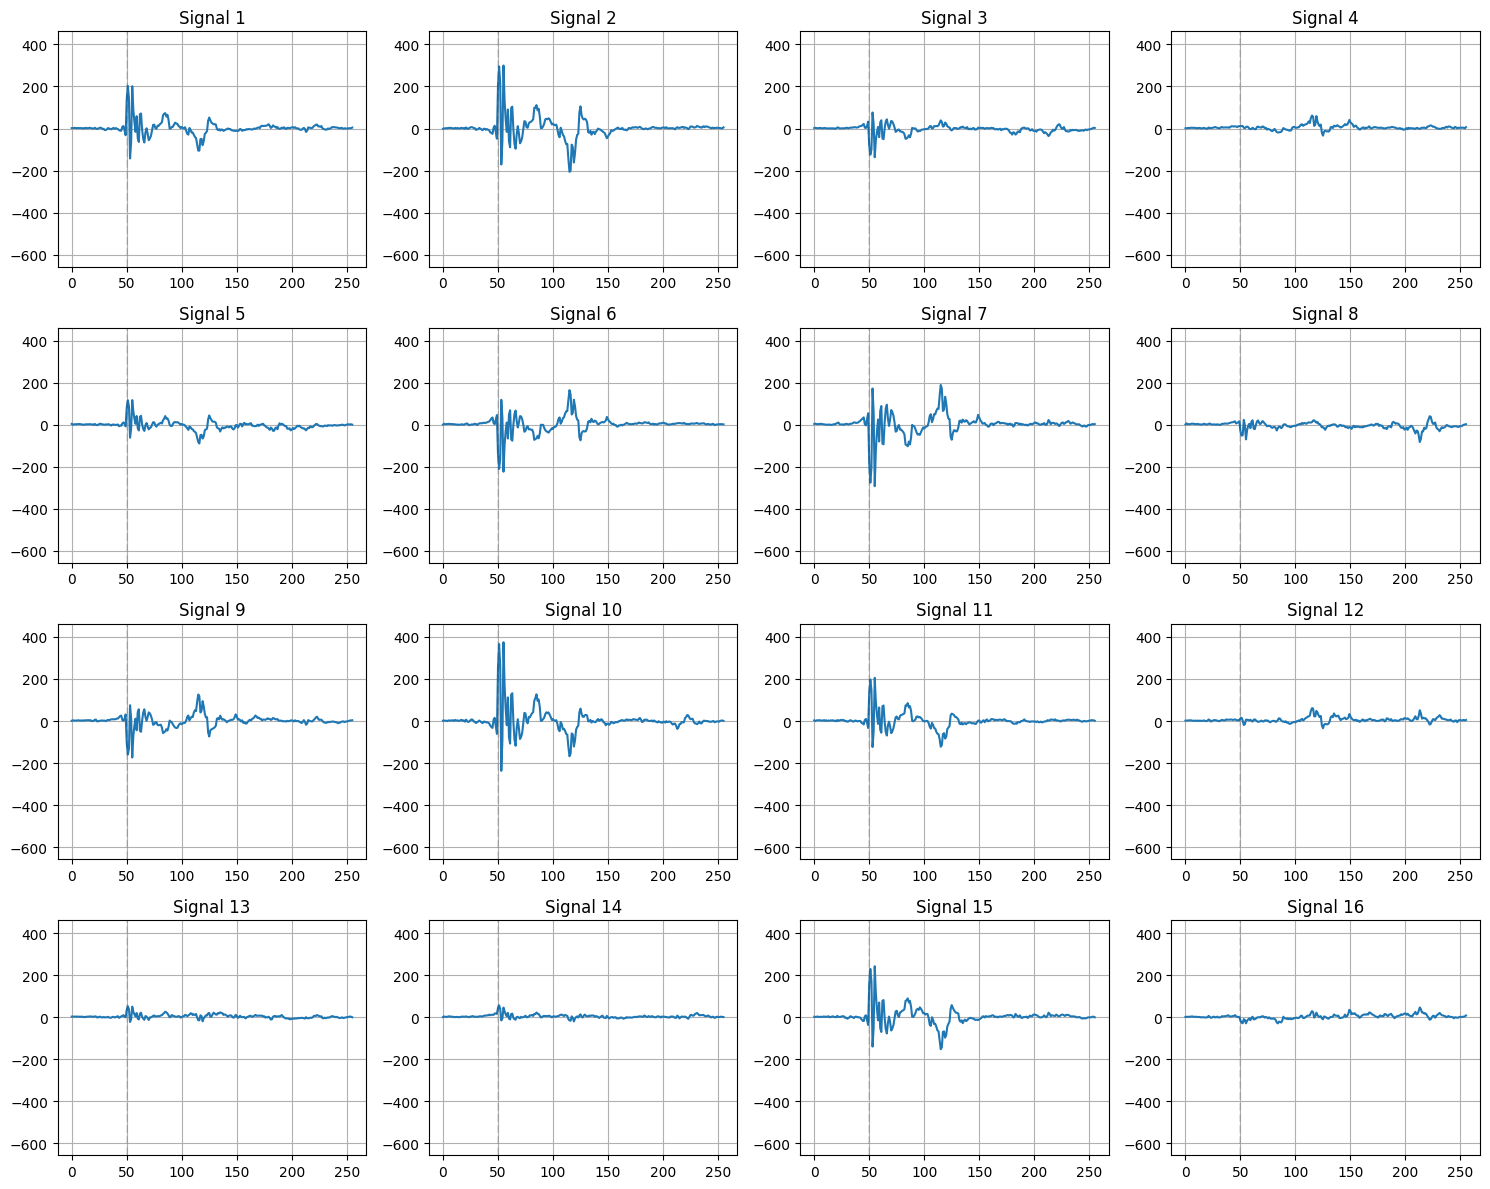

[15/32][0/188]	Loss_D: 0.6046	Loss_G: 1.7362	D(x): 0.1111	D(G(z)): 0.8166 / 0.7487
[15/32][50/188]	Loss_D: 0.7241	Loss_G: 2.0327	D(x): 0.1637	D(G(z)): 0.7029 / 0.7737
[15/32][100/188]	Loss_D: 0.5744	Loss_G: 1.9554	D(x): 0.1149	D(G(z)): 0.8245 / 0.7658
[15/32][150/188]	Loss_D: 0.5924	Loss_G: 2.4020	D(x): 0.0428	D(G(z)): 0.8453 / 0.8579
Epoch 15: SGD Discriminator lr 0.0000150 -> 0.0000147
Epoch 15: SGD Generator lr 0.0000150 -> 0.0000147


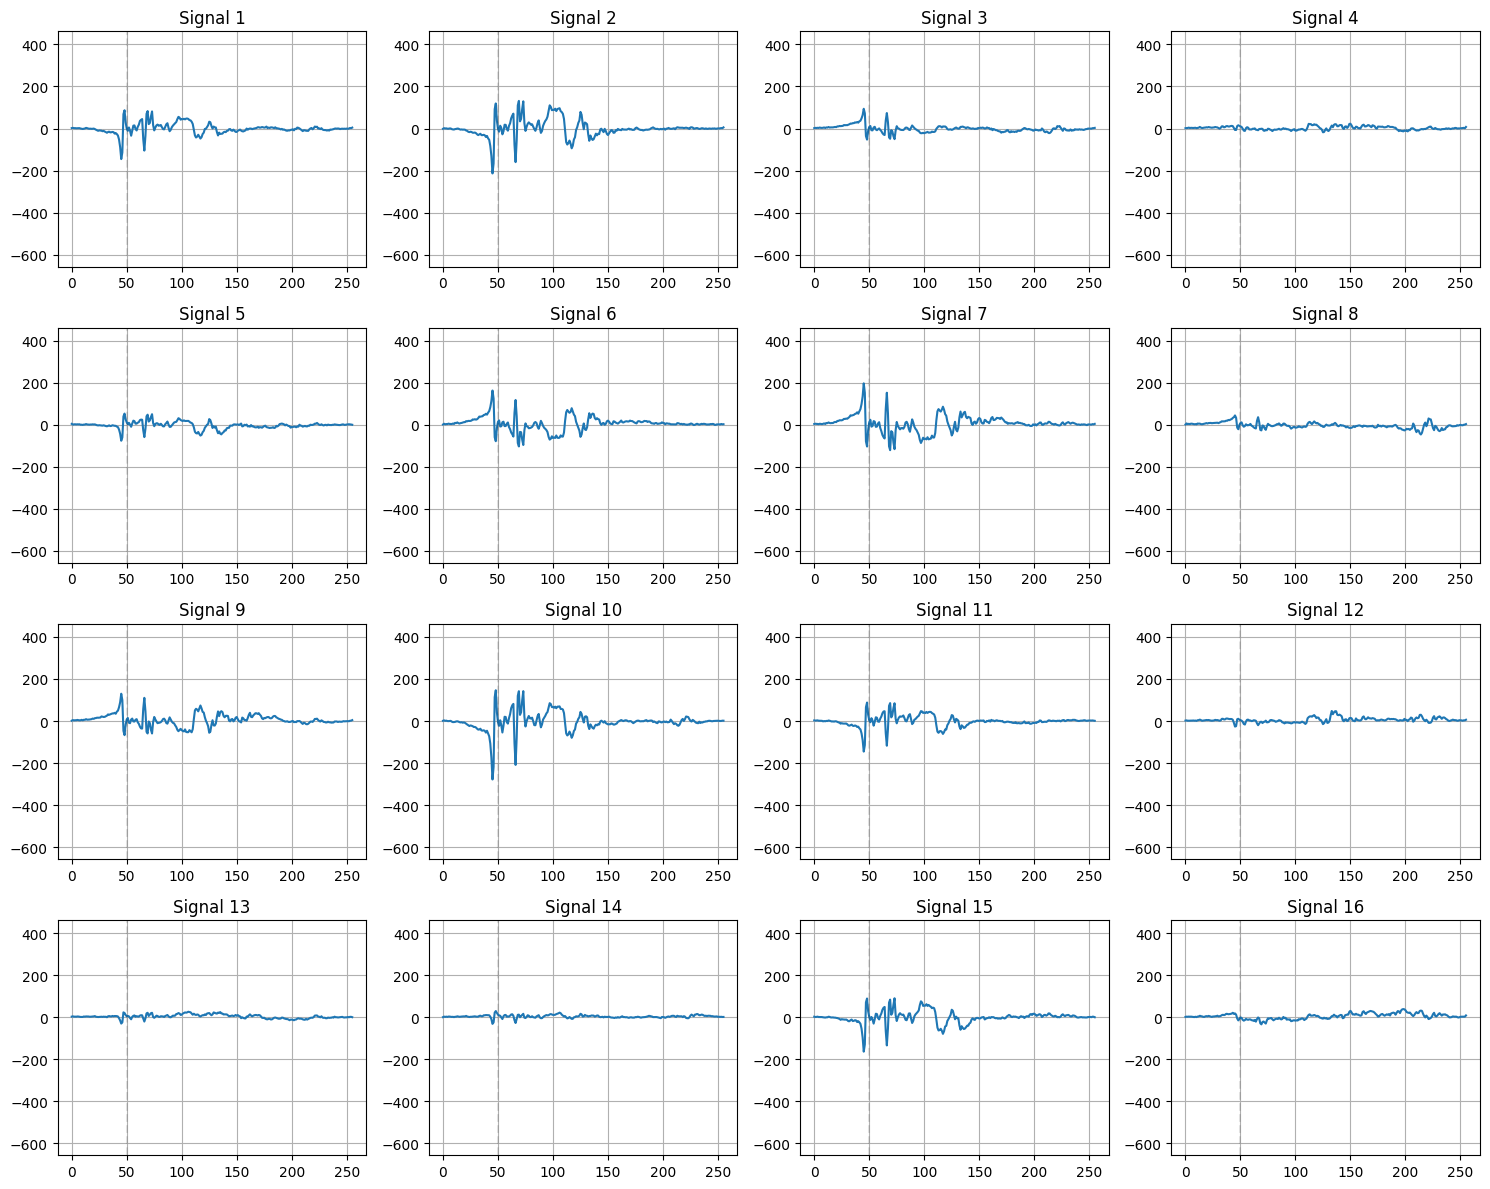

[16/32][0/188]	Loss_D: 0.6296	Loss_G: 2.1370	D(x): 0.1105	D(G(z)): 0.7663 / 0.8136
[16/32][50/188]	Loss_D: 0.6926	Loss_G: 1.6825	D(x): 0.1404	D(G(z)): 0.7199 / 0.7343
[16/32][100/188]	Loss_D: 0.8581	Loss_G: 1.4207	D(x): 0.1649	D(G(z)): 0.6798 / 0.6499
[16/32][150/188]	Loss_D: 0.6511	Loss_G: 2.7768	D(x): 0.1281	D(G(z)): 0.9000 / 0.8462
Epoch 16: SGD Discriminator lr 0.0000147 -> 0.0000143
Epoch 16: SGD Generator lr 0.0000147 -> 0.0000143


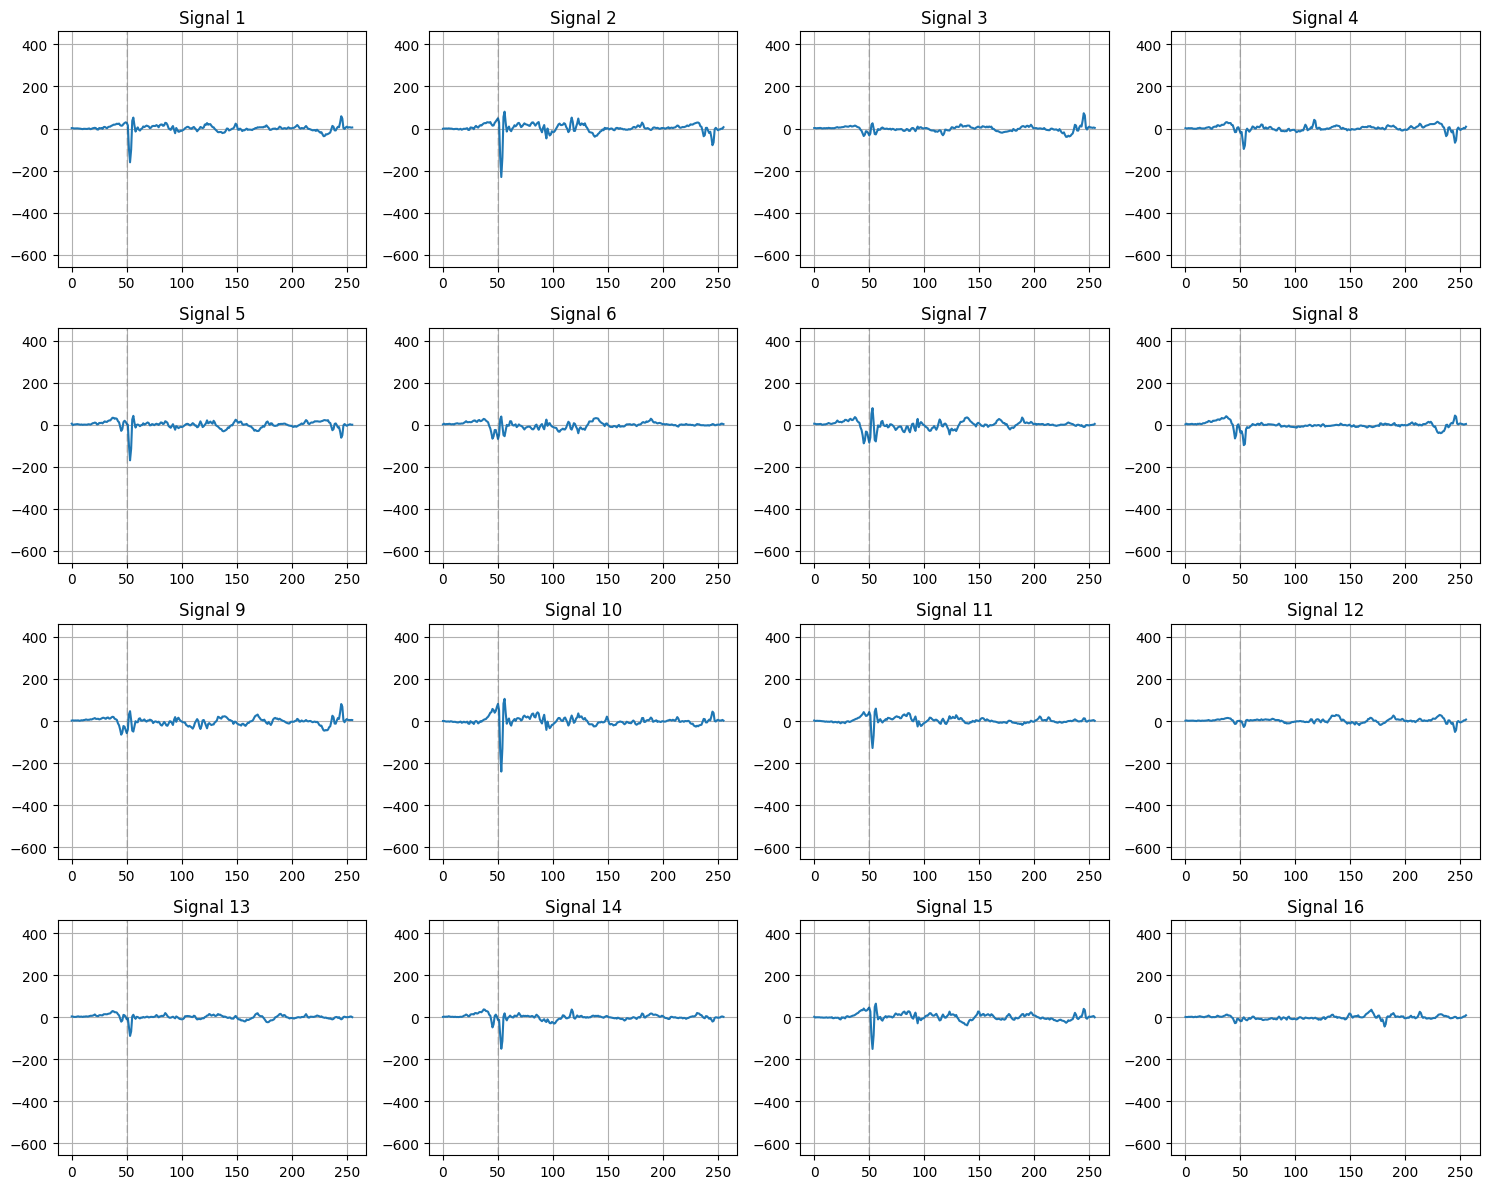

[17/32][0/188]	Loss_D: 0.6480	Loss_G: 1.9902	D(x): 0.1354	D(G(z)): 0.7903 / 0.8011
[17/32][50/188]	Loss_D: 0.7863	Loss_G: 1.7376	D(x): 0.2182	D(G(z)): 0.7644 / 0.6983
[17/32][100/188]	Loss_D: 0.7771	Loss_G: 1.4616	D(x): 0.1852	D(G(z)): 0.6852 / 0.6958
[17/32][150/188]	Loss_D: 0.6927	Loss_G: 1.9993	D(x): 0.1344	D(G(z)): 0.7420 / 0.7777
Epoch 17: SGD Discriminator lr 0.0000143 -> 0.0000140
Epoch 17: SGD Generator lr 0.0000143 -> 0.0000140


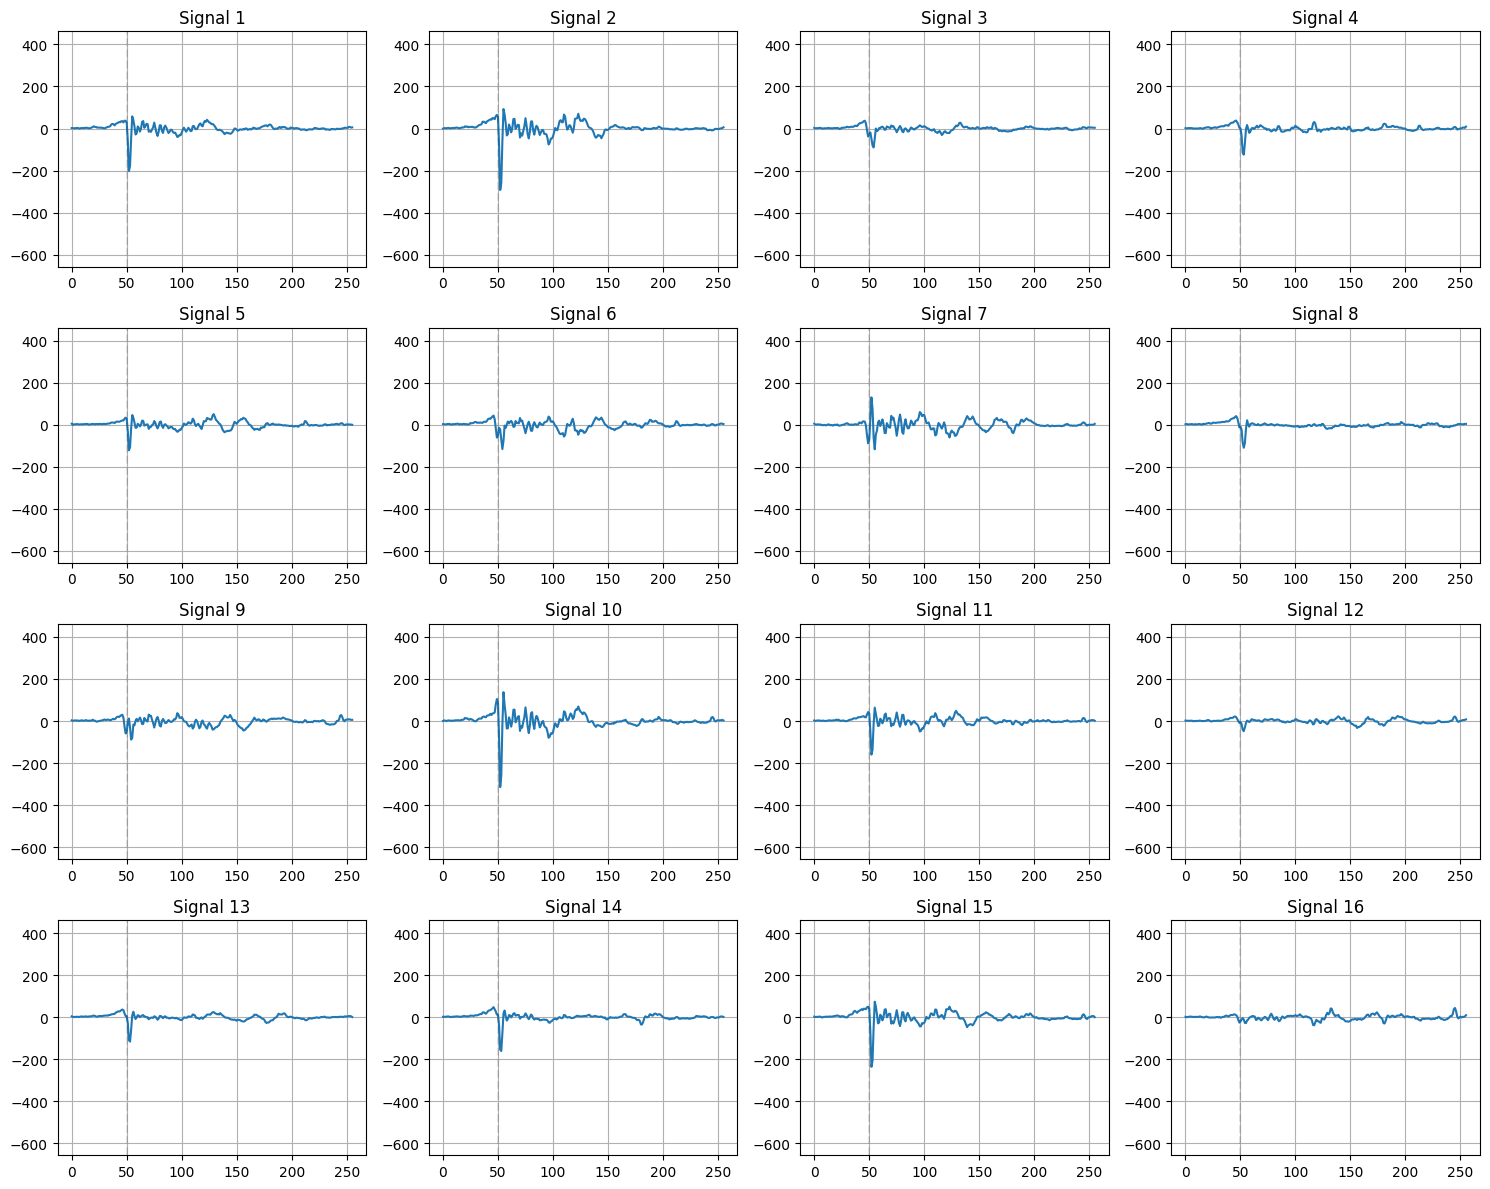

[18/32][0/188]	Loss_D: 0.7456	Loss_G: 1.8372	D(x): 0.1631	D(G(z)): 0.7116 / 0.7334
[18/32][50/188]	Loss_D: 0.9817	Loss_G: 1.1764	D(x): 0.3121	D(G(z)): 0.6566 / 0.6441
[18/32][100/188]	Loss_D: 0.9051	Loss_G: 1.2859	D(x): 0.2261	D(G(z)): 0.6275 / 0.6552
[18/32][150/188]	Loss_D: 0.6999	Loss_G: 1.5798	D(x): 0.1607	D(G(z)): 0.7473 / 0.7081
Epoch 18: SGD Discriminator lr 0.0000140 -> 0.0000137
Epoch 18: SGD Generator lr 0.0000140 -> 0.0000137


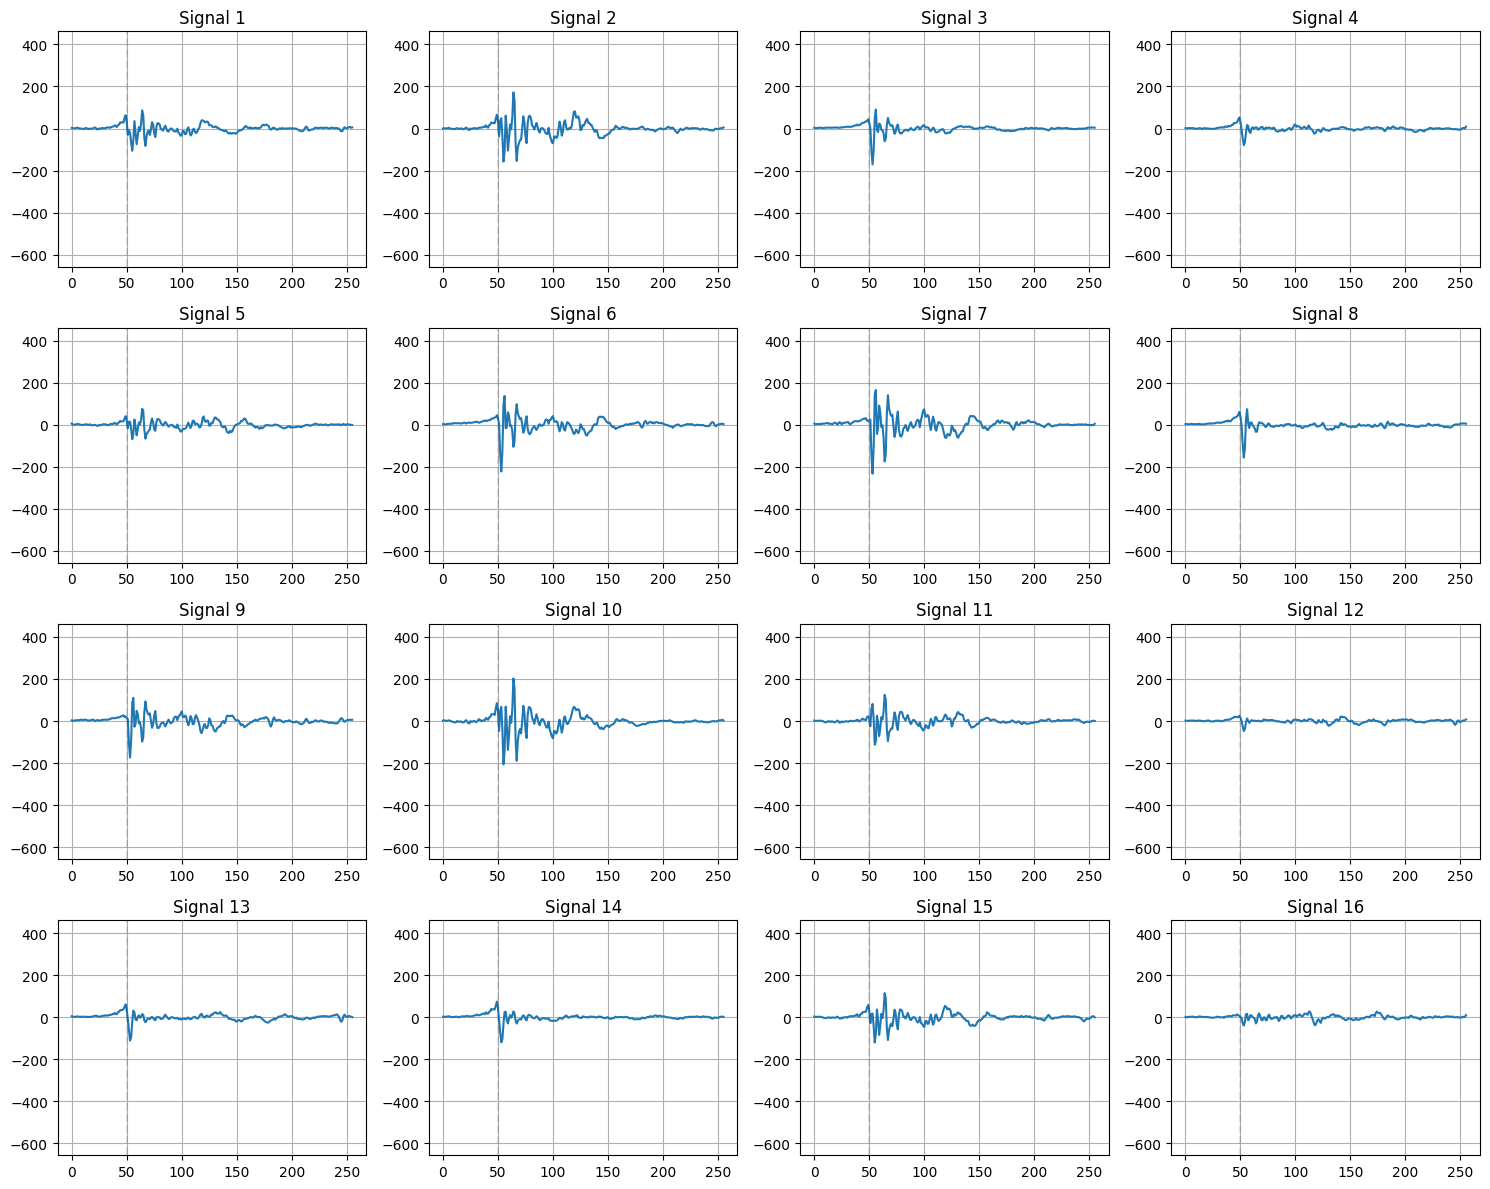

[19/32][0/188]	Loss_D: 0.7762	Loss_G: 1.2236	D(x): 0.2119	D(G(z)): 0.7561 / 0.6329
[19/32][50/188]	Loss_D: 0.8686	Loss_G: 1.7897	D(x): 0.2255	D(G(z)): 0.6539 / 0.7431
[19/32][100/188]	Loss_D: 0.7578	Loss_G: 1.7074	D(x): 0.2124	D(G(z)): 0.7584 / 0.7636
[19/32][150/188]	Loss_D: 0.7749	Loss_G: 1.4051	D(x): 0.2029	D(G(z)): 0.6687 / 0.6963
Epoch 19: SGD Discriminator lr 0.0000137 -> 0.0000133
Epoch 19: SGD Generator lr 0.0000137 -> 0.0000133


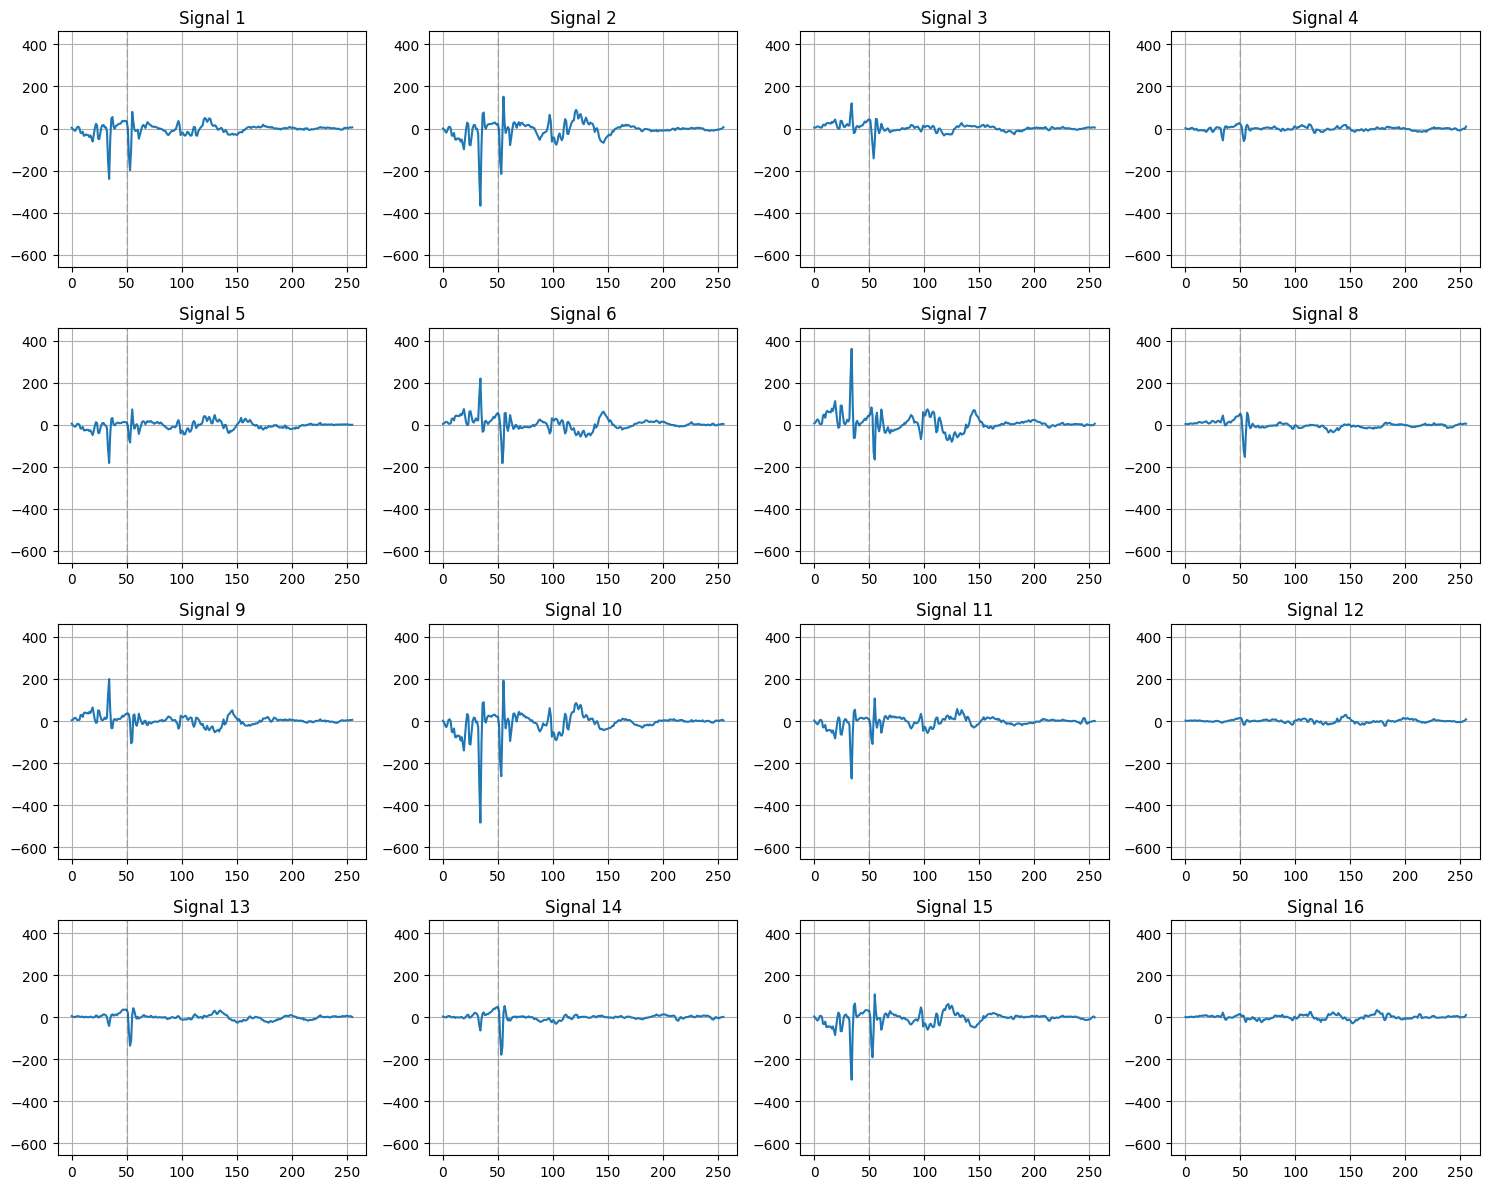

[20/32][0/188]	Loss_D: 0.7413	Loss_G: 1.6594	D(x): 0.2209	D(G(z)): 0.7580 / 0.7374
[20/32][50/188]	Loss_D: 0.6923	Loss_G: 2.5323	D(x): 0.1641	D(G(z)): 0.8298 / 0.8455
[20/32][100/188]	Loss_D: 0.7707	Loss_G: 1.8251	D(x): 0.1423	D(G(z)): 0.6854 / 0.7706
[20/32][150/188]	Loss_D: 0.7350	Loss_G: 1.6496	D(x): 0.1995	D(G(z)): 0.7329 / 0.7185
Epoch 20: SGD Discriminator lr 0.0000133 -> 0.0000130
Epoch 20: SGD Generator lr 0.0000133 -> 0.0000130


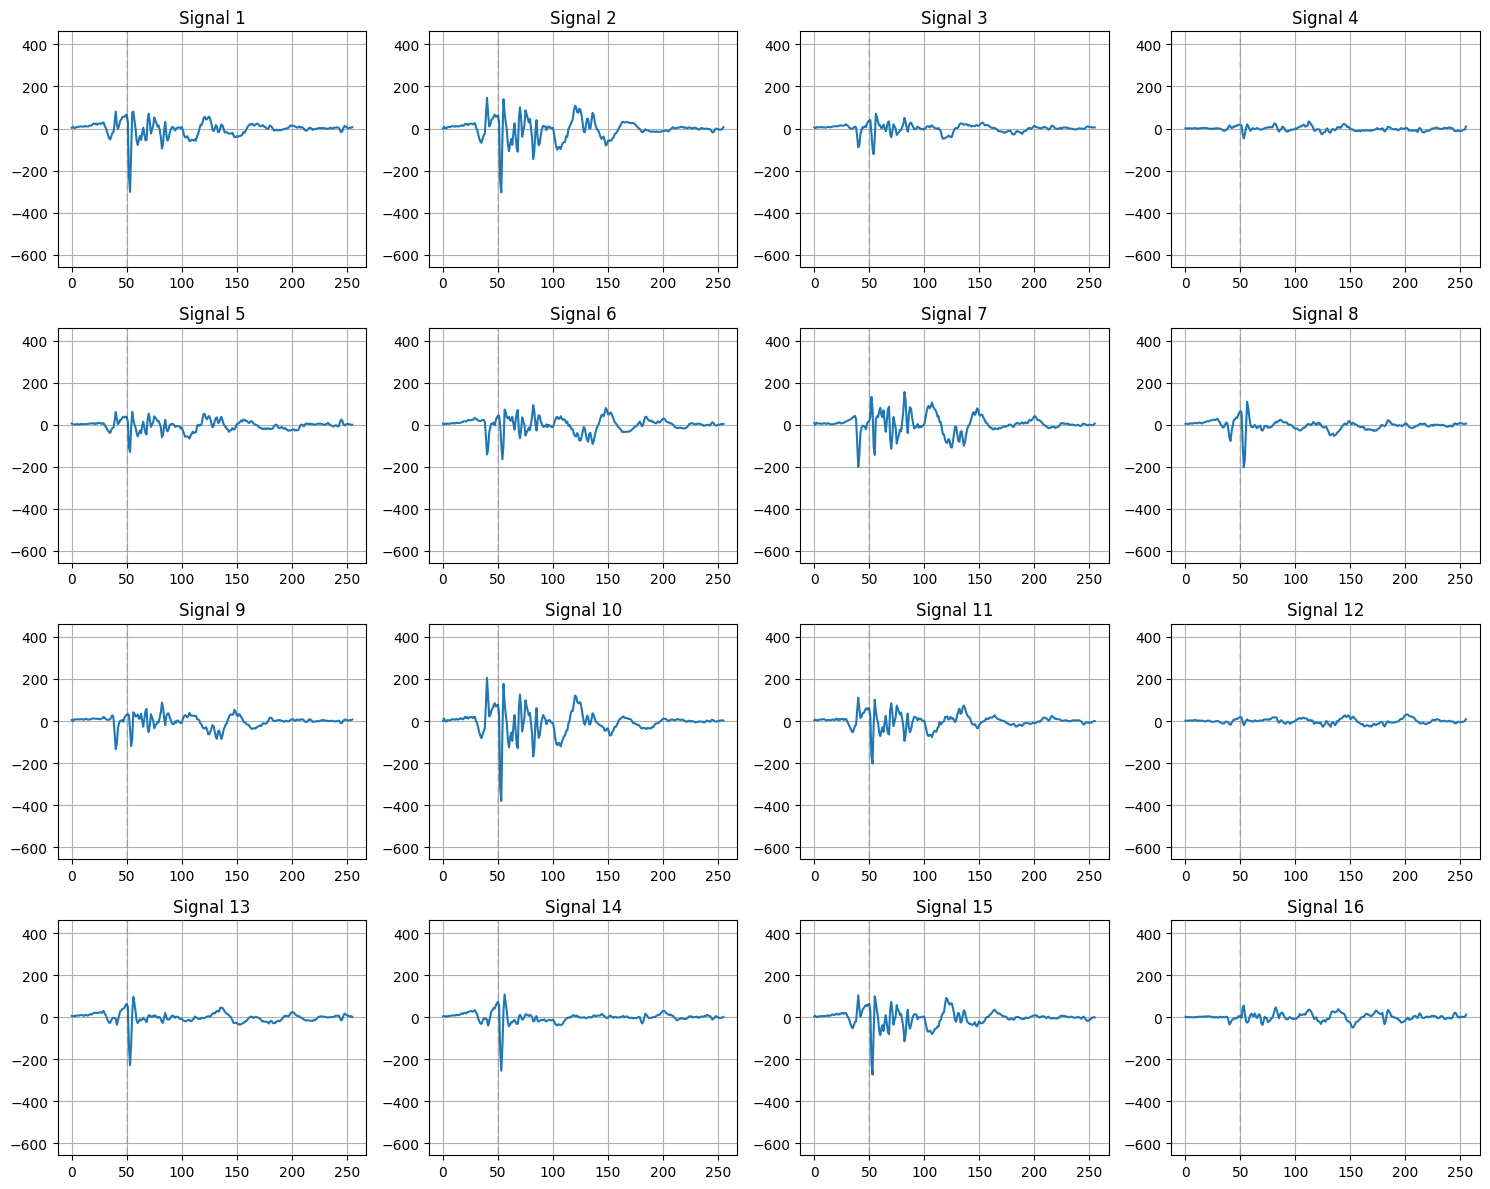

[21/32][0/188]	Loss_D: 0.8039	Loss_G: 2.0257	D(x): 0.2064	D(G(z)): 0.8046 / 0.7928
[21/32][50/188]	Loss_D: 0.7385	Loss_G: 1.4931	D(x): 0.1858	D(G(z)): 0.7571 / 0.7275
[21/32][100/188]	Loss_D: 0.6278	Loss_G: 1.8140	D(x): 0.0918	D(G(z)): 0.7524 / 0.7303
[21/32][150/188]	Loss_D: 0.8264	Loss_G: 2.2869	D(x): 0.2038	D(G(z)): 0.8124 / 0.8386
Epoch 21: SGD Discriminator lr 0.0000130 -> 0.0000127
Epoch 21: SGD Generator lr 0.0000130 -> 0.0000127


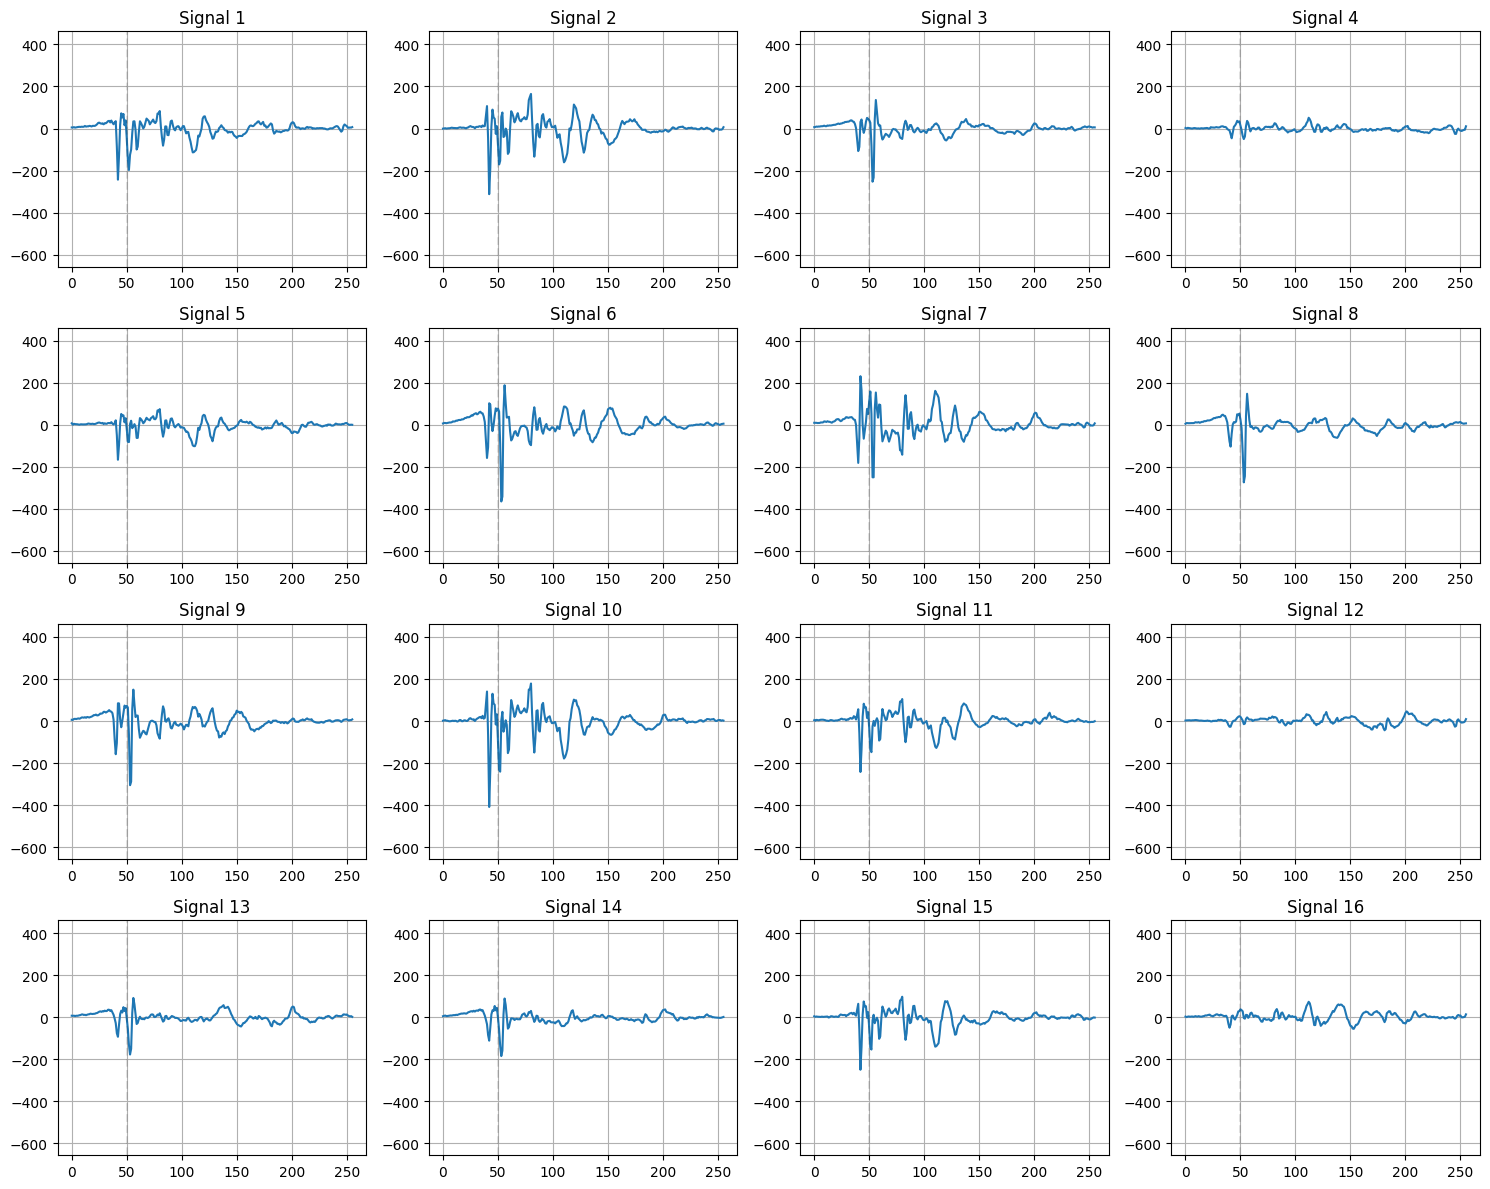

[22/32][0/188]	Loss_D: 0.5672	Loss_G: 2.0078	D(x): 0.1096	D(G(z)): 0.8219 / 0.7933
[22/32][50/188]	Loss_D: 0.7175	Loss_G: 1.7089	D(x): 0.1804	D(G(z)): 0.8112 / 0.7417
[22/32][100/188]	Loss_D: 0.7095	Loss_G: 1.5175	D(x): 0.1515	D(G(z)): 0.7764 / 0.7109
[22/32][150/188]	Loss_D: 0.8494	Loss_G: 2.1881	D(x): 0.2440	D(G(z)): 0.7842 / 0.8037
Epoch 22: SGD Discriminator lr 0.0000127 -> 0.0000123
Epoch 22: SGD Generator lr 0.0000127 -> 0.0000123


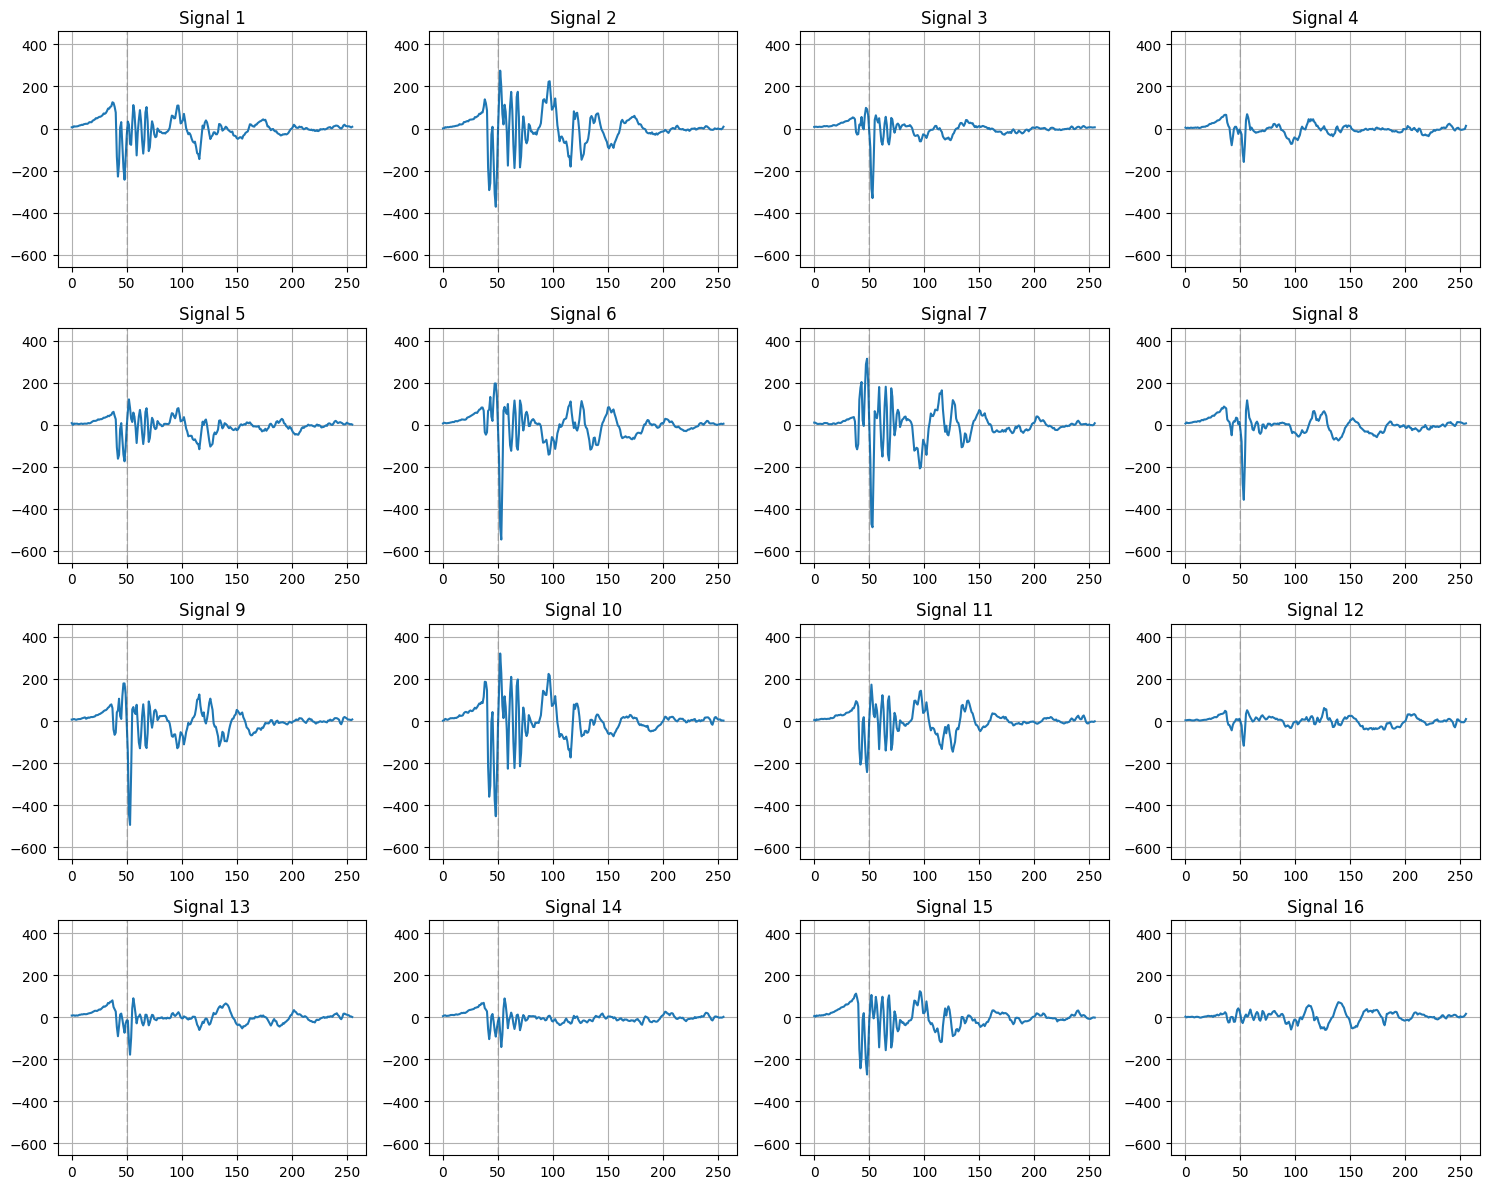

[23/32][0/188]	Loss_D: 0.8049	Loss_G: 1.5843	D(x): 0.2498	D(G(z)): 0.7805 / 0.7199
[23/32][50/188]	Loss_D: 0.7144	Loss_G: 1.7174	D(x): 0.1647	D(G(z)): 0.7494 / 0.7384
[23/32][100/188]	Loss_D: 0.6896	Loss_G: 1.3766	D(x): 0.0928	D(G(z)): 0.6157 / 0.6858
[23/32][150/188]	Loss_D: 0.6161	Loss_G: 1.9107	D(x): 0.0823	D(G(z)): 0.7142 / 0.7639
Epoch 23: SGD Discriminator lr 0.0000123 -> 0.0000120
Epoch 23: SGD Generator lr 0.0000123 -> 0.0000120


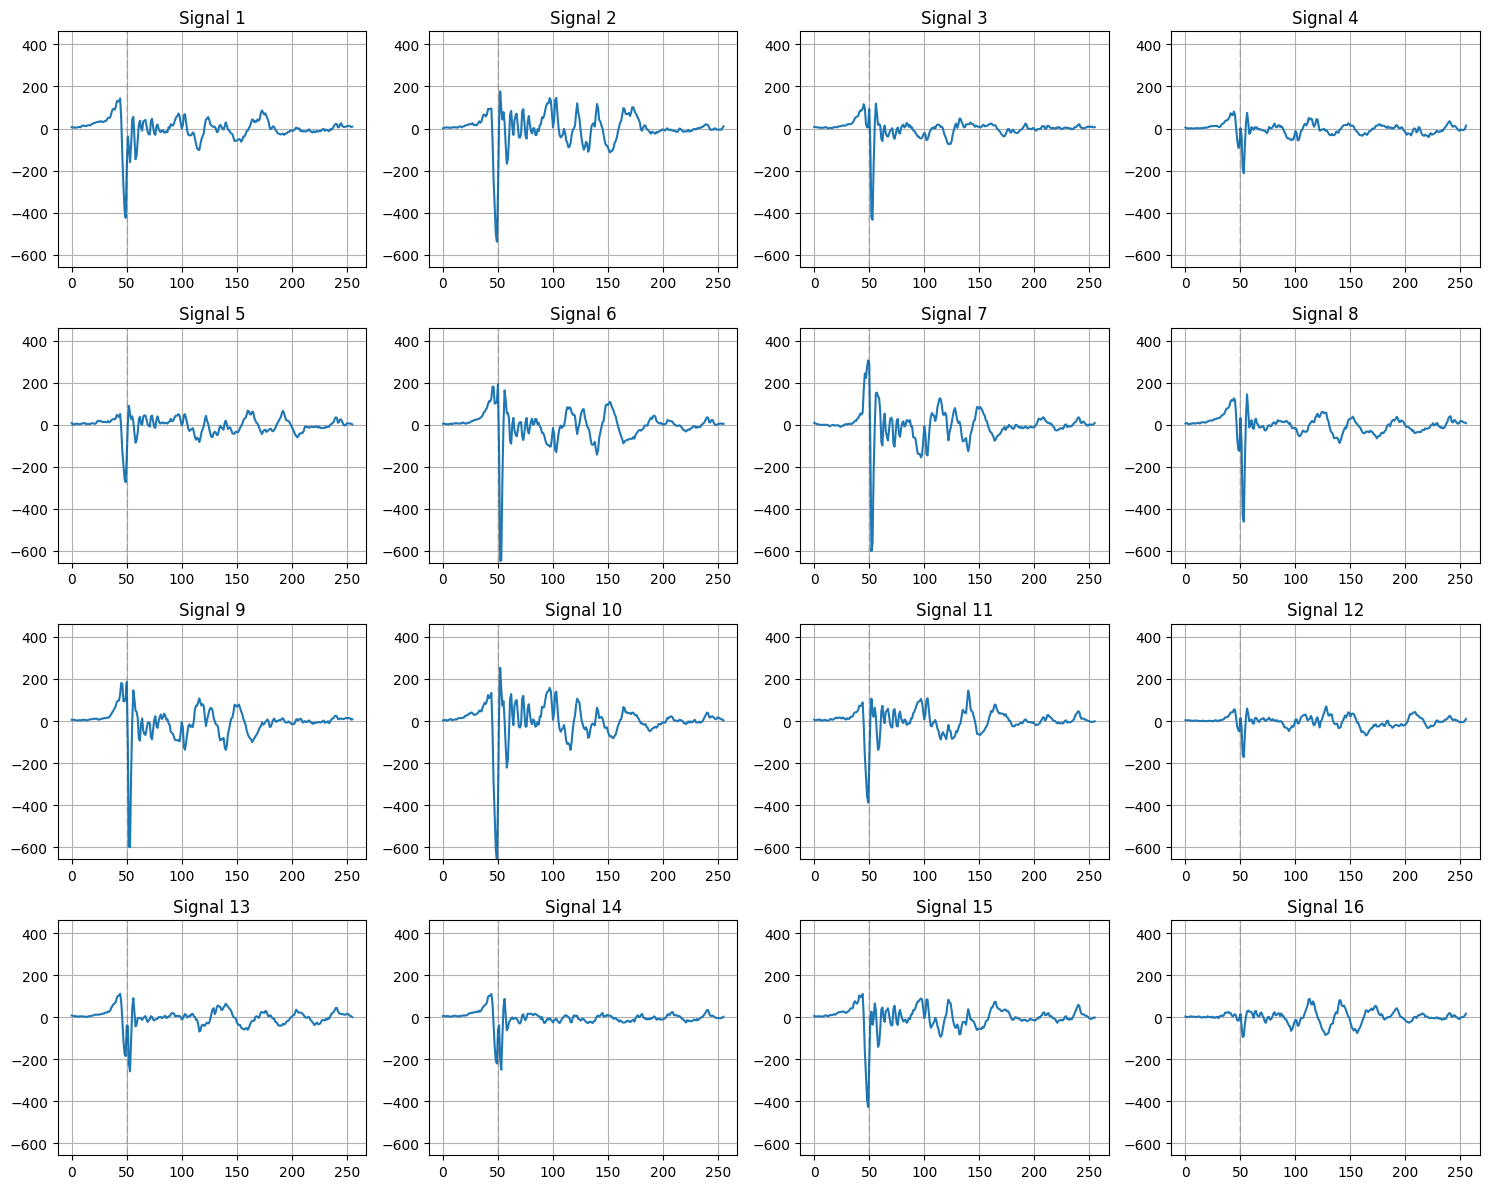

[24/32][0/188]	Loss_D: 0.8147	Loss_G: 1.4443	D(x): 0.1939	D(G(z)): 0.6623 / 0.6847
[24/32][50/188]	Loss_D: 0.7229	Loss_G: 1.5731	D(x): 0.1740	D(G(z)): 0.7846 / 0.7320
[24/32][100/188]	Loss_D: 0.8148	Loss_G: 1.4595	D(x): 0.2311	D(G(z)): 0.7006 / 0.6721
[24/32][150/188]	Loss_D: 0.7513	Loss_G: 2.4954	D(x): 0.2081	D(G(z)): 0.8188 / 0.8449
Epoch 24: SGD Discriminator lr 0.0000120 -> 0.0000117
Epoch 24: SGD Generator lr 0.0000120 -> 0.0000117


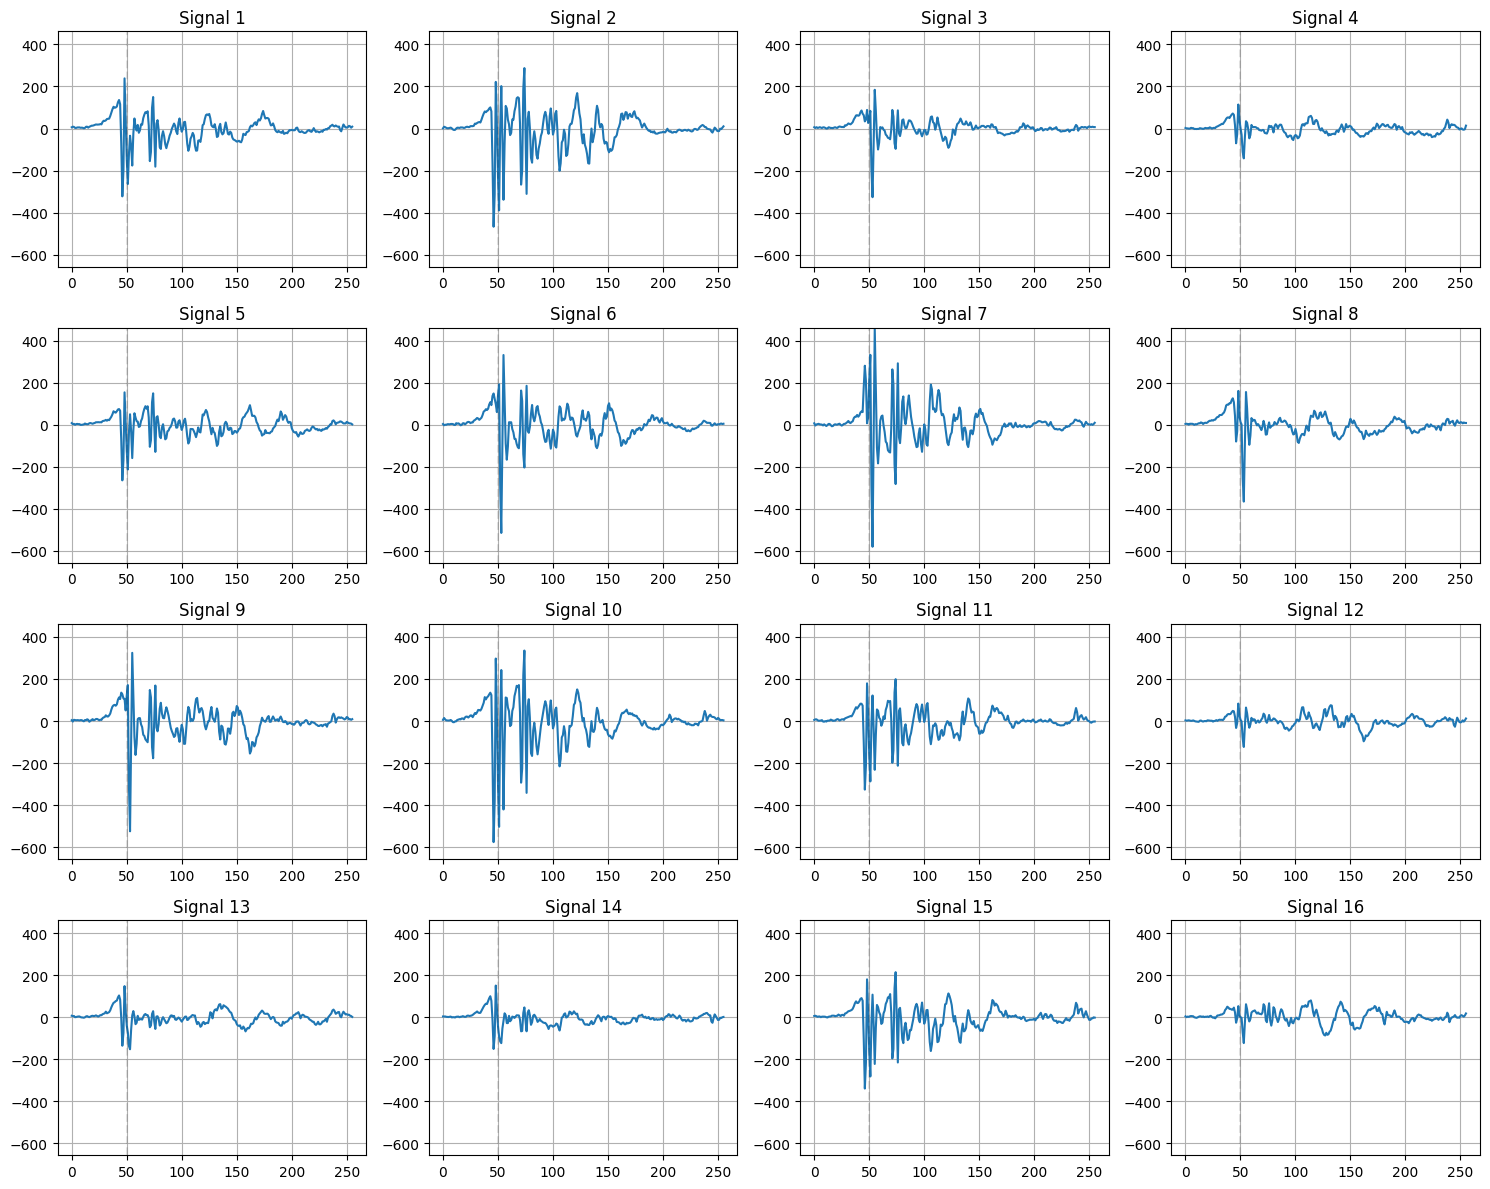

[25/32][0/188]	Loss_D: 0.7585	Loss_G: 1.5917	D(x): 0.1626	D(G(z)): 0.7164 / 0.7062
[25/32][50/188]	Loss_D: 0.6251	Loss_G: 1.4764	D(x): 0.0884	D(G(z)): 0.7845 / 0.7086
[25/32][100/188]	Loss_D: 0.7170	Loss_G: 1.8451	D(x): 0.1452	D(G(z)): 0.7345 / 0.7831
[25/32][150/188]	Loss_D: 0.7788	Loss_G: 1.6436	D(x): 0.1840	D(G(z)): 0.7400 / 0.7341
Epoch 25: SGD Discriminator lr 0.0000117 -> 0.0000113
Epoch 25: SGD Generator lr 0.0000117 -> 0.0000113


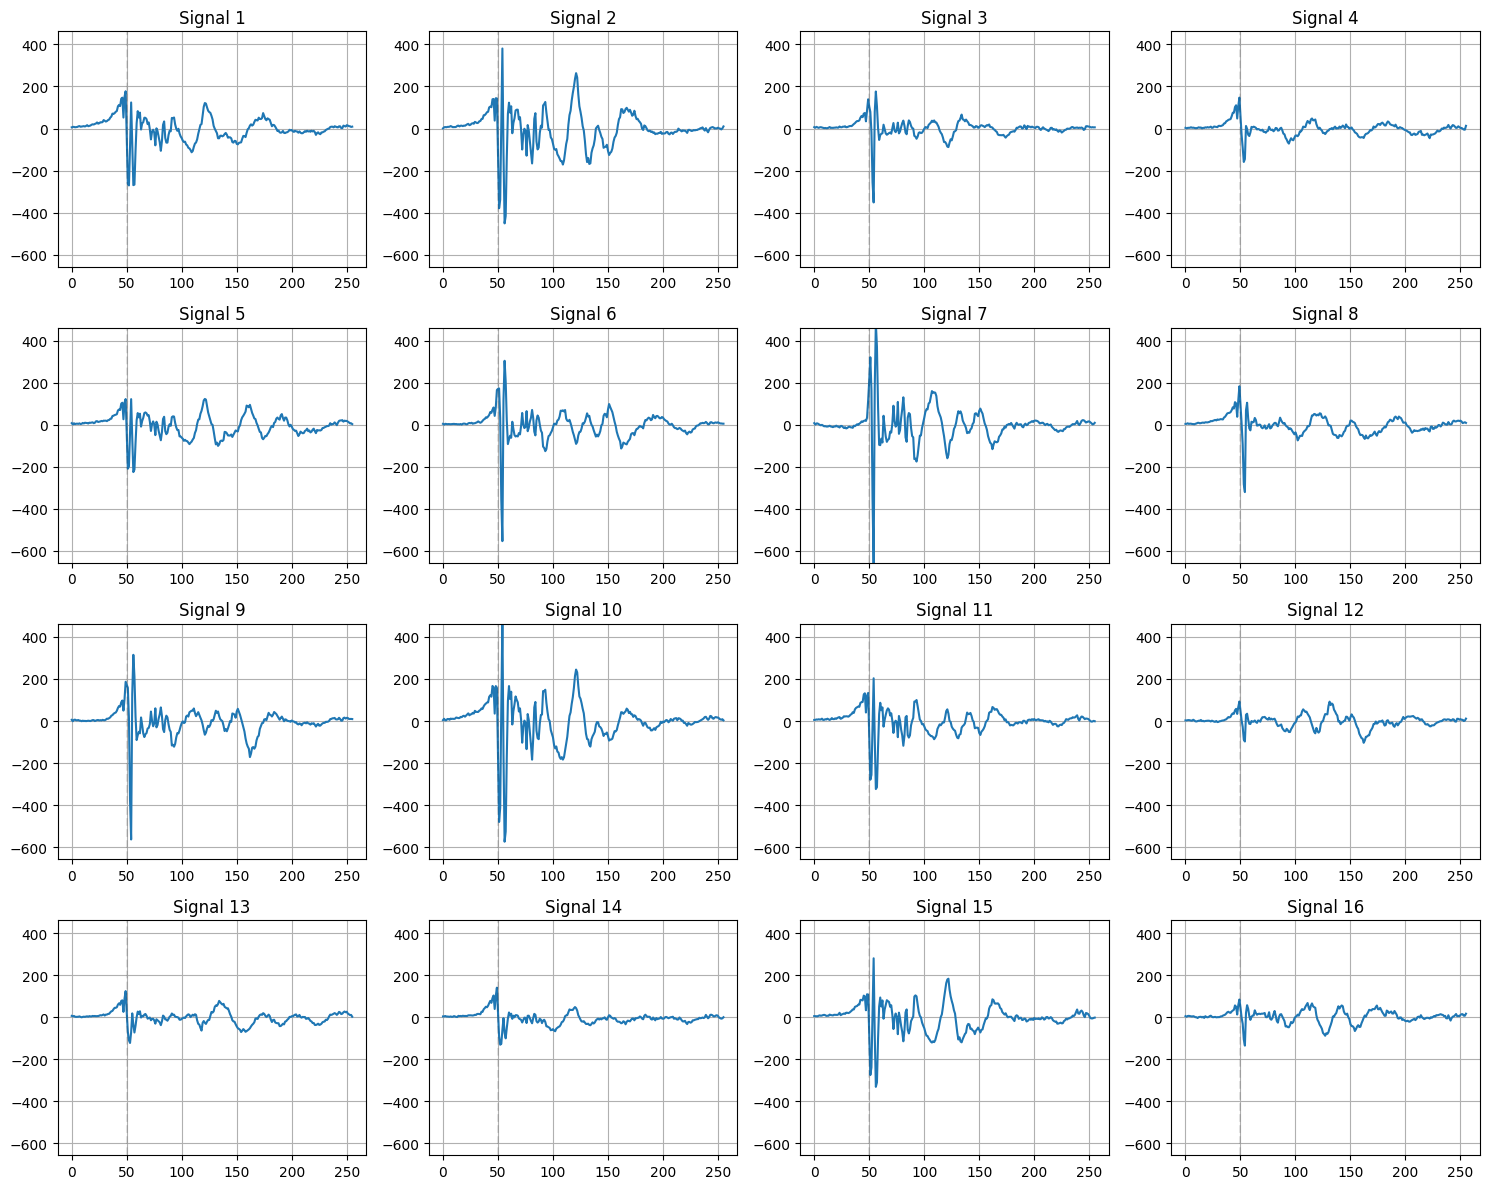

[26/32][0/188]	Loss_D: 0.7840	Loss_G: 1.3621	D(x): 0.1789	D(G(z)): 0.7524 / 0.6858
[26/32][50/188]	Loss_D: 0.7264	Loss_G: 1.7370	D(x): 0.1628	D(G(z)): 0.7249 / 0.7478
[26/32][100/188]	Loss_D: 0.7019	Loss_G: 1.6734	D(x): 0.1567	D(G(z)): 0.7685 / 0.7549
[26/32][150/188]	Loss_D: 0.6685	Loss_G: 2.1443	D(x): 0.1588	D(G(z)): 0.8589 / 0.8168
Epoch 26: SGD Discriminator lr 0.0000113 -> 0.0000110
Epoch 26: SGD Generator lr 0.0000113 -> 0.0000110


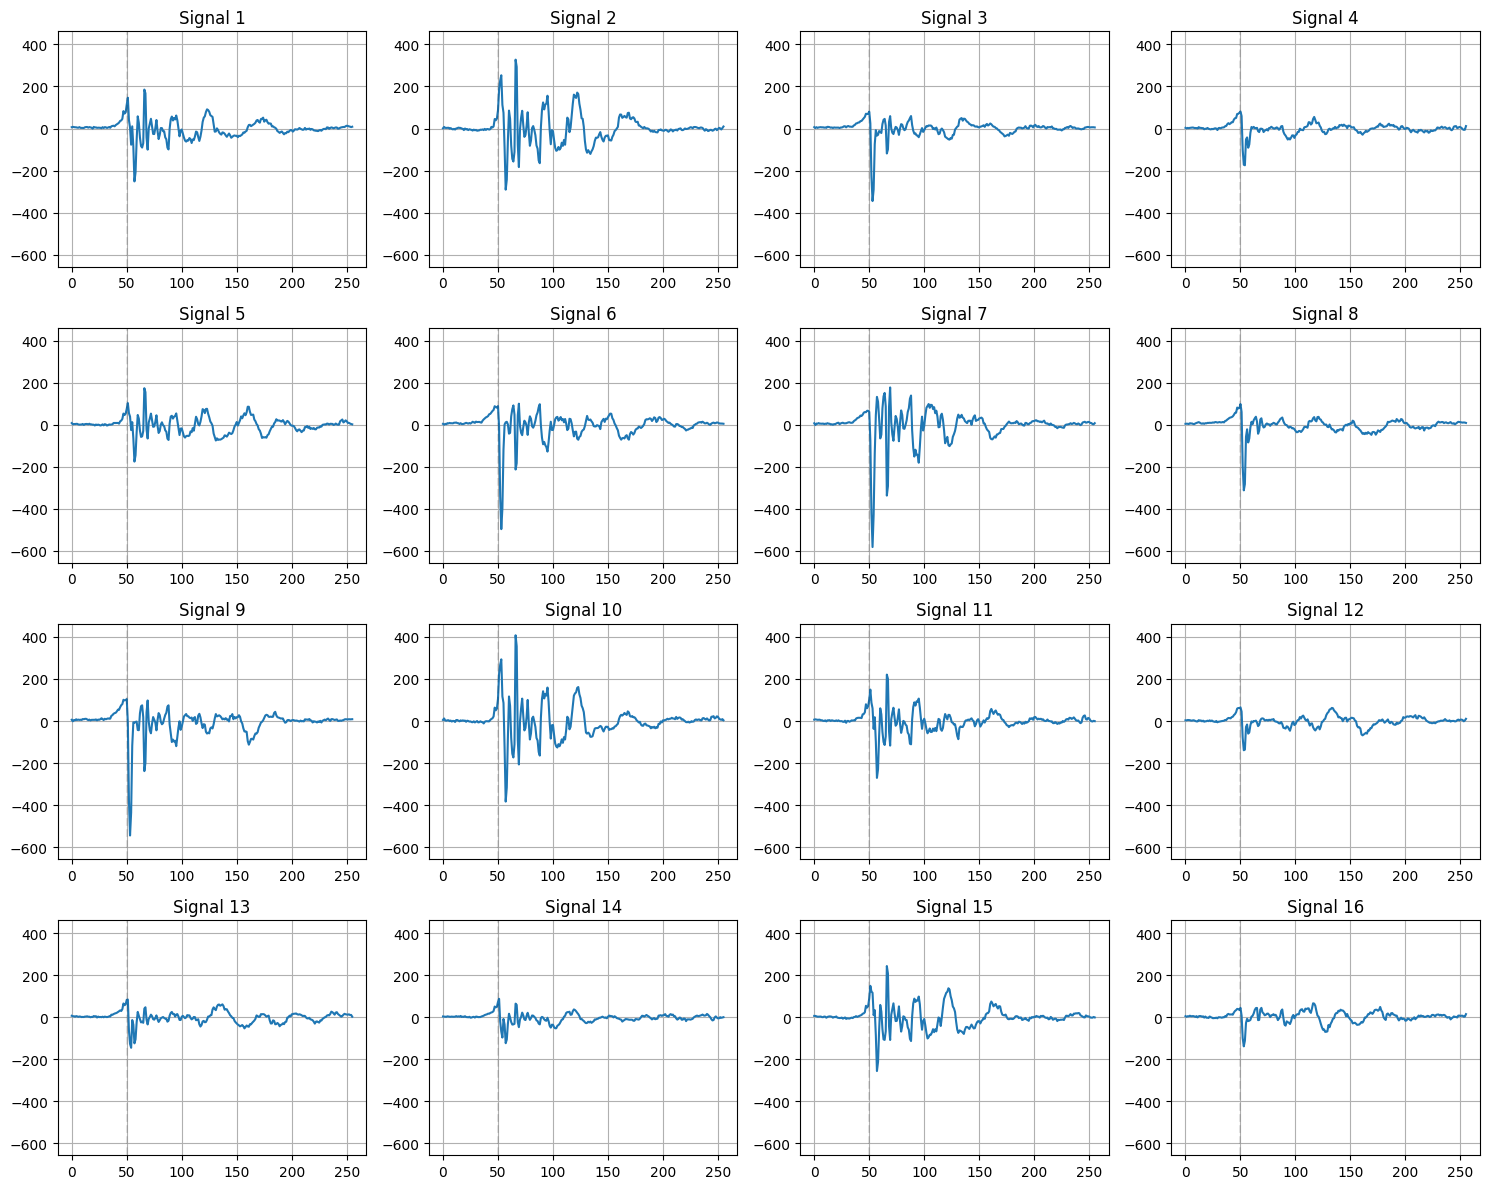

[27/32][0/188]	Loss_D: 0.7593	Loss_G: 1.6466	D(x): 0.2014	D(G(z)): 0.7584 / 0.7280
[27/32][50/188]	Loss_D: 0.6244	Loss_G: 2.0541	D(x): 0.1004	D(G(z)): 0.7292 / 0.7976
[27/32][100/188]	Loss_D: 0.7042	Loss_G: 2.1143	D(x): 0.1571	D(G(z)): 0.7918 / 0.7828
[27/32][150/188]	Loss_D: 0.8227	Loss_G: 1.8696	D(x): 0.1732	D(G(z)): 0.7127 / 0.7664
Epoch 27: SGD Discriminator lr 0.0000110 -> 0.0000107
Epoch 27: SGD Generator lr 0.0000110 -> 0.0000107


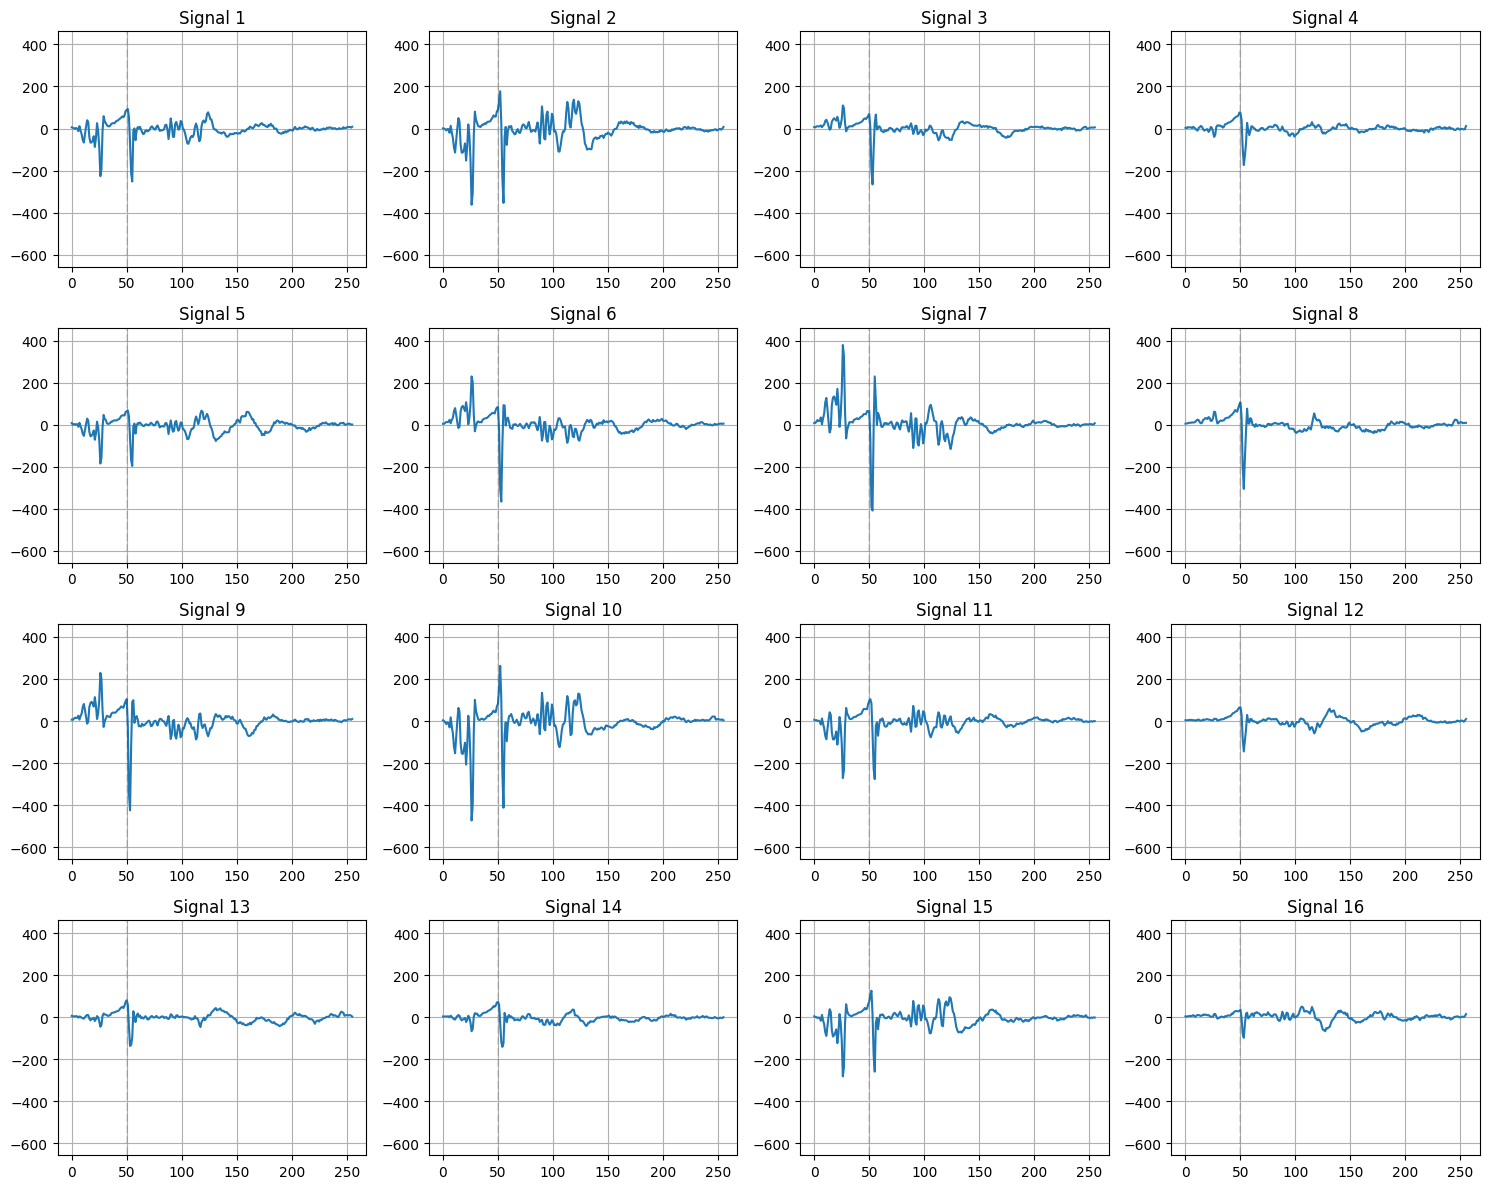

[28/32][0/188]	Loss_D: 0.6674	Loss_G: 1.6868	D(x): 0.1188	D(G(z)): 0.7951 / 0.7296
[28/32][50/188]	Loss_D: 0.7657	Loss_G: 1.7517	D(x): 0.1685	D(G(z)): 0.7498 / 0.7495
[28/32][100/188]	Loss_D: 0.8263	Loss_G: 2.2103	D(x): 0.1606	D(G(z)): 0.6918 / 0.8073
[28/32][150/188]	Loss_D: 0.6892	Loss_G: 1.4760	D(x): 0.1295	D(G(z)): 0.6931 / 0.6969
Epoch 28: SGD Discriminator lr 0.0000107 -> 0.0000103
Epoch 28: SGD Generator lr 0.0000107 -> 0.0000103


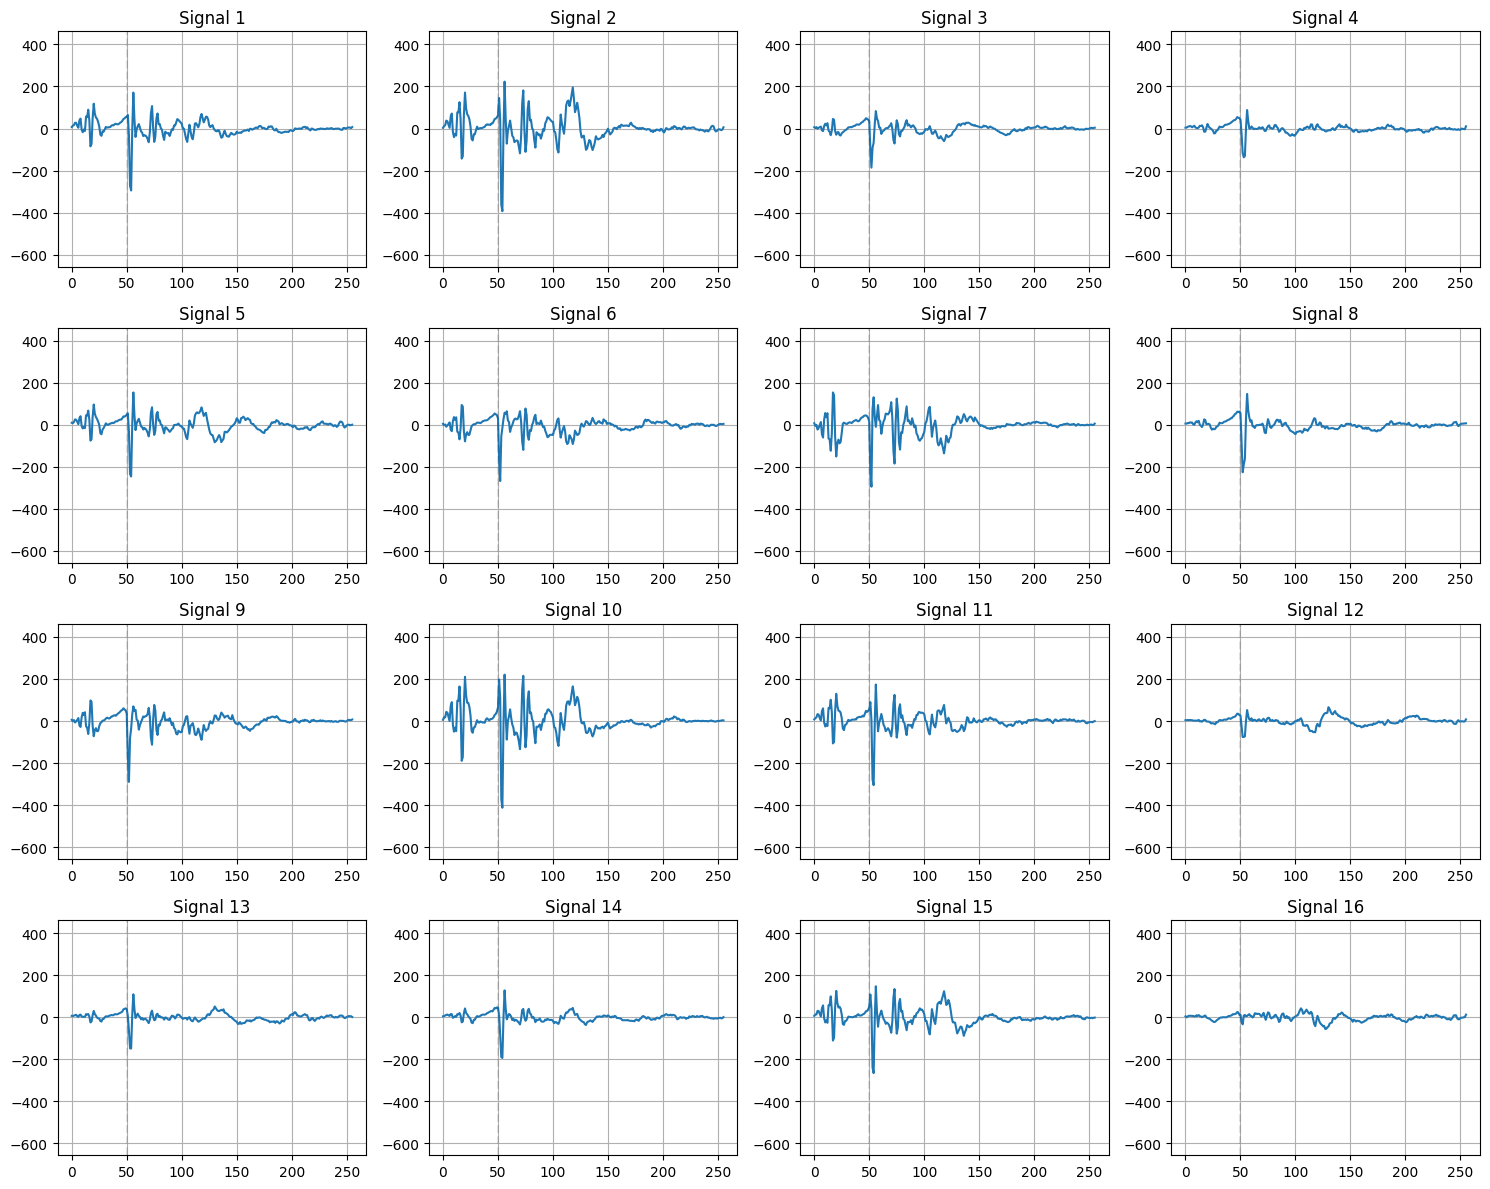

[29/32][0/188]	Loss_D: 0.6892	Loss_G: 1.6502	D(x): 0.1594	D(G(z)): 0.7423 / 0.7403
[29/32][50/188]	Loss_D: 0.7772	Loss_G: 1.6732	D(x): 0.1745	D(G(z)): 0.7375 / 0.7384
[29/32][100/188]	Loss_D: 0.7672	Loss_G: 1.4533	D(x): 0.1609	D(G(z)): 0.7209 / 0.6879
[29/32][150/188]	Loss_D: 0.6528	Loss_G: 2.2579	D(x): 0.1783	D(G(z)): 0.8398 / 0.8086
Epoch 29: SGD Discriminator lr 0.0000103 -> 0.0000100
Epoch 29: SGD Generator lr 0.0000103 -> 0.0000100


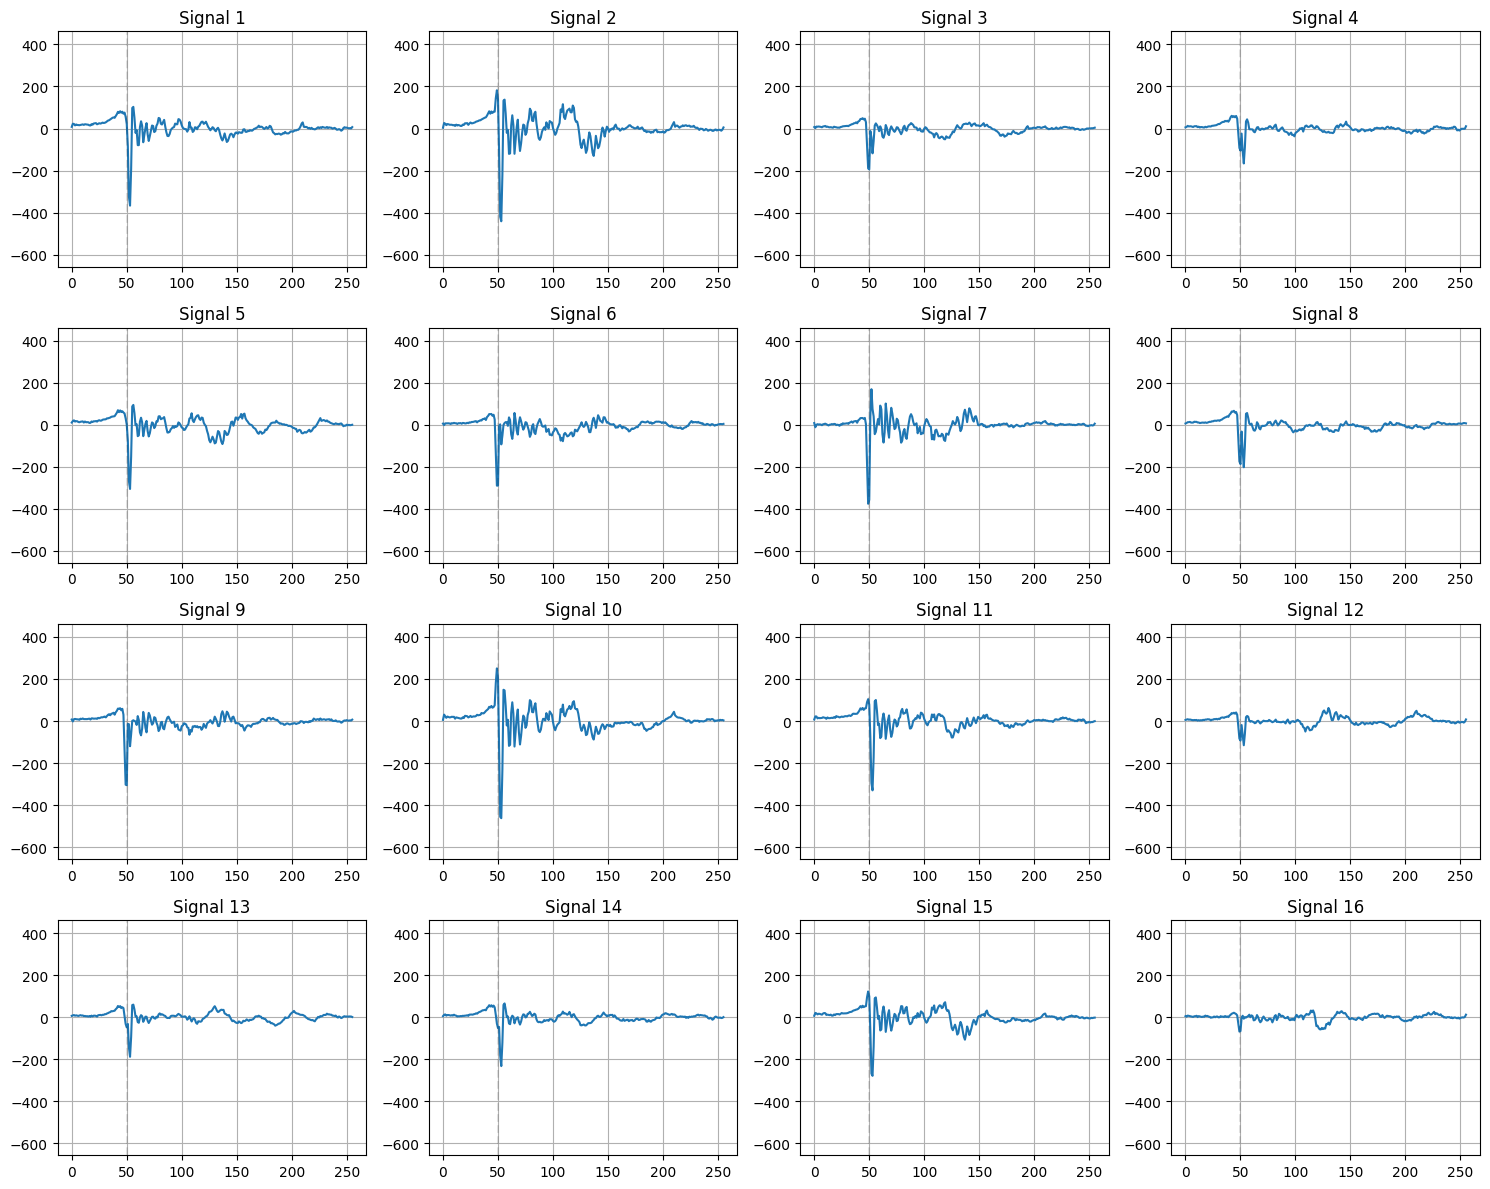

[30/32][0/188]	Loss_D: 0.6199	Loss_G: 1.9655	D(x): 0.1320	D(G(z)): 0.7687 / 0.7949
[30/32][50/188]	Loss_D: 0.7005	Loss_G: 1.8456	D(x): 0.1227	D(G(z)): 0.7022 / 0.7732
[30/32][100/188]	Loss_D: 0.6106	Loss_G: 1.7402	D(x): 0.1321	D(G(z)): 0.7789 / 0.7486
[30/32][150/188]	Loss_D: 0.5898	Loss_G: 1.8638	D(x): 0.0970	D(G(z)): 0.7691 / 0.7624
Epoch 30: SGD Discriminator lr 0.0000100 -> 0.0000100
Epoch 30: SGD Generator lr 0.0000100 -> 0.0000100


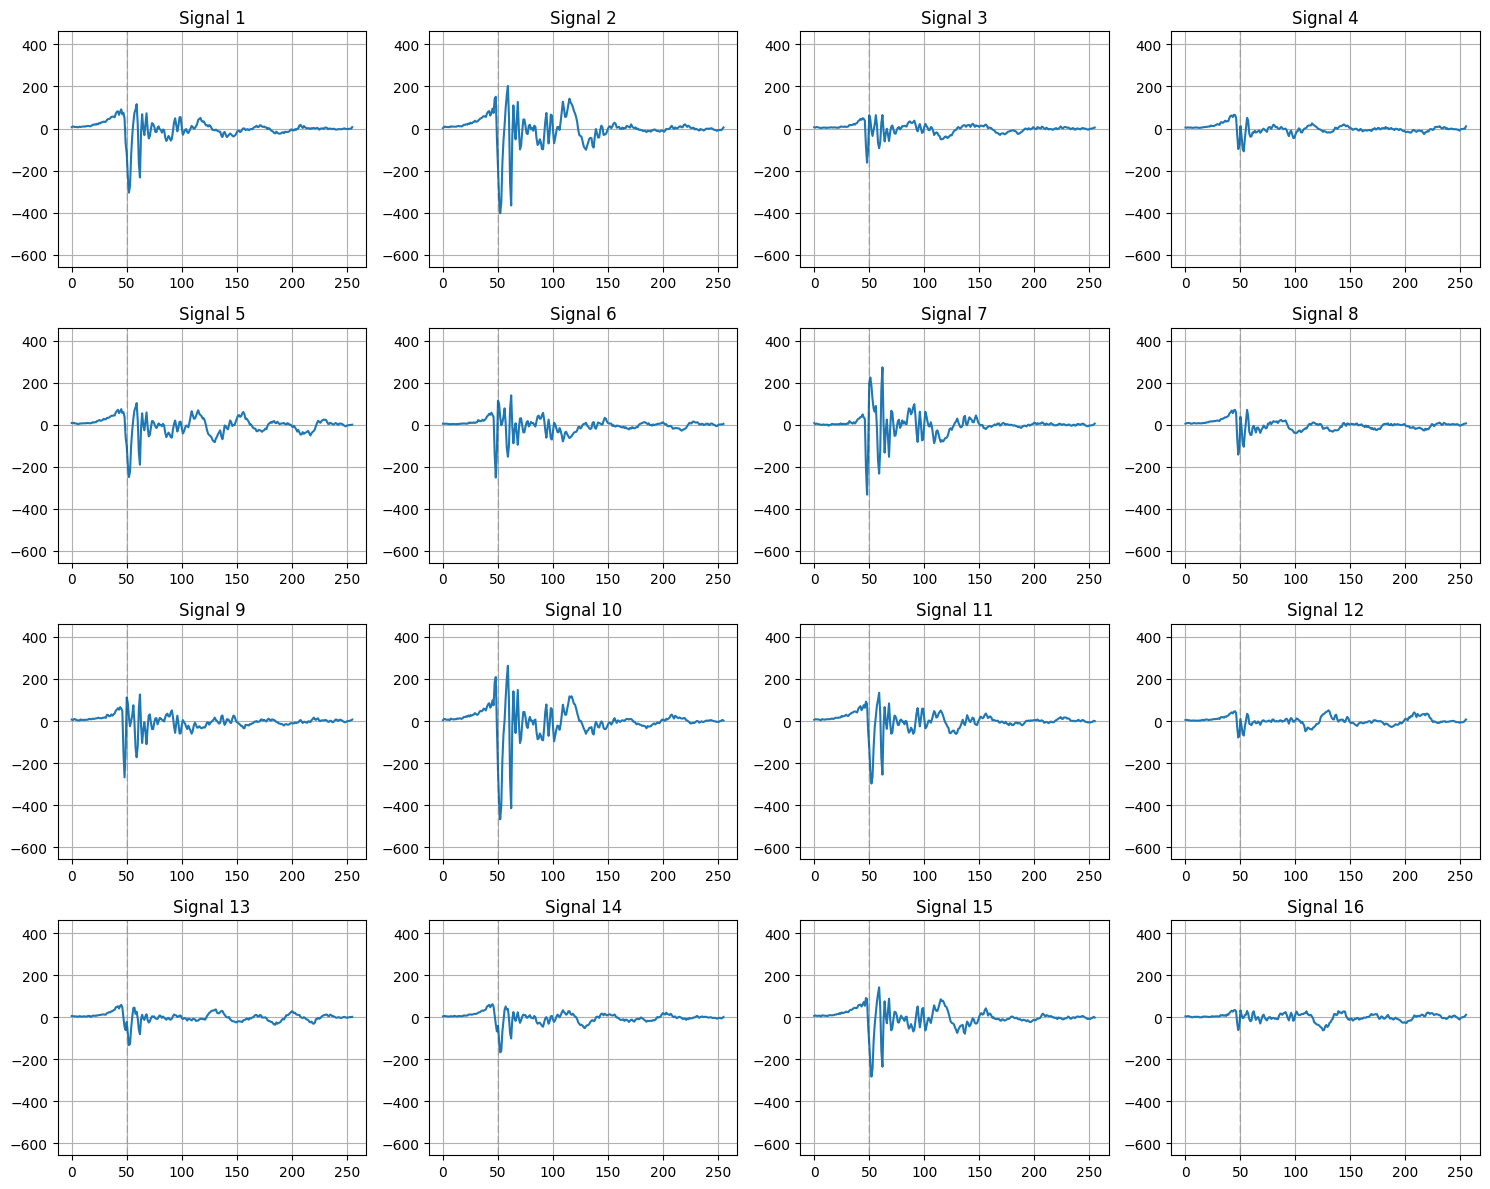

[31/32][0/188]	Loss_D: 0.6720	Loss_G: 1.9131	D(x): 0.1093	D(G(z)): 0.7233 / 0.7873
[31/32][50/188]	Loss_D: 0.5716	Loss_G: 1.8204	D(x): 0.0888	D(G(z)): 0.7264 / 0.7911
[31/32][100/188]	Loss_D: 0.9938	Loss_G: 1.7045	D(x): 0.2567	D(G(z)): 0.7033 / 0.7351
[31/32][150/188]	Loss_D: 0.7677	Loss_G: 1.2117	D(x): 0.1672	D(G(z)): 0.7065 / 0.6465
Epoch 31: SGD Discriminator lr 0.0000100 -> 0.0000100
Epoch 31: SGD Generator lr 0.0000100 -> 0.0000100


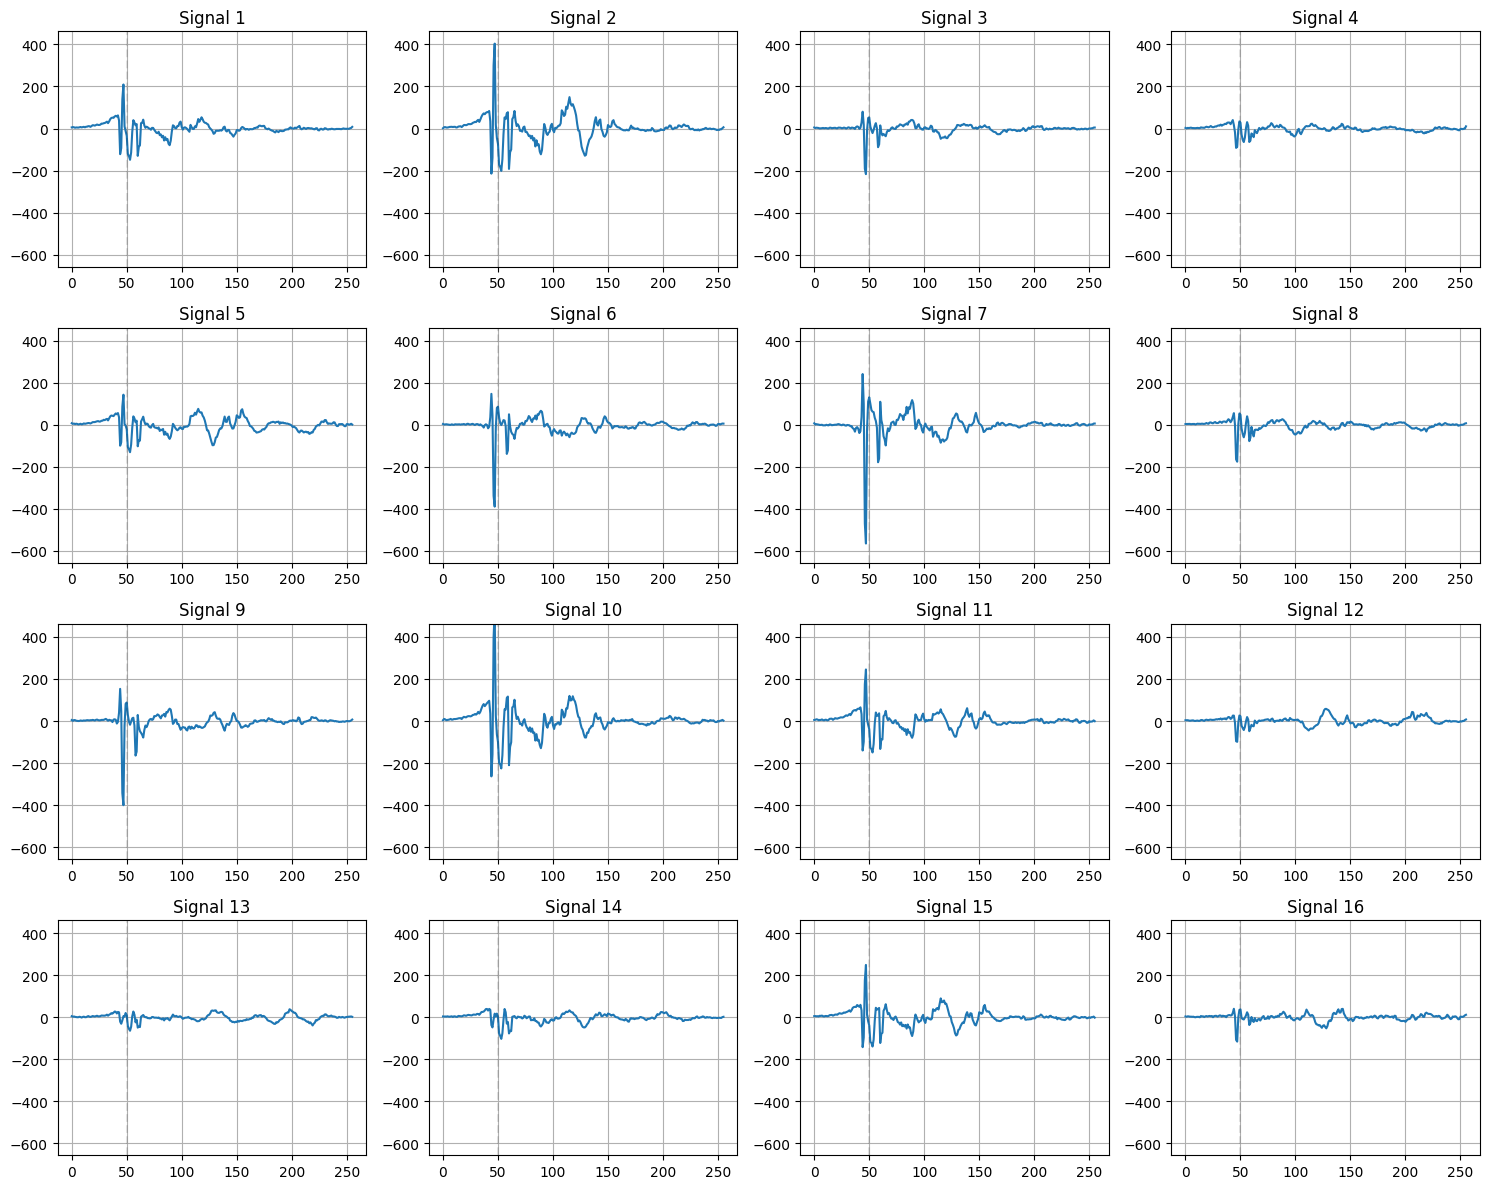

In [20]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data[0].to(device)
        real_parameters_gpu = data[1].to(device)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # soft labelling
        label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
        # flip selected labels
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1) # add parameters here!!!
        # output = netD(real_gpu, real_parameters_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device) # do we increase nz by 3 for parameters?
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 
    
    # learning-rate decay
    before_lr = optimizerD.param_groups[0]["lr"]
    schedulerD.step()
    after_lr = optimizerD.param_groups[0]["lr"]
    print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

    before_lr = optimizerG.param_groups[0]["lr"]
    schedulerG.step()
    after_lr = optimizerG.param_groups[0]["lr"]
    print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            y = y * dataset.scaling_factor
            y = y * dataset.std + dataset.mean
            ax.plot(x, y)

            ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim_signal)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % (epoch + 1))
        plt.show()
    
    # print(time.time())
    signal_list.append(fake_signals)

### Gradients

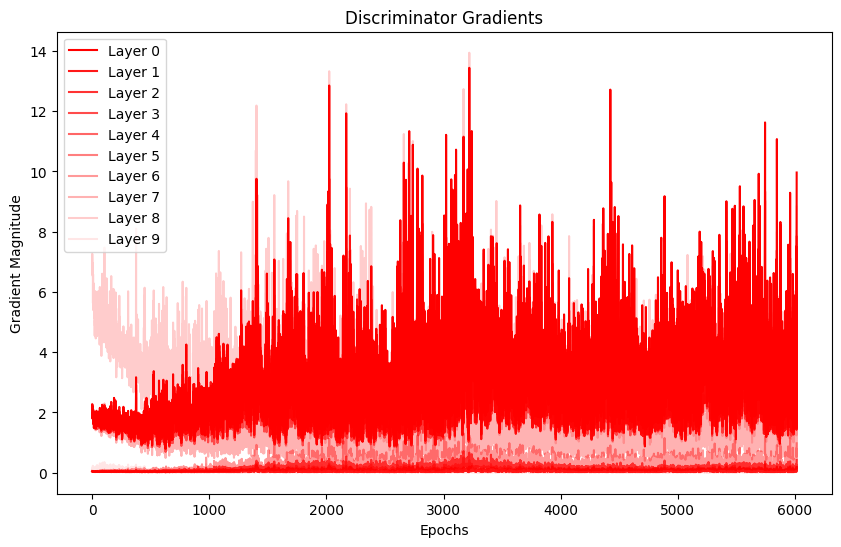

In [21]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

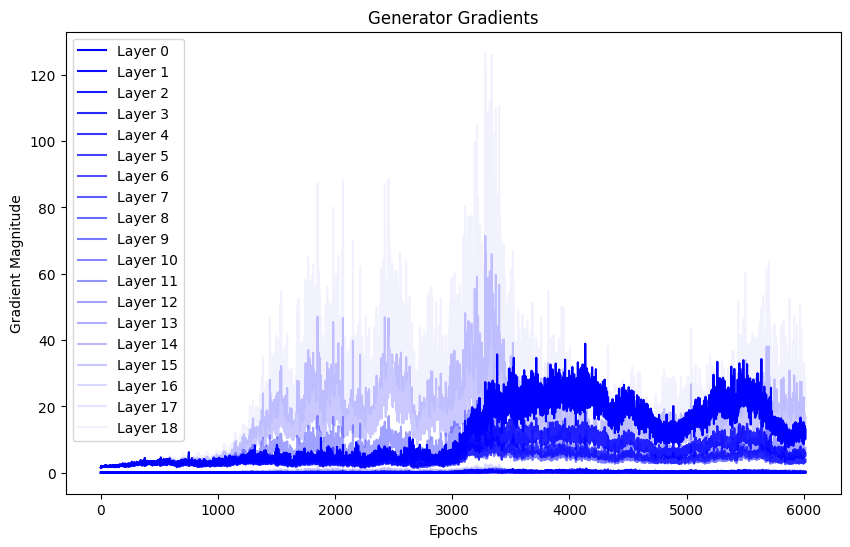

In [22]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

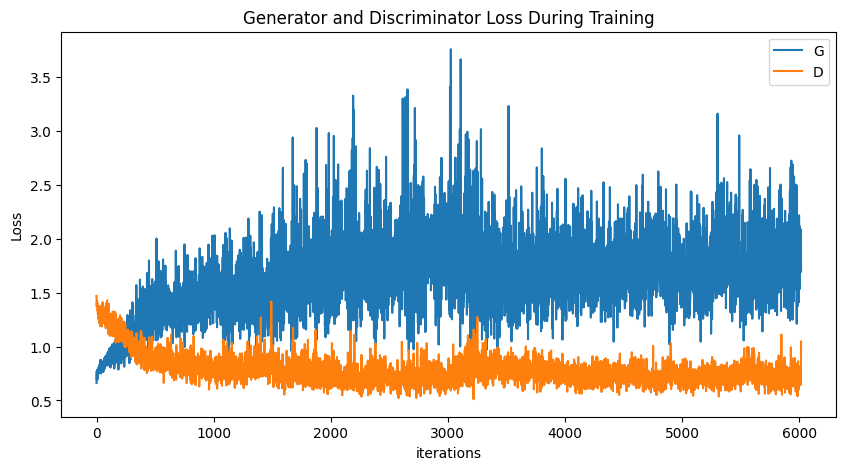

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 256])


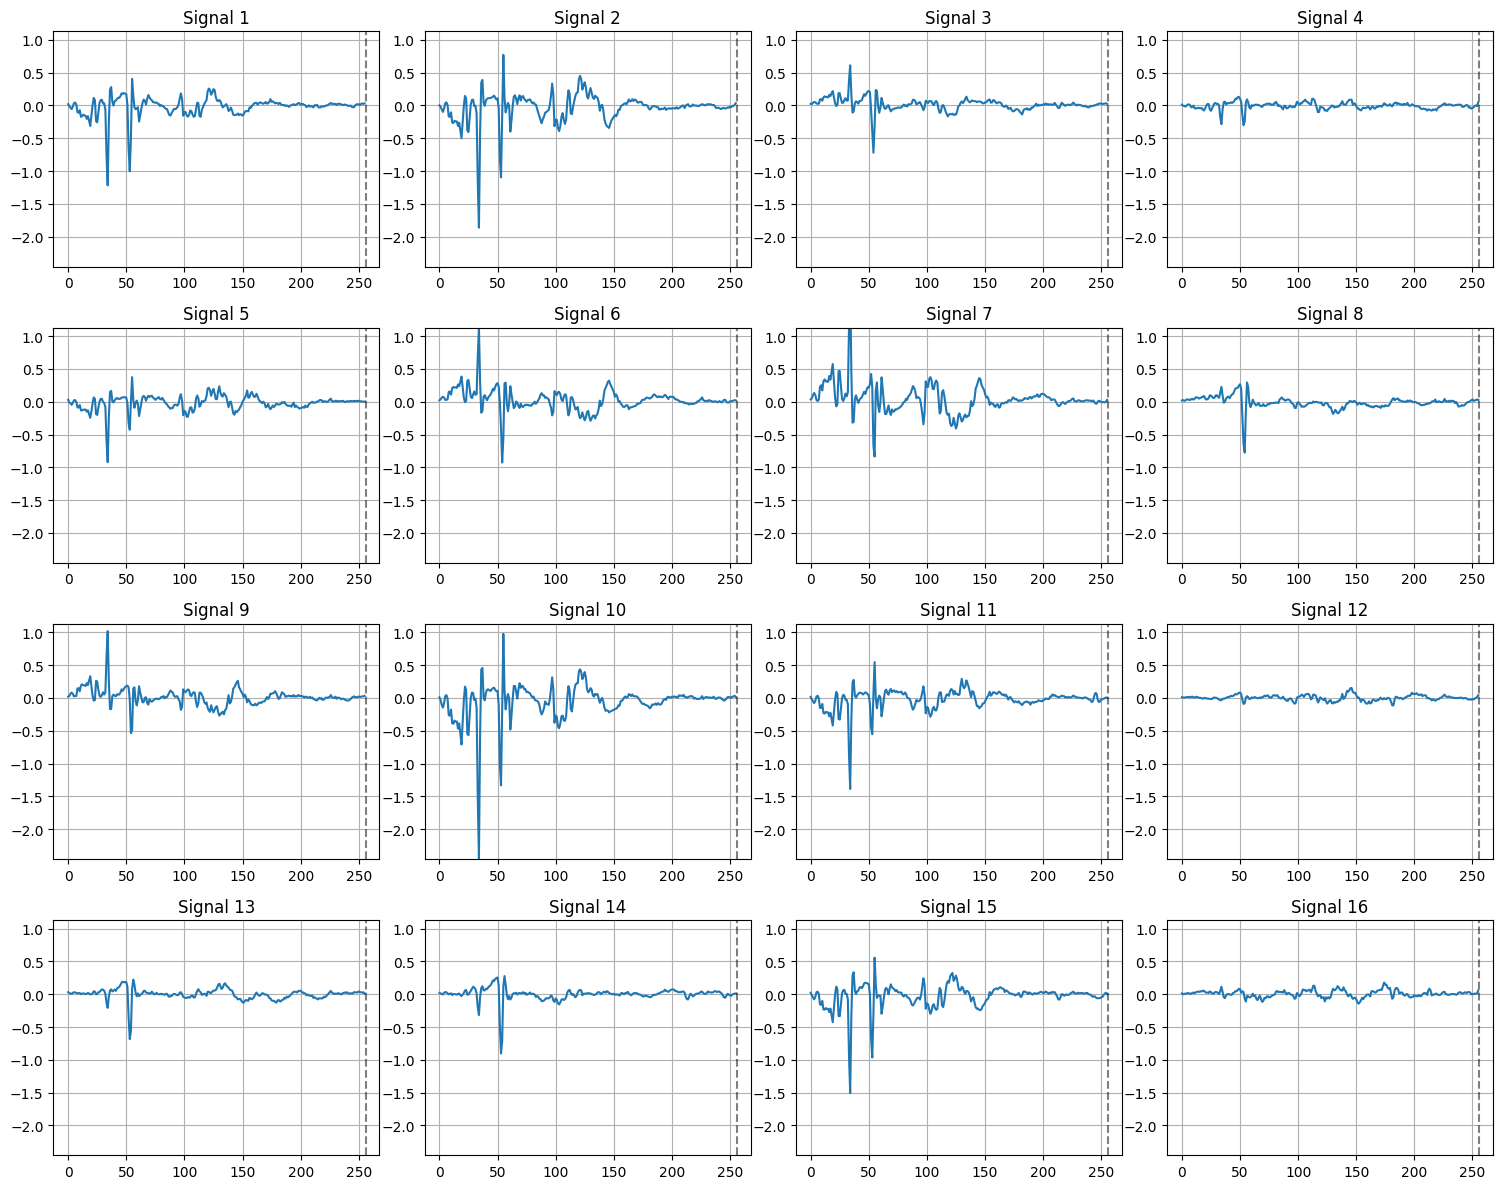

In [24]:
batch = signal_list[19]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [25]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)


### Evaluation Metrics for GANS